Парсим новости, создаем датафрейм

In [1]:
import pandas as pd
import requests
from fake_useragent import UserAgent
from bs4 import BeautifulSoup
from sentence_transformers.util import disabled_tqdm
from tqdm import tqdm

#класс, для парсинга новостей и записи в файл
class MyParsing:

    #создаем сессию
    session = requests.session()
    #создаем агента, который прикидывается браузером
    ua = UserAgent()
    headers = {'User-Agent': ua.random}
    #список ссылок
    list_link = []
    #список данных для записи в файл
    csv_data = []
    main_name = "https://www.zelao.ru/"
    page_name = "news/?select_tag=&offset="

    #функция парсинга страницы с новостями
    def parse_page(self, page_number):
        #получаем адрес, берем данные
        url = self.main_name + self.page_name + str(page_number)
        try:
            response = self.session.get(url, headers=self.headers)
        except Exception as e:
            print(e)
            return
        
        txt = response.text
        #парсим данные 
        soup = BeautifulSoup(txt, 'html.parser')
        
        #цикл по ссылкам с определенным классом
        for post in soup.find_all('a', {'class': 'n_det'})[:1000]:
            #text = post.get_text()
            attrs = post.attrs
            #если есть атрибут ссылка - добавляем ее в список новостей
            if 'href'  in attrs:
                href = post.attrs['href']
                self.list_link.append(href)
    #функция парсига сайта
    def parse_site(self):
        #номер первой страницы сайта
        num = 1690
        count = 0
        #Задаем количество страниц с новостями для просмотра. на каждой страниц по 30 новостей, так что должно получится 1050 новостей
        xs = [None] * 35
        print("Создаем список ссылок на новости")
        #парсим страницы новостей, т.к. на сайте идут в обратном порядке - уменьшаем счетчик
        for x in tqdm(xs):
            num -= 1
            self.parse_page(num)
    #функция парсинга одной новости
    def parse_news(self, link):
        #получаем адрес
        url = self.main_name + link

        #скачиваем страницу, если не получается - пишем ошибку и выходим из функции
        try:
            qw = 1
            response = self.session.get(url, headers=self.headers)
            txt = response.text
        except Exception as e:
            #print(e)
            return

        #инициализируем переменные атрибутов новости
        n_text = ""
        n_keywords = ""
        n_description = ""
        n_title = ""
        n_date = ""

        #парсим страницу
        soup = BeautifulSoup(txt, 'html.parser')
        
        #ищем текст новости
        for post in soup.find_all('div', {'class': 'news_text'}):
            try:
                n_text= post.get_text()
                #print(n_text)
            except :
                pass
        #в метатегах ищем описание, ключевые слова и заголовок
        for post in soup.find_all('meta'):
            if 'name' in post.attrs:
                if post.attrs['name'] == 'description':
                    #print("desc")
                    n_description = post.attrs['content']
                    #print(n_description)
                if post.attrs['name'] == 'keywords':
                    #print("keywords")
                    n_keywords = post.attrs['content']
                    #print(n_keywords)
            if "property" in post.attrs:
                if post.attrs['property'] == 'og:title':
                    #print("title")
                    n_title = post.attrs['content']
                    #print(n_title)
        #ищем дату новости
        for post in soup.find_all('a', {'class': 'news_url'}):
            try:
                #print(post.attrs)
                if pd.to_datetime(post.get_text()[:10], dayfirst = True):
                    #print("date")
                    n_date = post.get_text()[:10]
                    #print(n_date)
            except:
                pass
        #получаем новую строку для датафрейма
        newrow = [n_text, n_keywords, n_description, n_title, n_date]
        #добавляем новую строку в список для датафрейма
        self.csv_data.append(newrow)
        
    #создаем датафрейм
    def create_df(self):
        
        #очищаем список ссылок
        self.list_link.clear()
        #парсим сайт, получаем список ссылок на новости
        self.parse_site()

        print("Парсим новости")
        
        #парсим список ссылок на новости
        for l in tqdm(self.list_link):
            pp.parse_news(l)
        
        #создаем датафрейм из списка новостей
        df = pd.DataFrame(self.csv_data)
        #устанавливаем понятные название колонок датафрейма
        df.rename(columns={0: 'Текст', 1: 'Ключевые слова', 2: 'Описание', 3:"Заголовок", 4:"Дата"}, inplace=True)
        #сохраняем файл
        df.to_csv("data.csv", sep=',', index=False, encoding='utf-8')
        print("Данные сохранены")

#создаем переменную класса парсинга
pp = MyParsing()
#создаем датафрейм
pp.create_df()


/Users/dianalukinova/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/dianalukinova/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Создаем список ссылок на новости


100%|██████████| 35/35 [00:34<00:00,  1.02it/s]


Парсим новости


100%|██████████| 1050/1050 [13:41<00:00,  1.28it/s]

Данные сохранены


Читаем датафрейм из файла

In [2]:
import pandas as pd
df = pd.read_csv('data.csv')
print("Количество постов в файле: " + str(len(df)))

Количество постов в файле: 1050


Обрабатываем тексты, получаем именнованные сущности

Обрабатываем текст

In [3]:
import spacy
import ru_core_news_sm
from tqdm import tqdm
from keybert import KeyBERT

#фунция принимает тект и создает из него обработанные текст для векторной модели, делает список именованных сущностей 
def get_text(inputtext1):    
    #токенизируем текст
    doc = nlp(inputtext1)    
    ners1 = []
    newstr = ""
    newttext = ""
    #разбираем список токенов
    for w in doc:        
        #если токен - точка, добавляем строку
        if w.text == '.':            
            newstr = newstr.strip()
            newstr = newstr.replace('\n', '') 
            newstr = newstr.replace('\r', '')
            newttext += newstr.capitalize() + '\n'
            newstr = ""
        elif w.pos_ != 'PUNCT' and w.text.strip() != '':
            newstr += w.lemma_ + " "
    #обрабатываем последнюю строку
    if newstr != "":
        #lines1.append(newstr.capitalize()[:-1] + '\n')
        newstr = newstr.strip()
        newstr = newstr.replace('\n', '') 
        newstr = newstr.replace('\r', '')
        newttext += newstr.capitalize()[:-1] + '\n'
    #получаем список именованных сущностей
    for ent in doc.ents:
        ners1.append(ent.lemma_) 
    return ners1, newttext, doc
#подгружаем библиотеку для токенизации
global nlp
nlp = ru_core_news_sm.load()

#создаем пустые списки для текста, NER и ключевых слов
list_text = []
list_ners = []
list_keys = []

#создаем модель для определения ключевых слов
kw_model= KeyBERT()

print("Обработка текста")
#берем текст новостей из датафрейма, получаем из него обработанный текст, NER, ключевые слова
for line in tqdm(df['Текст']):
    ners, newtxt, words = get_text(line)
    list_text.append(newtxt)
    list_ners.append(ners)
    keywords = kw_model.extract_keywords(newtxt)
    list_keys.append(keywords)
#записываем обработанный текст в отдельный файл    
f = open("all.txt", 'w',encoding="UTF-8") 
for ll in list_text:
    for l in ll:
        f.write(l)
f.close()

Обработка текста


100%|██████████| 1050/1050 [24:16<00:00,  1.39s/it]


In [4]:
#Выделенные ключевые слова
print(list_keys)
#Выделенные именованные сущности
print(list_ners)


[[('постоялица', 0.3913), ('персик', 0.3863), ('помещение', 0.3531), ('препятствие', 0.3473), ('проект', 0.3439)], [('зеленоградский', 0.4471), ('зеленоград', 0.3835), ('мероприятие', 0.3483), ('шторм', 0.3446), ('проводить', 0.3392)], [('спрос', 0.3749), ('мероприятие', 0.356), ('городской', 0.3475), ('спортивный', 0.3469), ('популярность', 0.3348)], [('мероприятие', 0.3637), ('городской', 0.3452), ('академический', 0.3385), ('медицинский', 0.323), ('мегаполис', 0.321)], [('просветительский', 0.421), ('фотография', 0.4144), ('информация', 0.3958), ('профессиональный', 0.3723), ('городской', 0.3663)], [('поликлинический', 0.3984), ('сообщить', 0.3691), ('обновить', 0.362), ('особый', 0.3605), ('понедельник', 0.3261)], [('дворовый', 0.3513), ('игровой', 0.3492), ('современный', 0.3488), ('свой', 0.3462), ('реновация', 0.345)], [('центр', 0.3828), ('склифосовский', 0.3485), ('нейрохирургический', 0.3422), ('сердечный', 0.336), ('хирургический', 0.3316)], [('профсоюзный', 0.4991), ('профи

Обучаем модель на основе полученного текста

In [5]:
import gensim
data = gensim.models.word2vec.LineSentence('all.txt')
model = gensim.models.Word2Vec(data, window=10, min_count=2, sg=0)
print(model.wv)
model.save('my.model')

KeyedVectors<vector_size=100, 10954 keys>


Самые популярные именнованные сущности

Выводим график для 20 самых популярных именнованнх сущностей

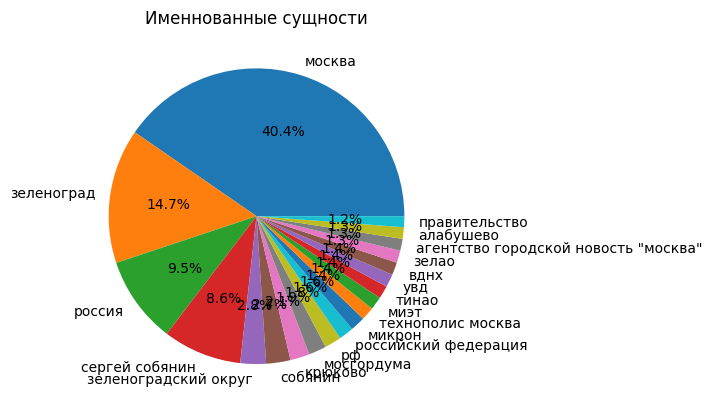

In [6]:
import matplotlib.pyplot as plt

#получаем список всех им. сущ
all_ners = []
for l in list_ners:
    for w in l:
        all_ners.append(w)
#создаем датафрейм, суммируем там вхождения, сортируем        
df_ners = pd.DataFrame({"Word": all_ners})
df_ners['Frequency'] = 1
df_ners =  pd.pivot_table(df_ners, index=["Word"], values=["Frequency"], aggfunc="sum")
df_ners = df_ners.sort_values(by=['Frequency'] , ascending=False)

#выводим график
df = df_ners.head(20)
plt.title('Именнованные сущности')
plt.pie(df.Frequency, labels=df.index, autopct='%1.1f%%')
plt.show()


Наиболее популярными именованными сущностями являются названия мест (Россия, Москва, Зеленоград) и людей, которые с этим как-то связаны (Сергей Собянин, Собянин), что вполне логично для сайта про районные новости

Статистика по тегам (ключевым словам) из новостей

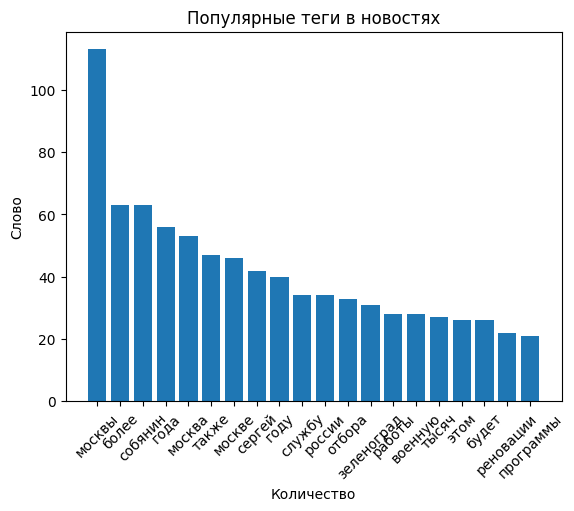

In [7]:
df = pd.read_csv('data.csv')
#создаем список тегов из всех новостей
list_tags = []
for line in df['Ключевые слова']:
    l = line.split(",")
    for w in l:
        list_tags.append(w.strip())
        
#делаем датафрейм из тегов, суммируем и сортируем      
df = pd.DataFrame({"Word": list_tags})
df['Frequency'] = 1
df =  pd.pivot_table(df, index=["Word"], values=["Frequency"], aggfunc="sum")
df = df.sort_values(by=['Frequency'] , ascending=False)
df = df.head(20)

#выводим график
plt.title('Популярные теги в новостях')
#plt.pie(df.Frequency, labels=df.index, autopct='%1.1f%%')
#plt.show()
plt.xlabel("Количество")
plt.ylabel("Слово")
plt.bar(df.index, df.Frequency)
plt.xticks(df.index, df.index, rotation=45)
plt.show()

Среди тегов (ключевых слов) популярными также являются названия городов и фамилии

Загружаем готовую модель

In [8]:

#получаем файл со готовой моделью

import urllib.request
urllib.request.urlretrieve('http://vectors.nlpl.eu/repository/20/180.zip', 'ruscorpora_upos_cbow_300_20_2019.zip')

('ruscorpora_upos_cbow_300_20_2019.zip',
 <http.client.HTTPMessage at 0x3ec2d7fd0>)

Распаковываем модель

In [9]:
#распаковываем модель

import zipfile

src = 'ruscorpora_upos_cbow_300_20_2019.zip'

with zipfile.ZipFile(src, 'r') as zip_ref:
    zip_ref.extractall('.')
m = 'model.bin'
rus_model = gensim.models.KeyedVectors.load_word2vec_format(m, binary=True)    

Ищем ближайшие слова для ключевых слов

In [10]:
from prettytable import PrettyTable

#создаем два списка ближаших слов. По созданной модели и по готовой

list_top5 = []
list_top5rus = []

#файл для результатов
f = open("keys.txt", 'w+')

#Цикл по спискам ключевых слов
for l in tqdm(list_keys):
    #списки для хранение результатов по новости
    l1 = []
    l2 = []
    for ww in l:
        #списки для хранения результаов по слову
        lll1 = []
        lll2 = []
        #получаем ключевое слово
        w = ww[0]
        #если слово есть в модели  
        if w in model.wv.index_to_key:
           #добавляем пять слов входящих в пять популярной в обученной модели
           for i in model.wv.similar_by_word(w, topn=5):
            l1.append(i[0])
            lll1.append(i[0])
        doc = nlp(w)
        #токенизируем слово, т.к. нам нужно слово с частью речи
        for token in doc:
            w1 = token.text + '_' + token.pos_    
        if w1 in rus_model.index_to_key:
            for i in rus_model.similar_by_word(w1, topn=5):
                #добавляем пять слов входящих в пять популярной в готовой модели
                l2.append(i[0][:i[0].find("_")])
                lll2.append(i[0][:i[0].find("_")])
        #если есть ближайшие слова - пишем результаты в файл
        if len(lll1) != 0 and len(lll2) != 0:
            #if max_show > 0:
            f.write('\n')
            f.write(w)
            f.write('\n')
            table = PrettyTable()
            table.add_column("Обученная", lll1)
            table.add_column("Готовая", lll2)
            
            f.write(table.get_string())
            print(w)
            print(table.get_string())                

    #добавляем в общием списки
    list_top5.append(l1)
    list_top5rus.append(l2)        
f.close()

  0%|          | 3/1050 [00:00<02:11,  7.98it/s]

помещение
+----------------+----------+
|   Обученная    | Готовая  |
+----------------+----------+
|     мебель     |  здание  |
|    беговой     | квартира |
| принадлежность | комнатка |
|    лестница    | комната  |
|   теннисный    |  подвал  |
+----------------+----------+
препятствие
+--------------+-------------+
|  Обученная   |   Готовая   |
+--------------+-------------+
| профилактика |   преграда  |
|    собака    | затруднение |
|  устройство  |  трудность  |
|    одежда    |   препона   |
|  постельный  |    помеха   |
+--------------+-------------+
проект
+---------------+--------------+
|   Обученная   |   Готовая    |
+---------------+--------------+
| реализоваться |  программа   |
|     город     |   пилотный   |
|    столица    |    проект    |
|   реализация  | законопроект |
|     целое     |  программа   |
+---------------+--------------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+------

  0%|          | 5/1050 [00:00<01:46,  9.85it/s]

городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
академический
+-------------+-----------------+
|  Обученная  |     Готовая     |
+-------------+-----------------+
|    дорога   |     академия    |
|   автобус   | университетский |
|    фасад    |  профессорский  |
| олимпийский |    вузовский    |
|    Новый    | академия::наука |
+-------------+-----------------+
медицинский
+------------+----------------+
| Обученная  |    Готовая     |
+------------+----------------+
|   скорый   |   врачебный    |
| отправлять |      врач      |
|    дгкб    |  медицинский   |
|  оказание  | онкологический |
| пострадать |     медик      |
+------------+----------------+
мегаполис
+------------------+----------------

  1%|          | 7/1050 [00:00<01:33, 11.21it/s]

понедельник
+----------------+-------------+
|   Обученная    |   Готовая   |
+----------------+-------------+
| осуществляться |   вторник   |
|       от       |   пятница   |
|    четверг     |   четверг   |
|     14:00      |   суббота   |
|     20.00      | воскресенье |
+----------------+-------------+
дворовый
+-----------------+------------+
|    Обученная    |  Готовая   |
+-----------------+------------+
|      жилой      |   дворня   |
| отремонтировать |  дворень   |
|      ручей      |  даточный  |
|      болдов     |  барский   |
|     асфальт     | господский |
+-----------------+------------+
игровой
+---------------+---------------+
|   Обученная   |    Готовая    |
+---------------+---------------+
|    уличный    |    ролевой    |
|    пляжный    |      игра     |
|    школьный   |    боулинг    |
| универсальный |  виртуальный  |
|    ледовый    | баскетбольный |
+---------------+---------------+
современный
+--------------+---------------+
|  Обученная   |    Готова

  1%|          | 11/1050 [00:01<01:21, 12.67it/s]

оформление
+---------------+--------------+
|   Обученная   |   Готовая    |
+---------------+--------------+
| необходимость |  оформлять   |
|  исполнитель  |   оформить   |
|     право     |  размещение  |
|   население   |  заполнение  |
|  обеспечивать | согласование |
+---------------+--------------+
широкий
+--------------+------------+
|  Обученная   |  Готовая   |
+--------------+------------+
| обеспечивать |   узкий    |
| пользоваться | широчайший |
|     ряд      |  широкий   |
|  заниматься  |  обширный  |
|    анализ    | широчайать |
+--------------+------------+
подготовка
+-----------+------------------+
| Обученная |     Готовая      |
+-----------+------------------+
|  ключевой |     обучение     |
|   связь   |    подготовка    |
|  кадровый |  подготавливать  |
|  наследие | подготовительный |
|  ведущий  |   организация    |
+-----------+------------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-

  1%|▏         | 15/1050 [00:01<01:17, 13.27it/s]

полиция
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
|   отдел   |   полиция   |
|   майор   | полицейский |
|   вадим   | полицейский |
| александр | жандармерия |
| президент |   жандарм   |
+-----------+-------------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+--------------------+
миграция
+---------------+--------------+
|   Обученная   |   Готовая    |
+---------------+--------------+
|    андреев    |   мигрант    |
| зафиксировать |  иммиграция  |
|     рынок     |  расселение  |
|      илья     | миграционный |
|     оценка    |  циркуляция  |
+---------------+--------------+
федерация
+----------------+-------------

  2%|▏         | 17/1050 [00:01<01:21, 12.66it/s]

продукция
+---------------------+------------------+
|      Обученная      |     Готовая      |
+---------------------+------------------+
|      благодаря      | металлопродукция |
|       средний       |     продукт      |
|       значение      |      сырье       |
| высокотехнологичный |   производство   |
|        статус       |     изделие      |
+---------------------+------------------+
операция
+-------------+--------------+
|  Обученная  |   Готовая    |
+-------------+--------------+
| специальный |   операция   |
|     сво     | спецоперация |
|   участник  |  процедура   |
|    семья    | шунтирование |
|  снаряжение |    маневр    |
+-------------+--------------+
специальный
+------------+--------------------+
| Обученная  |      Готовая       |
+------------+--------------------+
|  операция  |  соответствующий   |
|    сво     | специализированный |
|  участник  |     специально     |
|   семья    |       особый       |
| снаряжение |   дополнительный   |
+------------+-

  2%|▏         | 19/1050 [00:01<01:18, 13.20it/s]

высокоскоростной
+------------+------------------+
| Обученная  |     Готовая      |
+------------+------------------+
|  основать  | высокоскоростный |
| наградить  |  широкополосный  |
| магистраль |   беспроводный   |
| номинация  |   беспроводной   |
|   премия   |      wifi-       |
+------------+------------------+
сообщить
+-----------------+------------+
|    Обученная    |  Готовая   |
+-----------------+------------+
|     сергунин    |  сообщать  |
|     министр     |  извещать  |
|     написать    |  доложить  |
| мосгоризбиркома | уведомить  |
|    поручение    | уведомлять |
+-----------------+------------+
строиться
+----------------+-------------+
|   Обученная    |   Готовая   |
+----------------+-------------+
|     фасад      |   строить   |
|     бывший     | достраивать |
| проектирование | выстраивать |
|      блок      |  построить  |
|  документация  |  выстроить  |
+----------------+-------------+
застройщик
+-----------+-------------+
| Обученная |   Готовая  

  2%|▏         | 23/1050 [00:01<01:20, 12.81it/s]

сообщить
+-----------------+------------+
|    Обученная    |  Готовая   |
+-----------------+------------+
|     сергунин    |  сообщать  |
|     министр     |  извещать  |
|     написать    |  доложить  |
| мосгоризбиркома | уведомить  |
|    поручение    | уведомлять |
+-----------------+------------+
медицинский
+------------+----------------+
| Обученная  |    Готовая     |
+------------+----------------+
|   скорый   |   врачебный    |
| отправлять |      врач      |
|    дгкб    |  медицинский   |
|  оказание  | онкологический |
| пострадать |     медик      |
+------------+----------------+
модернизация
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|     пилотный     |   модернизация   |
|      войти       |  реконструкция   |
|    масштабный    |  реформирование  |
| гастрономический | реструктуризация |
|       лето       |  перевооружение  |
+------------------+------------------+
реконструкция
+------

  2%|▏         | 25/1050 [00:02<01:18, 13.14it/s]

экспериментальный
+--------------+------------------+
|  Обученная   |     Готовая      |
+--------------+------------------+
| операционный |   лабораторный   |
|     зал      |   исследование   |
| танцевальный |   эксперимент    |
|   отделка    | экспериментально |
| олимпийский  |  теоретический   |
+--------------+------------------+
пионер
+-----------------+--------------+
|    Обученная    |   Готовая    |
+-----------------+--------------+
|   объединение   |  пионерский  |
|      особый     |  октябренок  |
| функционировать |  комсомолец  |
|    масштабный   |   пионерка   |
|     крупный     | пионерлагерь |
+-----------------+--------------+
продлиться
+-----------+-----------------+
| Обученная |     Готовая     |
+-----------+-----------------+
|  декабрь  |     длиться     |
|   ноябрь  |   продолжаться  |
|   19:00   |    затянуться   |
|     31    |     протечь     |
|  октябрь  | просуществовать |
+-----------+-----------------+
исследовательский
+--------------+---

  3%|▎         | 27/1050 [00:02<01:29, 11.43it/s]

центр
+---------------+-------------+
|   Обученная   |   Готовая   |
+---------------+-------------+
|     научно    |    центр    |
|   московский  | центральный |
|   культурный  |    центра   |
|    торгово    |  периферия  |
| инновационный |   комплекс  |
+---------------+-------------+
заведующий
+------------------+-------------+
|    Обученная     |   Готовая   |
+------------------+-------------+
|  исполнительный  |  заведующий |
|    сотрудник     |  заведовать |
| подведомственный | завадратный |
|    экспертный    | завадратный |
|     вручить      |  заведовать |
+------------------+-------------+
александровка
+-----------+--------------+
| Обученная |   Готовая    |
+-----------+--------------+
|   аллея   |     days     |
| андреевка |  2005.03.07  |
|   гоголь  |     lvov     |
|  строение |  formation   |
|  проспект | determinants |
+-----------+--------------+
адрес
+-----------+------------+
| Обученная |  Готовая   |
+-----------+------------+
|    ул.    |   ад

  3%|▎         | 31/1050 [00:02<01:17, 13.09it/s]

строительство
+-----------------+---------------+
|    Обученная    |    Готовая    |
+-----------------+---------------+
| благоустройство | реконструкция |
|    алабушево    |   строитель   |
|        a        |   строиться   |
|   комплексный   |   возведение  |
|  реконструкция  |  строительный |
+-----------------+---------------+
организация
+---------------+-----------------+
|   Обученная   |     Готовая     |
+---------------+-----------------+
|      кино     |   объединение   |
|      база     |   организация   |
|     среда     |    учреждение   |
| разрабатывать | организационный |
|   Московский  |      орган      |
+---------------+-----------------+
реализация
+-------------+---------------+
|  Обученная  |    Готовая    |
+-------------+---------------+
|  соглашение |  реализовать  |
| реализовать | осуществление |
|   столица   |   разработка  |
|   открытие  |  формирование |
|  церемония  | использование |
+-------------+---------------+
просить
+------------+-----

  3%|▎         | 33/1050 [00:02<01:20, 12.58it/s]

автомобилист
+---------------+--------------+
|   Обученная   |   Готовая    |
+---------------+--------------+
|    занимать   | автолюбитель |
|   обеспечить  | автовладелец |
| зеленоградцев | велосипедист |
|    квартира   |  автомобиль  |
|      один     |   водитель   |
+---------------+--------------+
центральный
+---------------+-----------------+
|   Обученная   |     Готовая     |
+---------------+-----------------+
|    академик   |      центр      |
|    деревня    |     основной    |
| предусмотреть | северо-западный |
|     между     |  юго-восточный  |
|    стадион    |     главный     |
+---------------+-----------------+
исторический
+---------------+---------------+
|   Обученная   |    Готовая    |
+---------------+---------------+
|   мастерство  |    история    |
| отечественный |     эпоха     |
|   продолжать  |    историк    |
|    практика   | -исторический |
|    высокий    |   культурный  |
+---------------+---------------+
церковь
+-----------+-----------+
|

  4%|▎         | 37/1050 [00:03<01:18, 12.90it/s]

школа
+-----------------+---------------------+
|    Обученная    |       Готовая       |
+-----------------+---------------------+
|   поликлиника   |        школа        |
|   фестивальный  |       училище       |
| многопрофильный |       гимназия      |
|      ремонт     | общеобразовательный |
|      здание     |       интернат      |
+-----------------+---------------------+
урок
+------------+-----------+
| Обученная  |  Готовая  |
+------------+-----------+
|   ранний   |    урок   |
|    срок    | переменка |
| фотография |  учитель  |
|  основный  | репетитор |
|  которого  |  занятие  |
+------------+-----------+
ассоциация
+-----------+-----------------+
| Обученная |     Готовая     |
+-----------+-----------------+
|   кирилл  |    ассоциация   |
|   павел   |   объединение   |
|   ирина   |  ассоциативный  |
|  татьяна  |       союз      |
|    пётр   | межрегиональный |
+-----------+-----------------+
продукция
+---------------------+------------------+
|      Обученная

  4%|▍         | 41/1050 [00:03<01:21, 12.38it/s]

предпринимательский
+-----------------+---------------------+
|    Обученная    |       Готовая       |
+-----------------+---------------------+
| технологический |   предприниматель   |
|  патриотический |     коммерческий    |
|   гражданский   |     юридический     |
|  педагогический |    имущественный    |
|    структура    | внешнеэкономический |
+-----------------+---------------------+
экономический
+---------------+----------------+
|   Обученная   |    Готовая     |
+---------------+----------------+
|      elmt     |   экономика    |
| инновационный |   социальный   |
|  промышленный |   финансовый   |
|     особый    |  политический  |
|    резидент   | -экономический |
+---------------+----------------+
практический
+------------+---------------+
| Обученная  |    Готовая    |
+------------+---------------+
| искусство  | теоретический |
| инструмент |     знание    |
|   студия   |    научный    |
| творческий |    практика   |
|  например  |  рациональный |
+-----------

  4%|▍         | 43/1050 [00:03<01:18, 12.79it/s]

кантемировский
+--------------+----------------+
|  Обученная   |    Готовая     |
+--------------+----------------+
|     7.00     |     201-й      |
|   доехать    | мотострелковый |
|    11:30     |   -десантный   |
|   липецкий   | дислоцировать  |
| патентование |      вдв       |
+--------------+----------------+
реконструкция
+-----------------+---------------+
|    Обученная    |    Готовая    |
+-----------------+---------------+
|   капитальный   | строительство |
| благоустройство |  модернизация |
|    стартовать   |    санация    |
|       парк      |     проект    |
|     учебный     |  газификация  |
+-----------------+---------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
скорост

  4%|▍         | 47/1050 [00:03<01:10, 14.17it/s]

специалист
+------------------+-------------------------+
|    Обученная     |         Готовая         |
+------------------+-------------------------+
|     являться     |         эксперт         |
|   электроника    |          ученый         |
| профессиональный |       консультант       |
|  способствовать  |       профессионал      |
|     отрасль      | высококвалифицированный |
+------------------+-------------------------+
энергия
+-----------+-----------+
| Обученная |  Готовая  |
+-----------+-----------+
|    ему    |  энергия  |
|   острый  |    сила   |
|    ключ   |  импульс  |
|  общество | излучение |
|  русский  |   заряд   |
+-----------+-----------+
академия
+-------------+-------------+
|  Обученная  |   Готовая   |
+-------------+-------------+
|    ирина    |   академия  |
| архитектура | университет |
|    кирилл   | университет |
|     пётр    |   институт  |
|  хозяйство  |  факультет  |
+-------------+-------------+
центр
+---------------+-------------+
|   Обу

  5%|▍         | 49/1050 [00:04<01:23, 12.02it/s]

проспект
+--------------+------------+
|  Обученная   |  Готовая   |
+--------------+------------+
|    аллея     |  невский   |
| георгиевский |  бульвар   |
|   алексеев   |   улица    |
|   напротив   |  переулок  |
| панфиловский | набережная |
+--------------+------------+
архитектурный
+--------------+---------------+
|  Обученная   |    Готовая    |
+--------------+---------------+
|     сеть     |  архитектура  |
|  восточный   |  архитектурно |
| строительный |  архитектурно |
|  активность  | планировочный |
|  архитектор  |   архитектор  |
+--------------+---------------+
западный
+---------------+--------------------+
|   Обученная   |      Готовая       |
+---------------+--------------------+
|   восточный   |     восточный      |
|      сеть     |    европейский     |
| архитектурный | западноевропейский |
|   архитектор  |       запад        |
|   поставить   |       европа       |
+---------------+--------------------+
зеленоградский
+------------------+---------------

  5%|▍         | 51/1050 [00:04<01:31, 10.96it/s]

грипп
+------------------+---------------+
|    Обученная     |    Готовая    |
+------------------+---------------+
|        рф        |    инфекция   |
|     судебный     |     вирус     |
|      михаил      |    пандемия   |
| профилактический |      орви     |
|   заслуженный    | эпидемический |
+------------------+---------------+
город
+---------------------+----------+
|      Обученная      | Готовая  |
+---------------------+----------+
|    реализоваться    | столица  |
|        проект       |  город   |
|       входить       | городок  |
|       столица       | пригород |
| предпринимательство |  москва  |
+---------------------+----------+
поликлинический
+--------------+--------------+
|  Обученная   |   Готовая    |
+--------------+--------------+
|    филиал    | амбулаторный |
|      №       | медицинский  |
|   проспект   |  диспансер   |
|      19      |  стационар   |
| панфиловский | медперсонал  |
+--------------+--------------+
проводиться
+--------------+--------

  5%|▌         | 53/1050 [00:04<01:23, 11.91it/s]

второй
+-----------+-----------+
| Обученная |  Готовая  |
+-----------+-----------+
|  начаться | четвертый |
|   войти   |   третий  |
|    ввод   |   пятый   |
|   сезон   |   первый  |
|   поток   |   шестой  |
+-----------+-----------+
церемония
+---------------+----------------+
|   Обученная   |    Готовая     |
+---------------+----------------+
| торжественный |   церемониал   |
|     премия    | церемониальный |
|    сборная    |     обряд      |
|   завершение  |     ритуал     |
|     всм-1     |  празднество   |
+---------------+----------------+
пройти
+-----------+------------+
| Обученная |  Готовая   |
+-----------+------------+
| проходить | проходить  |
|     28    |  пройдать  |
|    июль   |  пройдть   |
|  декабрь  | пройденный |
|     31    |  пройдять  |
+-----------+------------+
соревнование
+------------+------------+
| Обученная  |  Готовая   |
+------------+------------+
| платформа  | состязание |
|   доступ   |   турнир   |
| посетитель | спортсмен  |
|  

  5%|▌         | 57/1050 [00:04<01:23, 11.84it/s]

префектура
+----------------+---------------+
|   Обученная    |    Готовая    |
+----------------+---------------+
| зеленоградский |    префект    |
|    префект     |     мэрия     |
|   управление   | муниципалитет |
|       ао       |    полиция    |
|      увд       |      цао      |
+----------------+---------------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+--------------------+
сообщить
+-----------------+------------+
|    Обученная    |  Готовая   |
+-----------------+------------+
|     сергунин    |  сообщать  |
|     министр     |  извещать  |
|     написать    |  доложить  |
| мосгоризбиркома | уведомить  |
|    поручение    | уведомлять |
+-------

  6%|▌         | 59/1050 [00:04<01:17, 12.74it/s]

зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+--------------------+
заканчиваться
+---------------------+-------------+
|      Обученная      |   Готовая   |
+---------------------+-------------+
|      дистанция      | завершаться |
| благотворительность |  начинаться |
|      разместить     |  окончиться |
|       тарелка       | завершиться |
|       квартира      |  кончаться  |
+---------------------+-------------+
разворотный
+---------------+----------------+
|   Обученная   |    Готовая     |
+---------------+----------------+
|    уличный    |     тренд      |
|     бордюр    |      гэп       |
|     замена    | полноприводный |
| демонтировать |     passat 

  6%|▌         | 63/1050 [00:05<01:16, 12.91it/s]

зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+--------------------+
профессиональный
+------------+-----------------+
| Обученная  |     Готовая     |
+------------+-----------------+
|   спрос    |   профессионал  |
|  являться  |    профессия    |
|  отрасль   | профессионализм |
| совместный |  -профессионал  |
|  обсудить  | квалифицировать |
+------------+-----------------+
реконструкция
+-----------------+---------------+
|    Обученная    |    Готовая    |
+-----------------+---------------+
|   капитальный   | строительство |
| благоустройство |  модернизация |
|    стартовать   |    санация    |
|       парк      |     проект    |
|     учебный     |  газифи

  6%|▌         | 65/1050 [00:05<01:15, 13.01it/s]

проводиться
+--------------+------------+
|  Обученная   |  Готовая   |
+--------------+------------+
|     цикл     | проводить  |
| тематический | проводить  |
|    зимний    | проведение |
| олимпийский  |  вестись   |
|   который    | проведять  |
+--------------+------------+
немецкий
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
|   против  |  германский |
| калужский | французский |
|     а.    |    немец    |
|   войско  | австрийский |
|  николай  |  английский |
+-----------+-------------+
аудитория
+------------+-----------+
| Обученная  |  Готовая  |
+------------+-----------+
|  высокий   | слушатель |
| продолжать | аудитория |
|  будущий   |  публика  |
|  уровень   |   лектор  |
|  документ  |   лекция  |
+------------+-----------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактич

  7%|▋         | 69/1050 [00:05<01:16, 12.79it/s]

москвич
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
| позволить | петербуржец |
|   смочь   | ленинградец |
| горожанин |  столичный  |
|   сейчас  |  горожанин  |
|   спасти  |  москвичка  |
+-----------+-------------+
функционал
+---------------+------------------+
|   Обученная   |     Готовая      |
+---------------+------------------+
| проголосовать |   подмножество   |
|     любой     | пользовательский |
|  удовольствие |    переменная    |
|  использовать | параметрический  |
|    больной    |     алгоритм     |
+---------------+------------------+
снимок
+-----------+-----------------+
| Обученная |     Готовая     |
+-----------+-----------------+
|   книга   |    фотоснимок   |
|  больший  |    фотография   |
|   ранее   |       фото      |
|  выбирать |     фотограф    |
|  комната  | фотографировать |
+-----------+-----------------+
технологический
+-----------------+------------------+
|    Обученная    |     Готовая      |
+------

  7%|▋         | 71/1050 [00:05<01:26, 11.29it/s]

история
+--------------------+--------------+
|     Обученная      |   Готовая    |
+--------------------+--------------+
|    развиваться     |   история    |
|        роль        | исторический |
|        идея        |  биография   |
| продемонстрировать |   историк    |
|     правильный     |    эпоха     |
+--------------------+--------------+
реставрация
+-----------+-----------------+
| Обученная |     Готовая     |
+-----------+-----------------+
|  памятник |  реставрировать |
|  собрание | реставрационный |
|   игорь   |   реставратор   |
|   дворец  |  восстановление |
|  художник |  реконструкция  |
+-----------+-----------------+
церемония
+---------------+----------------+
|   Обученная   |    Готовая     |
+---------------+----------------+
| торжественный |   церемониал   |
|     премия    | церемониальный |
|    сборная    |     обряд      |
|   завершение  |     ритуал     |
|     всм-1     |  празднество   |
+---------------+----------------+
социалистический
+-------

  7%|▋         | 75/1050 [00:06<01:37, 10.03it/s]

настоящий
+-------------+-------------+
|  Обученная  |   Готовая   |
+-------------+-------------+
|   очередь   |  настоящий  |
| реализовать | описываемый |
|   открытие  |  настоящее  |
|   отмечать  |    данный   |
| постараться |   будущее   |
+-------------+-------------+
пройти
+-----------+------------+
| Обученная |  Готовая   |
+-----------+------------+
| проходить | проходить  |
|     28    |  пройдать  |
|    июль   |  пройдть   |
|  декабрь  | пройденный |
|     31    |  пройдять  |
+-----------+------------+
школьный
+-------------+---------------+
|  Обученная  |    Готовая    |
+-------------+---------------+
|   уличный   | гимназический |
|  футбольный |  ученический  |
|    газон    |    школьник   |
|    озеро    |  институтский |
| прогулочный | первоклассник |
+-------------+---------------+
школьник
+---------------+----------------+
|   Обученная   |    Готовая     |
+---------------+----------------+
|    студент    | старшеклассник |
|   творческий  | первок

  7%|▋         | 77/1050 [00:06<01:45,  9.24it/s]

городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
оформление
+---------------+--------------+
|   Обученная   |   Готовая    |
+---------------+--------------+
| необходимость |  оформлять   |
|  исполнитель  |   оформить   |
|     право     |  размещение  |
|   население   |  заполнение  |
|  обеспечивать | согласование |
+---------------+--------------+
артист
+--------------+-----------+
|  Обученная   |  Готовая  |
+--------------+-----------+
|   татьяна    |   актер   |
| гражданский  |  артистка |
|  внутренний  |   театр   |
| безопасность |  режиссер |
|   главный    | танцовщик |
+--------------+-----------+
пройти
+-----------+------------+
| Обученная |  Готовая   |
+-----------+------------+
| 

  8%|▊         | 79/1050 [00:06<01:44,  9.30it/s]

спасательный
+----------------+-----------------------+
|   Обученная    |        Готовая        |
+----------------+-----------------------+
|      юлия      |       спасатель       |
| исполнительный |     -спасательный     |
|    культура    |       аварийный       |
|    институт    | поисково-спасательный |
|   служебный    |       водолазный      |
+----------------+-----------------------+
опасный
+-----------+--------------+
| Обученная |   Готовая    |
+-----------+--------------+
|   острый  | рискованный  |
|  защитник | небезопасный |
|    ему    |   вредный    |
|   читать  |  опасность   |
|    ключ   | губительный  |
+-----------+--------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+----------

  8%|▊         | 80/1050 [00:06<01:51,  8.68it/s]

здравоохранение
+----------------+------------------+
|   Обученная    |     Готовая      |
+----------------+------------------+
|   инновация    |     минздрав     |
|   транспорт    |   медицинский    |
| информационный | минздрав::россия |
|   экономика    |   профилактика   |
|   столичный    |    соцзащита     |
+----------------+------------------+
предприятие
+---------------+------------------+
|   Обученная   |     Готовая      |
+---------------+------------------+
|     сфера     |   производство   |
| производитель |     отрасль      |
|   экономика   | производственный |
|     бизнес    |  промышленность  |
|    ключевой   |    продукция     |
+---------------+------------------+
горожанин
+-----------------+-----------+
|    Обученная    |  Готовая  |
+-----------------+-----------+
|     посещать    |   житель  |
| воспользоваться | обыватель |
|     начинать    |  москвич  |
|      смочь      | сельчанин |
|     улучшить    | городской |
+-----------------+-----------+

  8%|▊         | 81/1050 [00:07<02:00,  8.04it/s]

познакомиться
+--------------+---------------+
|  Обученная   |    Готовая    |
+--------------+---------------+
| удовольствие |  знакомиться  |
|     вид      |  познакомить  |
|    любой     |   знакомить   |
|    вместе    | ознакомляться |
|   отдыхать   |  ознакомиться |
+--------------+---------------+
стадия
+-----------+---------+
| Обученная | Готовая |
+-----------+---------+
|  коробка  |   этап  |
|    одну   |   фаза  |
|   ранее   |  период |
|   медаль  | процесс |
|   земля   | ступень |
+-----------+---------+
территория
+--------------+-----------------+
|  Обученная   |     Готовая     |
+--------------+-----------------+
| поликлиника  |       зона      |
| фестивальный |      район      |
|     320      |    территорий   |
|    район     |      регион     |
|  реновация   | территориальный |
+--------------+-----------------+
мэр
+-----------+-------------------+
| Обученная |      Готовая      |
+-----------+-------------------+
|  собянин  |    юрий::лужков   |


  8%|▊         | 85/1050 [00:07<01:39,  9.72it/s]

территория
+--------------+-----------------+
|  Обученная   |     Готовая     |
+--------------+-----------------+
| поликлиника  |       зона      |
| фестивальный |      район      |
|     320      |    территорий   |
|    район     |      регион     |
|  реновация   | территориальный |
+--------------+-----------------+
сохраниться
+--------------+---------------+
|  Обученная   |    Готовая    |
+--------------+---------------+
|     путь     |  сохраняться  |
|     юный     | сохраниваться |
|     учёт     |   датировать  |
| зеленоградцы |    уцелеть    |
|   больший    |    охранеть   |
+--------------+---------------+
особый
+------------------+----------------+
|    Обученная     |    Готовая     |
+------------------+----------------+
| микроэлектроника |   особенный    |
| просветительский | исключительный |
|     крупный      |  специальный   |
|   объединение    |  определенный  |
|     кластер      |   особенный    |
+------------------+----------------+
премия
+--------

  8%|▊         | 86/1050 [00:07<01:46,  9.07it/s]

москвич
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
| позволить | петербуржец |
|   смочь   | ленинградец |
| горожанин |  столичный  |
|   сейчас  |  горожанин  |
|   спасти  |  москвичка  |
+-----------+-------------+
собственник
+-----------+---------------+
| Обученная |    Готовая    |
+-----------+---------------+
|   часть   | собственность |
|   Среди   |    владелец   |
|     Их    |   арендатор   |
|    Быть   |   земельный   |
|   кошка   |    акционер   |
+-----------+---------------+
вопрос
+------------+-----------+
| Обученная  |  Готовая  |
+------------+-----------+
|  соловьёв  |   вопрос  |
| президент  |  проблема |
|  ответить  |   задача  |
| анастасия  | вопросяча |
| информация |  проблема |
+------------+-----------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |     

  8%|▊         | 89/1050 [00:07<01:41,  9.49it/s]

заболевание
+-----------+----------------+
| Обученная |    Готовая     |
+-----------+----------------+
|  владелец |    инфекция    |
|  животное |    болезнь     |
|   музыка  | энцефалопатия  |
|  аппарат  |    менингит    |
|    вода   | заболеваемость |
+-----------+----------------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
исторический
+---------------+---------------+
|   Обученная   |    Готовая    |
+---------------+---------------+
|   мастерство  |    история    |
| отечественный |     эпоха     |
|   продолжать  |    историк    |
|    практика   | -исторический |
|    высокий    |   культурный  |
+---------------+---------------+
московский
+------

  9%|▉         | 92/1050 [00:08<01:35, 10.00it/s]

российский
+--------------+----------------+
|  Обученная   |    Готовая     |
+--------------+----------------+
|    власть    |     россия     |
| министерство | полиэтнический |
|  молодёжный  | международный  |
|  сотрудник   | отечественный  |
| образование  |     страна     |
+--------------+----------------+
центр
+---------------+-------------+
|   Обученная   |   Готовая   |
+---------------+-------------+
|     научно    |    центр    |
|   московский  | центральный |
|   культурный  |    центра   |
|    торгово    |  периферия  |
| инновационный |   комплекс  |
+---------------+-------------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+------------------

  9%|▉         | 94/1050 [00:08<01:38,  9.71it/s]

зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+--------------------+
территория
+--------------+-----------------+
|  Обученная   |     Готовая     |
+--------------+-----------------+
| поликлиника  |       зона      |
| фестивальный |      район      |
|     320      |    территорий   |
|    район     |      регион     |
|  реновация   | территориальный |
+--------------+-----------------+
преимущество
+------------+---------------+
| Обученная  |    Готовая    |
+------------+---------------+
|   доска    |     выгода    |
| исполнение | превосходство |
|  степанов  |  возможность  |
|  работник  |   привилегия  |
|  паспорт   |    перевес    |
+------------+------

  9%|▉         | 95/1050 [00:08<01:50,  8.62it/s]

почти
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
|    1,5    | практически |
|   общий   |  совершенно |
|     40    |    редко    |
| превышать |   местами   |
|   сумма   |     едва    |
+-----------+-------------+
процесс
+-----------+-----------+
| Обученная |  Готовая  |
+-----------+-----------+
|   помочь  |  процесс  |
|    его    |  система  |
|    сила   |  механизм |
|  сложный  | структура |
| требовать |  реакция  |
+-----------+-----------+
приятный
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
|     её    |   приятный  |
|    вот    |   веселить  |
|  тяжёлый  |    милый    |
|    нет    |  порадовать |
|   письмо  | развеселять |
+-----------+-------------+
попечение
+--------------+-----------------+
|  Обученная   |     Готовая     |
+--------------+-----------------+
|   обрести    |     присмотр    |
|   открытка   |    иждивение    |
|  разыграть   |   заботливость  |
| пространство | по

  9%|▉         | 99/1050 [00:08<01:28, 10.72it/s]

город
+---------------------+----------+
|      Обученная      | Готовая  |
+---------------------+----------+
|    реализоваться    | столица  |
|        проект       |  город   |
|       входить       | городок  |
|       столица       | пригород |
| предпринимательство |  москва  |
+---------------------+----------+
сергей
+------------+---------+
| Обученная  | Готовая |
+------------+---------+
|  написать  |   саша  |
|  telegram  |  андрей |
| подытожить |  игорь  |
|    блог    |  костя  |
|  сообщить  |  вадим  |
+------------+---------+
столица
+-------------+------------------+
|  Обученная  |     Готовая      |
+-------------+------------------+
|  реализация |      город       |
|  соглашение |      москва      |
|   компания  |    провинция     |
|   резидент  |    петербург     |
| реализовать | первопрестольный |
+-------------+------------------+
медицинский
+------------+----------------+
| Обученная  |    Готовая     |
+------------+----------------+
|   скорый   |  

 10%|▉         | 102/1050 [00:09<02:03,  7.66it/s]

история
+--------------------+--------------+
|     Обученная      |   Готовая    |
+--------------------+--------------+
|    развиваться     |   история    |
|        роль        | исторический |
|        идея        |  биография   |
| продемонстрировать |   историк    |
|     правильный     |    эпоха     |
+--------------------+--------------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+--------------------+
деревенский
+------------+--------------+
| Обученная  |   Готовая    |
+------------+--------------+
|   перед    | крестьянский |
|  карьера   |   мужицкий   |
|    дать    |   сельский   |
| пресечение |   деревня    |
| служебный  |  хуторской   |
+----

 10%|▉         | 104/1050 [00:09<01:52,  8.41it/s]

зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+--------------------+
сохраняться
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
|  возрасти | сохраниться |
| несколько |  сохранять  |
|  работать |  храниться  |
|    ещё    |   хранить   |
| расширить |  сохранить  |
+-----------+-------------+
провести
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
|  открытый  |  проводить  |
|   схема    |  проведять  |
| проведение | отправиться |
| отделение  |   пробуда   |
|    база    |  отдохинать |
+------------+-------------+
второй
+-----------+-----------+
| Обученная |  Готовая  |
+-----------+-

 10%|█         | 106/1050 [00:09<01:40,  9.43it/s]

строй
+------------+-------------------+
| Обученная  |      Готовая      |
+------------+-------------------+
| петербург  |       уклад       |
|   санкт    |       строй       |
| завершение | государственность |
|    итог    |     социализм     |
|  сборная   |     капитализм    |
+------------+-------------------+
заказчик
+--------------+--------------+
|  Обученная   |   Готовая    |
+--------------+--------------+
|  спасатель   |    клиент    |
|    танец     | субподрядчик |
|  население   |    заказ     |
|  Московский  |  поставщик   |
| формирование |  застройщик  |
+--------------+--------------+
готовый
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
|  остаться |  готовность |
|   здесь   |    хотеть   |
|   подход  |  способный  |
|     Мы    | добровольно |
|   иметь   |     мочь    |
+-----------+-------------+
шахматист
+-----------------+--------------+
|    Обученная    |   Готовая    |
+-----------------+--------------+
|    сч

 10%|█         | 108/1050 [00:09<01:40,  9.36it/s]

новостройка
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
|     26    |  панельный  |
|     13    | многоэтажка |
|  подъезд  |  пятиэтажка |
|     21    |  микрорайон |
|   ремонт  |   хрущевка  |
+-----------+-------------+
имущество
+-----------+-----------------+
| Обученная |     Готовая     |
+-----------+-----------------+
|   зелао   |  собственность  |
|  алексей  | залогодержатель |
| транспорт |    имущество    |
|  владимир |  имущественный  |
|  жилищный |     должник     |
+-----------+-----------------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+--------------------+
медицинский
+------------+----------------+
|

 10%|█         | 110/1050 [00:10<01:34,  9.99it/s]

информация
+---------------+----------------+
|   Обученная   |    Готовая     |
+---------------+----------------+
|    ответить   |     данные     |
|     задать    | информационный |
|     вопрос    |    сведение    |
| информировать |   информация   |
|      мера     |    материал    |
+---------------+----------------+
профессия
+--------------------+------------------+
|     Обученная      |     Готовая      |
+--------------------+------------------+
| продемонстрировать |  специальность   |
|      показать      | профессиональный |
|      мировой       |     ремесло      |
|      учитель       |   профессионал   |
|         ли         |  -профессионал   |
+--------------------+------------------+
информационный
+-----------+-----------------------+
| Обученная |        Готовая        |
+-----------+-----------------------+
| транспорт |     информационный    |
|   совет   |     информационно     |
|   ольга   |       информация      |
|   наука   |     -аналитический    |
|  ал

 11%|█         | 112/1050 [00:10<01:41,  9.26it/s]

модернизация
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|     пилотный     |   модернизация   |
|      войти       |  реконструкция   |
|    масштабный    |  реформирование  |
| гастрономический | реструктуризация |
|       лето       |  перевооружение  |
+------------------+------------------+
простой
+-----------+--------------+
| Обученная |   Готовая    |
+-----------+--------------+
|   помочь  | обыкновенный |
|  сложный  | примитивный  |
|   данных  |   сложный    |
|   письмо  |   простота   |
|   малыш   |    просто    |
+-----------+--------------+
сотрудник
+------------+--------------+
| Обученная  |   Готовая    |
+------------+--------------+
| молодёжный | руководитель |
|  евгений   |  сотрудница  |
|    иван    |   работник   |
|   орган    | консультант  |
|  институт  |   коллега    |
+------------+--------------+
тверской
+---------------+--------------+
|   Обученная   |   Готовая    |
+--

 11%|█         | 116/1050 [00:10<01:26, 10.84it/s]

производственный
+---------------------+------------------+
|      Обученная      |     Готовая      |
+---------------------+------------------+
|       деловой       | производственный |
|        малый        |   производство   |
|        южный        |   предприятие    |
|      библиотека     | технологический  |
| многофункциональный |   технический    |
+---------------------+------------------+
компания
+------------------+------------+
|    Обученная     |  Готовая   |
+------------------+------------+
|     резидент     |   фирма    |
|    соглашение    | корпорация |
|   предприятие    |  холдинг   |
|   коммерческий   |   group    |
| микроэлектроника |  концерн   |
+------------------+------------+
турция
+-----------+-----------------+
| Обученная |     Готовая     |
+-----------+-----------------+
|   формат  |     австрия     |
|   набор   |      сербия     |
|   вновь   |       порт      |
|   читать  | константинополь |
|   После   |     болгария    |
+-----------+-----

 11%|█         | 118/1050 [00:10<01:34,  9.90it/s]

архитектурный
+--------------+---------------+
|  Обученная   |    Готовая    |
+--------------+---------------+
|     сеть     |  архитектура  |
|  восточный   |  архитектурно |
| строительный |  архитектурно |
|  активность  | планировочный |
|  архитектор  |   архитектор  |
+--------------+---------------+
исторический
+---------------+---------------+
|   Обученная   |    Готовая    |
+---------------+---------------+
|   мастерство  |    история    |
| отечественный |     эпоха     |
|   продолжать  |    историк    |
|    практика   | -исторический |
|    высокий    |   культурный  |
+---------------+---------------+
соответствующий
+-----------+-----------------+
| Обученная |     Готовая     |
+-----------+-----------------+
| подписать | соответствовать |
|   данные  | соответствовать |
|   память  | соответствующий |
|   Ранее   |    определять   |
|   осмотр  |   определенный  |
+-----------+-----------------+
площадка
+---------------+-----------+
|   Обученная   |  Готовая 

 11%|█▏        | 120/1050 [00:11<01:35,  9.75it/s]

стимулирование
+------------+---------------+
| Обученная  |    Готовая    |
+------------+---------------+
| алабушево  | стимулировать |
| инвестиция |   фискальный  |
|  инвестор  | экономический |
| бюджетный  |   поощрение   |
|  нежилой   | регулирование |
+------------+---------------+
сергей
+------------+---------+
| Обученная  | Готовая |
+------------+---------+
|  написать  |   саша  |
|  telegram  |  андрей |
| подытожить |  игорь  |
|    блог    |  костя  |
|  сообщить  |  вадим  |
+------------+---------+
логистический
+------------+----------------+
| Обученная  |    Готовая     |
+------------+----------------+
|  офисный   |   логистика    |
|  торговый  |  транспортный  |
| обустроить | -логистический |
|  асфальт   | товародвижение |
|  детский   |   логистика    |
+------------+----------------+
современный
+--------------+---------------+
|  Обученная   |    Готовая    |
+--------------+---------------+
| оборудование |  классический |
|    досуг     |  традиционн

 12%|█▏        | 122/1050 [00:11<01:43,  8.98it/s]

высокоскоростной
+------------+------------------+
| Обученная  |     Готовая      |
+------------+------------------+
|  основать  | высокоскоростный |
| наградить  |  широкополосный  |
| магистраль |   беспроводный   |
| номинация  |   беспроводной   |
|   премия   |      wifi-       |
+------------+------------------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+--------------------+
реконструкция
+-----------------+---------------+
|    Обученная    |    Готовая    |
+-----------------+---------------+
|   капитальный   | строительство |
| благоустройство |  модернизация |
|    стартовать   |    санация    |
|       парк      |     проект    |
|     учебный     

 12%|█▏        | 124/1050 [00:11<01:32, 10.00it/s]

городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
вопрос
+------------+-----------+
| Обученная  |  Готовая  |
+------------+-----------+
|  соловьёв  |   вопрос  |
| президент  |  проблема |
|  ответить  |   задача  |
| анастасия  | вопросяча |
| информация |  проблема |
+------------+-----------+
герой
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
| известный |   персонаж  |
|    ключ   |   героиня   |
|    тема   |    герой    |
|  оформить | героический |
|  энергия  |    герой    |
+-----------+-------------+
непростой
+------------+---------------+
| Обученная  |    Готовая    |
+------------+---------------+
|  которое   |    нелегкий   |
|     ее     |    сложны

 12%|█▏        | 128/1050 [00:11<01:16, 12.04it/s]

комиссия
+----------------+-------------+
|   Обученная    |   Готовая   |
+----------------+-------------+
|     степан     |   комиссия  |
| присутствовать |   комитет   |
|     тройка     |   комитет   |
|    позиция     | подкомиссие |
|    почётный    |   коллегия  |
+----------------+-------------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
центр
+---------------+-------------+
|   Обученная   |   Готовая   |
+---------------+-------------+
|     научно    |    центр    |
|   московский  | центральный |
|   культурный  |    центра   |
|    торгово    |  периферия  |
| инновационный |   комплекс  |
+---------------+-------------+
предприятие
+---------------

 12%|█▏        | 130/1050 [00:11<01:16, 12.05it/s]

микропроцессорный
+-------------+------------------------+
|  Обученная  |        Готовая         |
+-------------+------------------------+
|   технолог  |    автоматизировать    |
| объективный | высокопроизводительный |
|   литвинов  |          cad           |
|   фотоника  |       модульный        |
|   баранов   |   оптико-электронный   |
+-------------+------------------------+
инновация
+-----------------+----------------+
|    Обученная    |    Готовая     |
+-----------------+----------------+
| здравоохранение | инновационный  |
|  промышленность | нанотехнология |
|      Проект     |       ит       |
|    столичный    |   технология   |
|    экономика    |   наукоемкий   |
+-----------------+----------------+
готовый
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
|  остаться |  готовность |
|   здесь   |    хотеть   |
|   подход  |  способный  |
|     Мы    | добровольно |
|   иметь   |     мочь    |
+-----------+-------------+
территория

 13%|█▎        | 132/1050 [00:12<01:14, 12.31it/s]

линия
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
|   приём    |    линия    |
| посещение  | направление |
|    сайт    |    полоса   |
|   список   |   пунктир   |
| записаться |  плоскость  |
+------------+-------------+
территория
+--------------+-----------------+
|  Обученная   |     Готовая     |
+--------------+-----------------+
| поликлиника  |       зона      |
| фестивальный |      район      |
|     320      |    территорий   |
|    район     |      регион     |
|  реновация   | территориальный |
+--------------+-----------------+
станция
+-------------+---------------+
|  Обученная  |    Готовая    |
+-------------+---------------+
| расположены |     поезд     |
|   павильон  | сортировочный |
|    метро    |    перегон    |
|  набережная |     вокзал    |
|    вдоль    |    станция    |
+-------------+---------------+
троицкий
+---------------+---------------+
|   Обученная   |    Готовая    |
+---------------+---------------+


 13%|█▎        | 136/1050 [00:12<01:13, 12.46it/s]

информация
+---------------+----------------+
|   Обученная   |    Готовая     |
+---------------+----------------+
|    ответить   |     данные     |
|     задать    | информационный |
|     вопрос    |    сведение    |
| информировать |   информация   |
|      мера     |    материал    |
+---------------+----------------+
федеральный
+-------------+---------------+
|  Обученная  |    Готовая    |
+-------------+---------------+
|     гбу     |       рф      |
|  выступить  |  региональный |
| конференция | муниципальный |
| заслуженный |       рф      |
|    микрон   |   федерация   |
+-------------+---------------+
спортсмен
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
|    юный   |    спорт    |
|   вечер   |   фигурист  |
|     А     |  легкоатлет |
|    путь   | спортсменка |
|    срок   |    тренер   |
+-----------+-------------+
георгий
+-----------+------------------+
| Обученная |     Готовая      |
+-----------+------------------+
|   к

 13%|█▎        | 138/1050 [00:12<01:20, 11.28it/s]

изобретение
+---------------+-----------------+
|   Обученная   |     Готовая     |
+---------------+-----------------+
|   передавать  |   изобретатель  |
|  деятельность |    изобретать   |
| информировать |   изобретателя  |
|     петров    |      патент     |
|       об      | запатентовывать |
+---------------+-----------------+
железный
+-------------+----------------+
|  Обученная  |    Готовая     |
+-------------+----------------+
|  управлять  |    канатный    |
| направление |    стальной    |
|   лечебный  | монорельсовый  |
|  ленинский  | конно-железный |
|    уплата   |   рельсовый    |
+-------------+----------------+
образовательный
+---------------------+---------------------+
|      Обученная      |       Готовая       |
+---------------------+---------------------+
| многофункциональный | общеобразовательный |
|  специализированный |       учебный       |
|      учреждение     |     образование     |
|   производственный  |       обучение      |
|         зал       

 13%|█▎        | 140/1050 [00:12<01:16, 11.84it/s]

покровский
+---------------+---------------+
|   Обученная   |    Готовая    |
+---------------+---------------+
|      клуб     |   никольский  |
|    стадион    |   ильинский   |
|      хор      |   сретенский  |
| расположенный | воскресенский |
|      река     |    спасский   |
+---------------+---------------+
центральный
+---------------+-----------------+
|   Обученная   |     Готовая     |
+---------------+-----------------+
|    академик   |      центр      |
|    деревня    |     основной    |
| предусмотреть | северо-западный |
|     между     |  юго-восточный  |
|    стадион    |     главный     |
+---------------+-----------------+
информация
+---------------+----------------+
|   Обученная   |    Готовая     |
+---------------+----------------+
|    ответить   |     данные     |
|     задать    | информационный |
|     вопрос    |    сведение    |
| информировать |   информация   |
|      мера     |    материал    |
+---------------+----------------+
конференция
+--------

 14%|█▎        | 142/1050 [00:13<01:18, 11.60it/s]

школьный
+-------------+---------------+
|  Обученная  |    Готовая    |
+-------------+---------------+
|   уличный   | гимназический |
|  футбольный |  ученический  |
|    газон    |    школьник   |
|    озеро    |  институтский |
| прогулочный | первоклассник |
+-------------+---------------+
московский
+--------------+---------------+
|  Обученная   |    Готовая    |
+--------------+---------------+
|  культурный  | нижегородский |
| комплексный  |   столичный   |
| выставочный  |    киевский   |
| продолжаться |     москва    |
|   cappella   | петербургский |
+--------------+---------------+
реконструкция
+-----------------+---------------+
|    Обученная    |    Готовая    |
+-----------------+---------------+
|   капитальный   | строительство |
| благоустройство |  модернизация |
|    стартовать   |    санация    |
|       парк      |     проект    |
|     учебный     |  газификация  |
+-----------------+---------------+
хороший
+-------------+----------+
|  Обученная  | Готова

 14%|█▍        | 146/1050 [00:13<01:16, 11.79it/s]

микроэлектроника
+------------------+-------------------+
|    Обученная     |      Готовая      |
+------------------+-------------------+
|  производитель   | полупроводниковый |
| просветительский |    электроника    |
|    отраслевой    |  приборостроение  |
|   объединение    |  материаловедение |
|      особый      |   нанотехнология  |
+------------------+-------------------+
гастрономический
+-------------+--------------+
|  Обученная  |   Готовая    |
+-------------+--------------+
|  обновление |    гурман    |
|    войти    |  кулинария   |
| представить |  кулинарный  |
|     вднх    | гастрономия  |
|     план    | деликатесный |
+-------------+--------------+
гостеприимство
+-------------+---------------+
|  Обученная  |    Готовая    |
+-------------+---------------+
|     вуз     |    радушие    |
|  екатерина  | гостеприимный |
|     ооо     | хлебосольство |
|    лидер    |    радушный   |
| организатор |   любезность  |
+-------------+---------------+
туристический
+

 14%|█▍        | 148/1050 [00:13<01:13, 12.25it/s]

специалист
+------------------+-------------------------+
|    Обученная     |         Готовая         |
+------------------+-------------------------+
|     являться     |         эксперт         |
|   электроника    |          ученый         |
| профессиональный |       консультант       |
|  способствовать  |       профессионал      |
|     отрасль      | высококвалифицированный |
+------------------+-------------------------+
ситуация
+-----------+------------+
| Обученная |  Готовая   |
+-----------+------------+
|     их    |  ситуация  |
|   иметь   |  конфликт  |
|  пациент  | обстановка |
|   домой   |  проблема  |
|    вещь   | положение  |
+-----------+------------+
планетарий
+-------------+-------------+
|  Обученная  |   Готовая   |
+-------------+-------------+
|  екатерина  |  планетария |
|  экспертный |  кинотеатр  |
| организатор | дельфинарий |
|   вручить   |   зоопарк   |
|  подписать  |    студия   |
+-------------+-------------+
гигант
+--------------+----------

 14%|█▍        | 150/1050 [00:13<01:12, 12.47it/s]

зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+--------------------+
государственный
+-----------------+-------------------+
|    Обученная    |      Готовая      |
+-----------------+-------------------+
| технологический | правительственный |
|  патриотический |    государство    |
|   университет   |    общественный   |
|     ведущий     |  законодательный  |
|   юридический   |    политический   |
+-----------------+-------------------+
простой
+-----------+--------------+
| Обученная |   Готовая    |
+-----------+--------------+
|   помочь  | обыкновенный |
|  сложный  | примитивный  |
|   данных  |   сложный    |
|   письмо  |   простота   |
|   малыш   |    про

 15%|█▍        | 154/1050 [00:13<01:14, 12.11it/s]

присутствие
+-----------+----------------+
| Обученная |    Готовая     |
+-----------+----------------+
|  успешно  | присутствовать |
|    ссср   |  посторонний   |
|    курс   |   посещение    |
|   После   |    близость    |
|  Сегодня  | присутствующий |
+-----------+----------------+
общественный
+-----------+-----------------+
| Обученная |     Готовая     |
+-----------+-----------------+
| транспорт |     общество    |
| президент |   политический  |
|   вадим   |    социальный   |
| владислав | государственный |
|  геннадий |   религиозный   |
+-----------+-----------------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+--------------------+
ситуация
+-----

 15%|█▍        | 156/1050 [00:14<01:13, 12.09it/s]

объединять
+-----------+--------------+
| Обученная |   Готовая    |
+-----------+--------------+
|   малый   |  объединить  |
|  включать | объединяться |
|  передать | объединение  |
|  частный  |  соединять   |
|  школьный |  создавать   |
+-----------+--------------+
проявиться
+-----------+--------------+
| Обученная |   Готовая    |
+-----------+--------------+
|  глубокий | обнаружиться |
| мегаполис | проявляться  |
|  мировой  |  выявиться   |
|  хороший  |  развиться   |
|  диагноз  | сказываться  |
+-----------+--------------+
опора
+------------+----------+
| Обученная  | Готовая  |
+------------+----------+
| заниматься | подпора  |
|   анализ   |  оплот   |
|    ряд     | опорный  |
| постоянно  | стержень |
|  широкий   |  устой   |
+------------+----------+
фестивальный
+------------------+------------+
|    Обученная     |  Готовая   |
+------------------+------------+
|    появиться     | фестиваль  |
|        На        | фестиваль  |
|     промзона     | премьерный |

 15%|█▌        | 160/1050 [00:14<01:11, 12.49it/s]

зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+--------------------+
сообщить
+-----------------+------------+
|    Обученная    |  Готовая   |
+-----------------+------------+
|     сергунин    |  сообщать  |
|     министр     |  извещать  |
|     написать    |  доложить  |
| мосгоризбиркома | уведомить  |
|    поручение    | уведомлять |
+-----------------+------------+
пройти
+-----------+------------+
| Обученная |  Готовая   |
+-----------+------------+
| проходить | проходить  |
|     28    |  пройдать  |
|    июль   |  пройдть   |
|  декабрь  | пройденный |
|     31    |  пройдять  |
+-----------+------------+
зеленоградский
+------------------+----------------

 15%|█▌        | 162/1050 [00:14<01:09, 12.74it/s]

сокращать
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
|  уважение | увеличивать |
|    глаз   |  сократить  |
|   платёж  |  уменьшать  |
|   мария   |   снижать   |
|   зотов   | сокращаться |
+-----------+-------------+
костромской
+-----------+------------------------+
| Обученная |        Готовая         |
+-----------+------------------------+
|   вдоль   |        говорок         |
|   злобин  |         каплюг         |
|   юность  | дмитревский::александр |
| совершить |        ономнясь        |
|   шоссе   |       лукоперов        |
+-----------+------------------------+
сообщение
+-----------+------------+
| Обученная |  Готовая   |
+-----------+------------+
| хозяйство |  сведение  |
|   осмотр  |  известие  |
| чемпионат | телеграмма |
|   павел   | донесение  |
|    ход    | сообщение  |
+-----------+------------+
запрос
+----------------+-------------+
|   Обученная    |   Готовая   |
+----------------+-------------+
|      где      

 16%|█▌        | 166/1050 [00:14<01:05, 13.49it/s]

просветительский
+------------------+-------------------+
|    Обученная     |      Готовая      |
+------------------+-------------------+
| микроэлектроника | -просветительский |
|  международный   |  просветительный  |
|  популяризация   |   миссионерский   |
|     наследие     |  -просветительный |
|    отраслевой    |     культурный    |
+------------------+-------------------+
исторический
+---------------+---------------+
|   Обученная   |    Готовая    |
+---------------+---------------+
|   мастерство  |    история    |
| отечественный |     эпоха     |
|   продолжать  |    историк    |
|    практика   | -исторический |
|    высокий    |   культурный  |
+---------------+---------------+
сергиевский
+--------------+--------------------+
|  Обученная   |      Готовая       |
+--------------+--------------------+
| владимирович |      троицкий      |
|   кузнецов   | александро-невский |
|   евгений    |     знаменский     |
|    андрей    |     никольский     |
|  Анастасия   | 

 16%|█▌        | 168/1050 [00:15<01:04, 13.57it/s]

микрорайон
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
|   филиал  | многоэтажка |
|     19    |   поселок   |
|     29    |   куркино   |
|   аллея   | новостройка |
|  подъезд  | подмосковье |
+-----------+-------------+
очередной
+---------------+-------------------+
|   Обученная   |      Готовая      |
+---------------+-------------------+
|    наиболее   | незапланированный |
|     ниимэ     |        пара       |
|    вручить    |   несостоявшийся  |
|     решать    |      аккурат      |
| постановление |    долгожданный   |
+---------------+-------------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
городской
+---------------------+-----------+
|    

 16%|█▋        | 172/1050 [00:15<01:00, 14.57it/s]

процесс
+-----------+-----------+
| Обученная |  Готовая  |
+-----------+-----------+
|   помочь  |  процесс  |
|    его    |  система  |
|    сила   |  механизм |
|  сложный  | структура |
| требовать |  реакция  |
+-----------+-----------+
российский
+--------------+----------------+
|  Обученная   |    Готовая     |
+--------------+----------------+
|    власть    |     россия     |
| министерство | полиэтнический |
|  молодёжный  | международный  |
|  сотрудник   | отечественный  |
| образование  |     страна     |
+--------------+----------------+
исследование
+------------+--------------+
| Обученная  |   Готовая    |
+------------+--------------+
|  работник  |    анализ    |
|  высокий   |   изучение   |
| сохранение | исследование |
|  практика  | эксперимент  |
| известный  |   изучение   |
+------------+--------------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура  

 17%|█▋        | 176/1050 [00:15<00:58, 14.95it/s]

миграция
+---------------+--------------+
|   Обученная   |   Готовая    |
+---------------+--------------+
|    андреев    |   мигрант    |
| зафиксировать |  иммиграция  |
|     рынок     |  расселение  |
|      илья     | миграционный |
|     оценка    |  циркуляция  |
+---------------+--------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
инвестиция
+-----------+------------------+
| Обученная |     Готовая      |
+-----------+------------------+
| превысить |     инвестор     |
|    млрд   |  инвестиционный  |
|  привлечь |     вложение     |
|    3,5    |  инвестирование  |
|     80    | капиталовложение |
+-----------+------------------+
временной
+-----------+-------------+
| Обученная | 

 17%|█▋        | 178/1050 [00:15<01:00, 14.44it/s]

список
+----------------+----------+
|   Обученная    | Готовая  |
+----------------+----------+
|   посещение    |  список  |
| дополнительный | перечень |
|     форма      | формуляр |
|   обработка    |  реестр  |
|    красота     | каталог  |
+----------------+----------+
всероссийский
+-------------+-----------------+
|  Обученная  |     Готовая     |
+-------------+-----------------+
|  отделение  |    всесоюзный   |
|     под     | межрегиональный |
| технический |  общероссийский |
|   оркестр   |    московский   |
|   проверка  |  общегородской  |
+-------------+-----------------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+--------------------+
спорт
+---

 17%|█▋        | 182/1050 [00:15<00:57, 15.05it/s]

провести
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
|  открытый  |  проводить  |
|   схема    |  проведять  |
| проведение | отправиться |
| отделение  |   пробуда   |
|    база    |  отдохинать |
+------------+-------------+
функционировать
+------------------+-------------------+
|    Обученная     |      Готовая      |
+------------------+-------------------+
|    масштабный    | взаимодействовать |
|    номинация     |    существовать   |
| высокоскоростной |      работать     |
|     конкурс      |   формироваться   |
|    посвятить     |   функционируть   |
+------------------+-------------------+
современный
+--------------+---------------+
|  Обученная   |    Готовая    |
+--------------+---------------+
| оборудование |  классический |
|    досуг     |  традиционный |
|   удобство   | современность |
|  оснастить   |    культура   |
| пространство |   культурный  |
+--------------+---------------+
мероприятие
+------------------+----

 18%|█▊        | 184/1050 [00:16<00:58, 14.68it/s]

строительный
+---------------+---------------+
|   Обученная   |    Готовая    |
+---------------+---------------+
|   продолжить  | строительство |
| архитектурный |   строитель   |
|   обновление  |   отделочный  |
|     Город     | -строительный |
|     облик     | стройматериал |
+---------------+---------------+
специалист
+------------------+-------------------------+
|    Обученная     |         Готовая         |
+------------------+-------------------------+
|     являться     |         эксперт         |
|   электроника    |          ученый         |
| профессиональный |       консультант       |
|  способствовать  |       профессионал      |
|     отрасль      | высококвалифицированный |
+------------------+-------------------------+
территория
+--------------+-----------------+
|  Обученная   |     Готовая     |
+--------------+-----------------+
| поликлиника  |       зона      |
| фестивальный |      район      |
|     320      |    территорий   |
|    район     |      реги

 18%|█▊        | 188/1050 [00:16<00:57, 15.07it/s]

информация
+---------------+----------------+
|   Обученная   |    Готовая     |
+---------------+----------------+
|    ответить   |     данные     |
|     задать    | информационный |
|     вопрос    |    сведение    |
| информировать |   информация   |
|      мера     |    материал    |
+---------------+----------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
транспорт
+-----------------+---------------+
|    Обученная    |    Готовая    |
+-----------------+---------------+
|   общественный  |   перевозка   |
|  информационный | автотранспорт |
| здравоохранение |  транспортный |
|    имущество    |    гужевый    |
|     торговля    |   транспорт   |
+-----------------+---------------+
трансп

 18%|█▊        | 192/1050 [00:16<00:58, 14.71it/s]

станция
+-------------+---------------+
|  Обученная  |    Готовая    |
+-------------+---------------+
| расположены |     поезд     |
|   павильон  | сортировочный |
|    метро    |    перегон    |
|  набережная |     вокзал    |
|    вдоль    |    станция    |
+-------------+---------------+
жилой
+-----------------+-----------------+
|    Обученная    |     Готовая     |
+-----------------+-----------------+
| отремонтировать | многоквартирный |
|     асфальт     |     нежилой     |
|     дворовый    |    панельный    |
|     переулок    |   многоэтажный  |
|       921       |      жилье      |
+-----------------+-----------------+
транспортный
+--------------+------------------+
|  Обученная   |     Готовая      |
+--------------+------------------+
| происшествие | автотранспортный |
|   дорожный   |   транспортной   |
| столкновение |     грузовой     |
|  произойти   |    транспорт     |
|    наезд     |    перевозка     |
+--------------+------------------+
предприятие
+------

 18%|█▊        | 194/1050 [00:16<00:58, 14.64it/s]

исторический
+---------------+---------------+
|   Обученная   |    Готовая    |
+---------------+---------------+
|   мастерство  |    история    |
| отечественный |     эпоха     |
|   продолжать  |    историк    |
|    практика   | -исторический |
|    высокий    |   культурный  |
+---------------+---------------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
радиоэлектронный
+------------+----------------+
| Обученная  |    Готовая     |
+------------+----------------+
|   задача   | радиоэлектроть |
| укрепление |      рэб       |
|  отрасль   |  высокоточный  |
|   сфера    | радиолокациоть |
|  ключевой  |      рлс       |
+------------+----------------+
микр

 19%|█▉        | 198/1050 [00:17<00:57, 14.75it/s]

рекомендация
+------------+---------------+
| Обученная  |    Готовая    |
+------------+---------------+
|   навык    |    указание   |
| зарубежный | рекомендовать |
|   данных   |  предложение  |
|   герой    |     совет     |
| компонент  |   инструкция  |
+------------+---------------+
ишемический
+-------------+--------------+
|  Обученная  |   Готовая    |
+-------------+--------------+
|  творчество |  коронарный  |
|   педагог   |  гипертония  |
|   большой   |   миокард    |
| выступление |   аритмия    |
|    яркий    | шунтирование |
+-------------+--------------+
профессия
+--------------------+------------------+
|     Обученная      |     Готовая      |
+--------------------+------------------+
| продемонстрировать |  специальность   |
|      показать      | профессиональный |
|      мировой       |     ремесло      |
|      учитель       |   профессионал   |
|         ли         |  -профессионал   |
+--------------------+------------------+
преемственность
+------------

 19%|█▉        | 202/1050 [00:17<00:58, 14.48it/s]

традиционный
+-------------+--------------+
|  Обученная  |   Готовая    |
+-------------+--------------+
|     над     | традиционно  |
|    сцена    | современный  |
|   большой   |   традиция   |
|  творчество | классический |
| выступление |  архаичный   |
+-------------+--------------+
территория
+--------------+-----------------+
|  Обученная   |     Готовая     |
+--------------+-----------------+
| поликлиника  |       зона      |
| фестивальный |      район      |
|     320      |    территорий   |
|    район     |      регион     |
|  реновация   | территориальный |
+--------------+-----------------+
говорить
+---------------+--------------+
|   Обученная   |   Готовая    |
+---------------+--------------+
|    защищать   |   сказать    |
|  происходить  |  рассуждать  |
|   интересный  |  возражать   |
|     любить    |  толковать   |
| действительно | заговаривать |
+---------------+--------------+
история
+--------------------+--------------+
|     Обученная      |   Готов

 19%|█▉        | 204/1050 [00:17<01:00, 14.08it/s]

бесплатный
+--------------+------------+
|  Обученная   |  Готовая   |
+--------------+------------+
|   северный   | бесплатно  |
|   народный   |  платный   |
|   льготный   |  льготный  |
| тематический | оплачивать |
|    Также     |  даровой   |
+--------------+------------+
воскресный
+--------------+-------------+
|  Обученная   |   Готовая   |
+--------------+-------------+
|  андреевка   |    будний   |
|   строение   | праздничный |
| георгиевский |  субботний  |
|   Напротив   | воскресенье |
|    валиев    |   троицын   |
+--------------+-------------+
ноябрь
+------------+---------+
| Обученная  | Готовая |
+------------+---------+
|  октябрь   | декабрь |
|  декабрь   | октябрь |
|   август   | февраль |
|     31     |  апрель |
| продлиться |   март  |
+------------+---------+
тариф
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
|   шоссе    | энерготариф |
|   вместо   |     фэк     |
| варшавский |     цена    |
|    час     |   

 20%|█▉        | 208/1050 [00:17<01:00, 13.98it/s]

срок
+------------+--------------+
| Обученная  |   Готовая    |
+------------+--------------+
| нарушение  |     срок     |
|   ленин    |   отсрочка   |
| фотография | срокитраница |
|   Сейчас   |     сбэ      |
| экспозиция |  досрочный   |
+------------+--------------+
территория
+--------------+-----------------+
|  Обученная   |     Готовая     |
+--------------+-----------------+
| поликлиника  |       зона      |
| фестивальный |      район      |
|     320      |    территорий   |
|    район     |      регион     |
|  реновация   | территориальный |
+--------------+-----------------+
комфортный
+---------------+-----------------+
|   Обученная   |     Готовая     |
+---------------+-----------------+
|     товар     | комфортабельный |
|      стол     |    комфортно    |
|  современный  |    комфортный   |
|    улучшить   |     комфорт     |
| предназначить |    комфортно    |
+---------------+-----------------+
реорганизация
+-------------+------------------+
|  Обученная  |

 20%|██        | 210/1050 [00:17<01:00, 13.87it/s]

профессия
+--------------------+------------------+
|     Обученная      |     Готовая      |
+--------------------+------------------+
| продемонстрировать |  специальность   |
|      показать      | профессиональный |
|      мировой       |     ремесло      |
|      учитель       |   профессионал   |
|         ли         |  -профессионал   |
+--------------------+------------------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
политехнический
+------------+--------------------+
| Обученная  |      Готовая       |
+------------+--------------------+
|   ремонт   |      радиевый      |
|   старый   |    тенишевский     |
| никольский |  лесотехнический   |
|  бульв

 20%|██        | 214/1050 [00:18<00:59, 14.08it/s]

игровой
+---------------+---------------+
|   Обученная   |    Готовая    |
+---------------+---------------+
|    уличный    |    ролевой    |
|    пляжный    |      игра     |
|    школьный   |    боулинг    |
| универсальный |  виртуальный  |
|    ледовый    | баскетбольный |
+---------------+---------------+
всероссийский
+-------------+-----------------+
|  Обученная  |     Готовая     |
+-------------+-----------------+
|  отделение  |    всесоюзный   |
|     под     | межрегиональный |
| технический |  общероссийский |
|   оркестр   |    московский   |
|   проверка  |  общегородской  |
+-------------+-----------------+
соревноваться
+-----------+-----------------+
| Обученная |     Готовая     |
+-----------+-----------------+
|   макет   |   состязаться   |
|    курс   |   соперничать   |
|   набор   |  тренироваться  |
| коллектив |   соревнование  |
|   вновь   | демонстрировать |
+-----------+-----------------+
конкурс
+-----------------+-----------+
|    Обученная    |  Гот

 21%|██        | 216/1050 [00:18<01:00, 13.77it/s]

история
+--------------------+--------------+
|     Обученная      |   Готовая    |
+--------------------+--------------+
|    развиваться     |   история    |
|        роль        | исторический |
|        идея        |  биография   |
| продемонстрировать |   историк    |
|     правильный     |    эпоха     |
+--------------------+--------------+
студия
+------------+------------+
| Обученная  |  Готовая   |
+------------+------------+
|   танец    | киностудия |
| искусство  |   студия   |
| инструмент | студийный  |
|   анализ   |  мосфильм  |
| коллекция  |    вгик    |
+------------+------------+
магия
+-----------+------------+
| Обученная |  Готовая   |
+-----------+------------+
|   музыка  | магический |
|  картина  | оккультный |
| обращение |    маг     |
|  прийтись | астрология |
| спектакль |  алхимия   |
+-----------+------------+
постановка
+-----------+---------------+
| Обученная |    Готовая    |
+-----------+---------------+
|   набор   |   постановка  |
|   После  

 21%|██        | 220/1050 [00:18<00:57, 14.32it/s]

зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+--------------------+
московский
+--------------+---------------+
|  Обученная   |    Готовая    |
+--------------+---------------+
|  культурный  | нижегородский |
| комплексный  |   столичный   |
| выставочный  |    киевский   |
| продолжаться |     москва    |
|   cappella   | петербургский |
+--------------+---------------+
инспекция
+---------------+------------------+
|   Обученная   |     Готовая      |
+---------------+------------------+
|     ресурс    |       сэс        |
|     основа    |    инспектор     |
|   популярный  | госавтоинспекция |
|   авторский   | роспотребнадзор  |
| специальность |      гибдд  

 21%|██        | 222/1050 [00:18<00:56, 14.56it/s]

городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
пройти
+-----------+------------+
| Обученная |  Готовая   |
+-----------+------------+
| проходить | проходить  |
|     28    |  пройдать  |
|    июль   |  пройдть   |
|  декабрь  | пройденный |
|     31    |  пройдять  |
+-----------+------------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+--------------------+
медицинский
+----------

 22%|██▏       | 226/1050 [00:19<00:56, 14.68it/s]

городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
пройти
+-----------+------------+
| Обученная |  Готовая   |
+-----------+------------+
| проходить | проходить  |
|     28    |  пройдать  |
|    июль   |  пройдть   |
|  декабрь  | пройденный |
|     31    |  пройдять  |
+-----------+------------+
сейчас
+-----------+-----------+
| Обученная |  Готовая  |
+-----------+-----------+
|   здесь   |   теперь  |
|   одном   |  сегодня  |
|  должный  |  наверное |
|  остаться | наверняка |
|   успеть  |    пока   |
+-----------+-----------+
гражданин
+-----------+----------------+
| Обученная |    Готовая     |
+-----------+----------------+
|    сей    |  согражданин   |
|  выходной |  государство   |
|    пора 

 22%|██▏       | 228/1050 [00:19<00:55, 14.74it/s]

квалификация
+-------------+-------------------------+
|  Обученная  |         Готовая         |
+-------------+-------------------------+
|  население  | высококвалифицированный |
| организация |     квалификационный    |
|  разработка |    квалифицированный    |
|  Московский |     профессионализм     |
|     база    |      переподготовка     |
+-------------+-------------------------+
россия
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
| возбудить  |    страна   |
|     ао     |    европа   |
|    увд     | государство |
| полковник  |  российский |
| социальный |   германия  |
+------------+-------------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп 

 22%|██▏       | 232/1050 [00:19<00:57, 14.30it/s]

экономический
+---------------+----------------+
|   Обученная   |    Готовая     |
+---------------+----------------+
|      elmt     |   экономика    |
| инновационный |   социальный   |
|  промышленный |   финансовый   |
|     особый    |  политический  |
|    резидент   | -экономический |
+---------------+----------------+
инвестиция
+-----------+------------------+
| Обученная |     Готовая      |
+-----------+------------------+
| превысить |     инвестор     |
|    млрд   |  инвестиционный  |
|  привлечь |     вложение     |
|    3,5    |  инвестирование  |
|     80    | капиталовложение |
+-----------+------------------+
отечественный
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
|    рост    |  российский |
|  будущий   |  зарубежный |
| испытание  |   мировой   |
|  высокий   | современный |
| продолжать |   ветеран   |
+------------+-------------+
автомобильный
+---------------+---------------+
|   Обученная   |    Готовая    |
+-----

 22%|██▏       | 236/1050 [00:19<00:58, 13.81it/s]

соблюдение
+--------------+--------------+
|  Обученная   |   Готовая    |
+--------------+--------------+
|    пожар     |  соблюдать   |
|   пожарный   | несоблюдение |
|   правило    |   соблюсти   |
|  применение  | соблюдаться  |
| безопасность |  выполнение  |
+--------------+--------------+
субботник
+------------------+-----------------+
|    Обученная     |     Готовая     |
+------------------+-----------------+
|    номинация     |    воскресник   |
|    магистраль    |     месячник    |
| высокоскоростной |    комсомолец   |
|   традиционно    |     стройка     |
|       храм       | соцсоревнование |
+------------------+-----------------+
необходимый
+-------------+----------------+
|  Обученная  |    Готовая     |
+-------------+----------------+
|     боец    |     нужный     |
| электронный |     должен     |
|   родитель  | целесообразный |
|     вещь    |   возможный    |
|    мирный   | необходимость  |
+-------------+----------------+
реконструкция
+----------------

 23%|██▎       | 238/1050 [00:19<00:57, 14.06it/s]

городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
голосовой
+----------------+-----------+
|   Обученная    |  Готовая  |
+----------------+-----------+
|  волейбольный  | голосовый |
| онкологический |  звуковой |
|    питание     |  речевой  |
| перинатальный  |  мышечный |
|    катание     |  слуховый |
+----------------+-----------+
номинация
+------------------+----------+
|    Обученная     | Готовая  |
+------------------+----------+
| высокоскоростной | номинант |
|     основать     | гран-при |
|       храм       | конкурс  |
|    наградить     | финалист |
|     конкурс      |   приз   |
+------------------+----------+
информационный
+-----------+-----------------------+
| Обученная |        Готов

 23%|██▎       | 242/1050 [00:20<00:55, 14.66it/s]

фармацевтический
+--------------+-------------------+
|  Обученная   |      Готовая      |
+--------------+-------------------+
|    завод     | -фармацевтический |
|   выделить   |    фармацевтика   |
|   привлечь   |      фармация     |
| предполагать | фармакологический |
|  Программа   |    медицинский    |
+--------------+-------------------+
московский
+--------------+---------------+
|  Обученная   |    Готовая    |
+--------------+---------------+
|  культурный  | нижегородский |
| комплексный  |   столичный   |
| выставочный  |    киевский   |
| продолжаться |     москва    |
|   cappella   | петербургский |
+--------------+---------------+
преимущественно
+---------------+---------------+
|   Обученная   |    Готовая    |
+---------------+---------------+
|     тренер    | исключительно |
| администратор |     также     |
|   совершение  |  особенность  |
|      тур      |  обыкновенно  |
|   говориться  |  преобладать  |
+---------------+---------------+
терапевтический
+---

 23%|██▎       | 244/1050 [00:20<00:54, 14.78it/s]

группа
+---------------+-------------+
|   Обученная   |   Готовая   |
+---------------+-------------+
|    ведущий    |    группа   |
| представитель | группировка |
|     рынок     |  группункт  |
|   структура   |  подгруппа  |
|  компетенция  | организация |
+---------------+-------------+
стратегия
+------------+----------------+
| Обученная  |    Готовая     |
+------------+----------------+
|   вклад    |   концепция    |
| напомнить  |   стратегия    |
|  пояснить  |     подход     |
|   слово    |    тактика     |
| поздравить | стратегический |
+------------+----------------+
реконструкция
+-----------------+---------------+
|    Обученная    |    Готовая    |
+-----------------+---------------+
|   капитальный   | строительство |
| благоустройство |  модернизация |
|    стартовать   |    санация    |
|       парк      |     проект    |
|     учебный     |  газификация  |
+-----------------+---------------+
второй
+-----------+-----------+
| Обученная |  Готовая  |
+---------

 24%|██▎       | 248/1050 [00:20<00:58, 13.80it/s]

застройка
+-----------+-------------------+
| Обученная |      Готовая      |
+-----------+-------------------+
|   занять  |    малоэтажный    |
| Программа |     планировка    |
|   южный   | градостроительный |
|   Второй  |     застройщик    |
|   одного  |    застраивать    |
+-----------+-------------------+
ресторан
+-------------+-------------+
|  Обученная  |   Готовая   |
+-------------+-------------+
| оборудовать |     кафе    |
|     кафе    | ресторанчик |
|  пешеходный |  националь  |
|   парковка  |     бар     |
|   тренажёр  |   ресторан  |
+-------------+-------------+
цветной
+--------------+--------------+
|  Обученная   |   Готовая    |
+--------------+--------------+
| изготовление | разноцветный |
|    войско    | черно-белый  |
|   опытный    |    синий     |
|   женский    |  раскрасить  |
|    крупа     | многоцветный |
+--------------+--------------+
полонский
+---------------+-------------+
|   Обученная   |   Готовая   |
+---------------+-------------+
|  

 24%|██▍       | 250/1050 [00:20<00:59, 13.43it/s]

актриса
+--------------------+----------+
|     Обученная      | Готовая  |
+--------------------+----------+
|      награда       | артистка |
|  соответствующий   | актриса  |
|     подписать      |  певица  |
|       данные       | балерина |
| продемонстрировать |  актер   |
+--------------------+----------+
порядок
+-----------+------------+
| Обученная |  Готовая   |
+-----------+------------+
|   третий  |  порядок   |
|   Первый  |  порядка   |
|    ввод   |  правило   |
| выполнить |   закон    |
|    iii    | дисциплина |
+-----------+------------+
микроэлектроника
+------------------+-------------------+
|    Обученная     |      Готовая      |
+------------------+-------------------+
|  производитель   | полупроводниковый |
| просветительский |    электроника    |
|    отраслевой    |  приборостроение  |
|   объединение    |  материаловедение |
|      особый      |   нанотехнология  |
+------------------+-------------------+
микроэлектронный
+-----------+-------------------

 24%|██▍       | 254/1050 [00:21<00:59, 13.32it/s]

радиостанция
+----------------+-----------------+
|   Обученная    |     Готовая     |
+----------------+-----------------+
|    бытовой     |    передатчик   |
|    медицина    |      радио      |
| Зеленоградский |   радиостанцие  |
|    печатный    |  радиопередача  |
|  обеспечение   | радиотелефонный |
+----------------+-----------------+
продукция
+---------------------+------------------+
|      Обученная      |     Готовая      |
+---------------------+------------------+
|      благодаря      | металлопродукция |
|       средний       |     продукт      |
|       значение      |      сырье       |
| высокотехнологичный |   производство   |
|        статус       |     изделие      |
+---------------------+------------------+
россия
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
| возбудить  |    страна   |
|     ао     |    европа   |
|    увд     | государство |
| полковник  |  российский |
| социальный |   германия  |
+------------+----

 24%|██▍       | 256/1050 [00:21<01:01, 12.89it/s]

реконструкция
+-----------------+---------------+
|    Обученная    |    Готовая    |
+-----------------+---------------+
|   капитальный   | строительство |
| благоустройство |  модернизация |
|    стартовать   |    санация    |
|       парк      |     проект    |
|     учебный     |  газификация  |
+-----------------+---------------+
подстанция
+-------------+------------------+
|  Обученная  |     Готовая      |
+-------------+------------------+
|   павильон  | электроснабжение |
| расположены |   электросеть    |
|    вокзал   | электропередача  |
|   маршрут   |  высоковольтный  |
|   Например  |       тэц        |
+-------------+------------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
те

 25%|██▍       | 260/1050 [00:21<00:57, 13.86it/s]

продукция
+---------------------+------------------+
|      Обученная      |     Готовая      |
+---------------------+------------------+
|      благодаря      | металлопродукция |
|       средний       |     продукт      |
|       значение      |      сырье       |
| высокотехнологичный |   производство   |
|        статус       |     изделие      |
+---------------------+------------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
центр
+---------------+-------------+
|   Обученная   |   Готовая   |
+---------------+-------------+
|     научно    |    центр    |
|   московский  | центральный |
|   культурный  |    центра   |
|    торгово    |  периферия  |
| инновационный |   комплекс  |
+------

 25%|██▍       | 262/1050 [00:21<00:54, 14.34it/s]

олимпийский
+-----------+----------------+
| Обученная |    Готовая     |
+-----------+----------------+
|  который  |   олимпиада    |
|  маршрут  | солт-лейк-сити |
|   стена   |      мок       |
|  название |   чемпионат    |
|    блок   |      игра      |
+-----------+----------------+
спорт
+------------------+------------+
|    Обученная     |  Готовая   |
+------------------+------------+
|      других      | спортивный |
| интеллектуальный | спортсмен  |
|      другие      | альпинизм  |
|    творчество    |   теннис   |
|  искусственный   |  шорттрек  |
+------------------+------------+
юбилейный
+-----------+-----------------+
| Обученная |     Готовая     |
+-----------+-----------------+
|    Так    |      юбилей     |
|   зимний  | пятидесятилетие |
|   осень   |     70-летие    |
|  народный |   празднование  |
|     i     |     60-летие    |
+-----------+-----------------+
россия
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
| воз

 25%|██▌       | 264/1050 [00:21<00:59, 13.13it/s]

мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
территория
+--------------+-----------------+
|  Обученная   |     Готовая     |
+--------------+-----------------+
| поликлиника  |       зона      |
| фестивальный |      район      |
|     320      |    территорий   |
|    район     |      регион     |
|  реновация   | территориальный |
+--------------+-----------------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттински

 26%|██▌       | 268/1050 [00:22<00:59, 13.19it/s]

московский
+--------------+---------------+
|  Обученная   |    Готовая    |
+--------------+---------------+
|  культурный  | нижегородский |
| комплексный  |   столичный   |
| выставочный  |    киевский   |
| продолжаться |     москва    |
|   cappella   | петербургский |
+--------------+---------------+
история
+--------------------+--------------+
|     Обученная      |   Готовая    |
+--------------------+--------------+
|    развиваться     |   история    |
|        роль        | исторический |
|        идея        |  биография   |
| продемонстрировать |   историк    |
|     правильный     |    эпоха     |
+--------------------+--------------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп  

 26%|██▌       | 270/1050 [00:22<00:58, 13.22it/s]

ценность
+-----------------+--------------+
|    Обученная    |   Готовая    |
+-----------------+--------------+
|     показать    |  значимость  |
| демонстрировать |   культура   |
|    профессия    |  ценностный  |
|       дух       | самоценность |
|     главный     |   значение   |
+-----------------+--------------+
производиться
+-------------+-----------------+
|  Обученная  |     Готовая     |
+-------------+-----------------+
|  мобильный  |   производить   |
| действовать |  практиковаться |
|   перейти   |   составляться  |
|    право    | производиваться |
|    Также    |   назначаться   |
+-------------+-----------------+
профессия
+--------------------+------------------+
|     Обученная      |     Готовая      |
+--------------------+------------------+
| продемонстрировать |  специальность   |
|      показать      | профессиональный |
|      мировой       |     ремесло      |
|      учитель       |   профессионал   |
|         ли         |  -профессионал   |
+---------

 26%|██▌       | 274/1050 [00:22<00:56, 13.69it/s]

мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
технология
+----------------+-------------------+
|   Обученная    |      Готовая      |
+----------------+-------------------+
|  образование   |  технологический  |
| промышленность |     технология    |
|     бизнес     |      техника      |
| перспективный  |       метод       |
|     наука      | высокоэффективный |
+----------------+-------------------+
россия
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
| возбудить  |    страна   |
|     ао     |    европа   |
|    увд     | государство |
| полковник  |  российский |
| социальный |   германия  |
+------------+-------------

 26%|██▋       | 276/1050 [00:22<00:58, 13.22it/s]

исторический
+---------------+---------------+
|   Обученная   |    Готовая    |
+---------------+---------------+
|   мастерство  |    история    |
| отечественный |     эпоха     |
|   продолжать  |    историк    |
|    практика   | -исторический |
|    высокий    |   культурный  |
+---------------+---------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
специалист
+------------------+-------------------------+
|    Обученная     |         Готовая         |
+------------------+-------------------------+
|     являться     |         эксперт         |
|   электроника    |          ученый         |
| профессиональный |       консультант       |
|  способствовать  |       профессионал      |
|     о

 26%|██▋       | 278/1050 [00:22<01:00, 12.74it/s]

зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+--------------------+
объединение
+------------------+-------------+
|    Обученная     |   Готовая   |
+------------------+-------------+
|  торжественный   | организация |
| микроэлектроника | объединение |
|   выставочный    |  объединять |
| просветительский |     союз    |
|       миэт       |  интеграция |
+------------------+-------------+
исторический
+---------------+---------------+
|   Обученная   |    Готовая    |
+---------------+---------------+
|   мастерство  |    история    |
| отечественный |     эпоха     |
|   продолжать  |    историк    |
|    практика   | -исторический |
|    высокий    |   культурны

 27%|██▋       | 282/1050 [00:23<01:00, 12.76it/s]

провести
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
|  открытый  |  проводить  |
|   схема    |  проведять  |
| проведение | отправиться |
| отделение  |   пробуда   |
|    база    |  отдохинать |
+------------+-------------+
соперник
+-----------+------------+
| Обученная |  Готовая   |
+-----------+------------+
|  имедадзе | конкурент  |
|  опасный  | соперница  |
|    мяч    | нападающий |
|   ленин   | нападающий |
|    ему    |  форвард   |
+-----------+------------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+--------------------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая 

 27%|██▋       | 284/1050 [00:23<00:58, 13.01it/s]

автомобилист
+---------------+--------------+
|   Обученная   |   Готовая    |
+---------------+--------------+
|    занимать   | автолюбитель |
|   обеспечить  | автовладелец |
| зеленоградцев | велосипедист |
|    квартира   |  автомобиль  |
|      один     |   водитель   |
+---------------+--------------+
флейта
+------------------+---------+
|    Обученная     | Готовая |
+------------------+---------+
|     женщина      | кларнет |
|     академик     | свирель |
|     водитель     |  лютень |
|      плитка      | скрипка |
| электросамокатом |   арфа  |
+------------------+---------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+--------------------+
взрослый
+-

 27%|██▋       | 288/1050 [00:23<00:56, 13.60it/s]

многообразие
+-------------+-----------------+
|  Обученная  |     Готовая     |
+-------------+-----------------+
| оперативник |   разнообразие  |
|   ушкалов   |  многообразный  |
|   зверобой  |  многогранность |
|   заявить   |    целостный    |
|   успешный  | множественность |
+-------------+-----------------+
собственный
+---------------+--------------+
|   Обученная   |   Готовая    |
+---------------+--------------+
|     часто     |    личный    |
|      Они      |     сам      |
| необходимость |    чужой     |
|    например   | человеческий |
|   выполнять   | самоценность |
+---------------+--------------+
операция
+-------------+--------------+
|  Обученная  |   Готовая    |
+-------------+--------------+
| специальный |   операция   |
|     сво     | спецоперация |
|   участник  |  процедура   |
|    семья    | шунтирование |
|  снаряжение |    маневр    |
+-------------+--------------+
киноиндустрия
+------------+------------------+
| Обученная  |     Готовая      |
+-

 28%|██▊       | 290/1050 [00:23<00:56, 13.37it/s]

городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
миллиард
+------------+------------+
| Обученная  |  Готовая   |
+------------+------------+
| превысить  |  триллион  |
|    2,5     |  миллион   |
|     80     |    млрд    |
| инвестиция | ввподобный |
|    1,4     |    1,9     |
+------------+------------+
москва
+-------------------+-----------+
|     Обученная     |  Готовая  |
+-------------------+-----------+
|      ликсутов     |  столица  |
| градостроительный | петербург |
|   правительство   |    киев   |
|     сообщаться    | ленинград |
|        штаб       |   казань  |
+-------------------+-----------+
провести
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-----------

 28%|██▊       | 294/1050 [00:24<00:56, 13.38it/s]

концерт
+-------------+-----------------+
|  Обученная  |     Готовая     |
+-------------+-----------------+
|     дать    |     концерт     |
|    перед    |    концертный   |
|  выступить  |       гала      |
|   ветеран   |    спектакль    |
| гражданский | филармонический |
+-------------+-----------------+
симфонический
+-----------+-----------------+
| Обученная |     Готовая     |
+-----------+-----------------+
|  северный |    композитор   |
|   фонтан  |   музыкальный   |
|    блок   |     камерный    |
|    гора   | филармонический |
|   облик   |      малер      |
+-----------+-----------------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
хореографиче

 28%|██▊       | 296/1050 [00:24<00:54, 13.78it/s]

алексей
+-----------+---------+
| Обученная | Готовая |
+-----------+---------+
|  владимир | дмитрий |
|   ольга   |  федор  |
| александр |  никита |
|   зелао   |  михаил |
|   совет   |   иван  |
+-----------+---------+
компетенция
+---------------+--------------------+
|   Обученная   |      Готовая       |
+---------------+--------------------+
|    ведущий    |     полномочие     |
|     группа    | подведомственность |
|    наследие   |     юрисдикция     |
|   креативный  |    подсудность     |
| представитель |       сфера        |
+---------------+--------------------+
приходиться
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
|     Из    | вынужденный |
|  занимать |  вынуждать  |
| технопарк |  вынуждать  |
|   объём   |   прийтись  |
|  выделить | вынужденный |
+-----------+-------------+
продукция
+---------------------+------------------+
|      Обученная      |     Готовая      |
+---------------------+------------------+
|      бла

 29%|██▊       | 300/1050 [00:24<00:52, 14.35it/s]

налогоплательщик
+--------------+-----------------+
|  Обученная   |     Готовая     |
+--------------+-----------------+
|  подробный   |    налоговик    |
|    защита    |      нк::рф     |
|  актуальный  |    налоговый    |
|    Узнать    | налогообложение |
| чрезвычайный |   работодатель  |
+--------------+-----------------+
реконструкция
+-----------------+---------------+
|    Обученная    |    Готовая    |
+-----------------+---------------+
|   капитальный   | строительство |
| благоустройство |  модернизация |
|    стартовать   |    санация    |
|       парк      |     проект    |
|     учебный     |  газификация  |
+-----------------+---------------+
предприятие
+---------------+------------------+
|   Обученная   |     Готовая      |
+---------------+------------------+
|     сфера     |   производство   |
| производитель |     отрасль      |
|   экономика   | производственный |
|     бизнес    |  промышленность  |
|    ключевой   |    продукция     |
+---------------+-----

 29%|██▉       | 304/1050 [00:24<00:50, 14.76it/s]

зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+--------------------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
технопарк
+-------------+-----------+
|  Обученная  |  Готовая  |
+-------------+-----------+
|  Программа  |  сколково |
|    занять   |    оэз    |
|  объединить | иннополис |
| приходиться | наукоград |
|  застройка  | моногород |
+

 29%|██▉       | 306/1050 [00:24<00:50, 14.81it/s]

экономический
+---------------+----------------+
|   Обученная   |    Готовая     |
+---------------+----------------+
|      elmt     |   экономика    |
| инновационный |   социальный   |
|  промышленный |   финансовый   |
|     особый    |  политический  |
|    резидент   | -экономический |
+---------------+----------------+
кардиологический
+---------------+----------------+
|   Обученная   |    Готовая     |
+---------------+----------------+
| положительный |  кардиология   |
|    экология   | онкологический |
|  полноценный  |   кардиолог    |
|    эксперт    |   гемодиализ   |
|   финансовый  | травматология  |
+---------------+----------------+
фармацевтический
+--------------+-------------------+
|  Обученная   |      Готовая      |
+--------------+-------------------+
|    завод     | -фармацевтический |
|   выделить   |    фармацевтика   |
|   привлечь   |      фармация     |
| предполагать | фармакологический |
|  Программа   |    медицинский    |
+--------------+----------

 30%|██▉       | 310/1050 [00:25<00:48, 15.25it/s]

дорожный
+--------------+-----------------+
|  Обученная   |     Готовая     |
+--------------+-----------------+
| столкновение |    росавтодор   |
|  произойти   |  автомобильный  |
|    наезд     | железнодорожный |
|   напротив   |   транспортный  |
|     1004     |   автодорожный  |
+--------------+-----------------+
радиоэлектронный
+------------+----------------+
| Обученная  |    Готовая     |
+------------+----------------+
|   задача   | радиоэлектроть |
| укрепление |      рэб       |
|  отрасль   |  высокоточный  |
|   сфера    | радиолокациоть |
|  ключевой  |      рлс       |
+------------+----------------+
россия
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
| возбудить  |    страна   |
|     ао     |    европа   |
|    увд     | государство |
| полковник  |  российский |
| социальный |   германия  |
+------------+-------------+
добросовестный
+-----------+------------------+
| Обученная |     Готовая      |
+-----------+---------

 30%|██▉       | 312/1050 [00:25<00:51, 14.39it/s]

строительство
+-----------------+---------------+
|    Обученная    |    Готовая    |
+-----------------+---------------+
| благоустройство | реконструкция |
|    алабушево    |   строитель   |
|        a        |   строиться   |
|   комплексный   |   возведение  |
|  реконструкция  |  строительный |
+-----------------+---------------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
операция
+-------------+--------------+
|  Обученная  |   Готовая    |
+-------------+--------------+
| специальный |   операция   |
|     сво     | спецоперация |
|   участник  |  процедура   |
|    семья    | шунтирование |
|  снаряжение |    маневр    |
+-------------+--------------+
фе

 30%|███       | 316/1050 [00:25<00:54, 13.54it/s]

сообщить
+-----------------+------------+
|    Обученная    |  Готовая   |
+-----------------+------------+
|     сергунин    |  сообщать  |
|     министр     |  извещать  |
|     написать    |  доложить  |
| мосгоризбиркома | уведомить  |
|    поручение    | уведомлять |
+-----------------+------------+
повредить
+-----------+------------+
| Обученная |  Готовая   |
+-----------+------------+
|   добрый  | повреждать |
|    гг.    |  сломать   |
|  нанести  | пострадать |
|  женщина  | попортить  |
|   против  |  поранить  |
+-----------+------------+
подростковый
+-----------+--------------+
| Обученная |   Готовая    |
+-----------+--------------+
|  легенда  |  подросток   |
|  тротуар  | пубертатный  |
|    этаж   | сексуальный  |
|   замена  | инфантильный |
| баскетбол |  девиантный  |
+-----------+--------------+
провести
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
|  открытый  |  проводить  |
|   схема    |  проведять  |
| проведение 

 30%|███       | 318/1050 [00:25<00:53, 13.76it/s]

интеграция
+--------------+----------------+
|  Обученная   |    Готовая     |
+--------------+----------------+
|  владислав   | интеграционный |
| общественный |  консолидация  |
|   торговля   | взаимодействие |
|   виталий    |  формирование  |
|  президент   |    развитие    |
+--------------+----------------+
позиция
+------------+-----------+
| Обученная  |  Готовая  |
+------------+-----------+
|  которую   |  позиция  |
|   рынок    |   подход  |
|    небо    | концепция |
| определить |   тезис   |
|  работник  | противник |
+------------+-----------+
цифровой
+----------------+-------------+
|   Обученная    |   Готовая   |
+----------------+-------------+
|    отрасль     |  аналоговый |
|    являться    | электронный |
| способствовать |  растровый  |
|   креативный   |     dvd     |
| представитель  |   digital   |
+----------------+-------------+
информация
+---------------+----------------+
|   Обученная   |    Готовая     |
+---------------+----------------+
|    ответ

 31%|███       | 322/1050 [00:26<00:54, 13.25it/s]

реконструкция
+-----------------+---------------+
|    Обученная    |    Готовая    |
+-----------------+---------------+
|   капитальный   | строительство |
| благоустройство |  модернизация |
|    стартовать   |    санация    |
|       парк      |     проект    |
|     учебный     |  газификация  |
+-----------------+---------------+
профессия
+--------------------+------------------+
|     Обученная      |     Готовая      |
+--------------------+------------------+
| продемонстрировать |  специальность   |
|      показать      | профессиональный |
|      мировой       |     ремесло      |
|      учитель       |   профессионал   |
|         ли         |  -профессионал   |
+--------------------+------------------+
реализация
+-------------+---------------+
|  Обученная  |    Готовая    |
+-------------+---------------+
|  соглашение |  реализовать  |
| реализовать | осуществление |
|   столица   |   разработка  |
|   открытие  |  формирование |
|  церемония  | использование |
+------

 31%|███       | 324/1050 [00:26<00:53, 13.53it/s]

горожанин
+-----------------+-----------+
|    Обученная    |  Готовая  |
+-----------------+-----------+
|     посещать    |   житель  |
| воспользоваться | обыватель |
|     начинать    |  москвич  |
|      смочь      | сельчанин |
|     улучшить    | городской |
+-----------------+-----------+
школа
+-----------------+---------------------+
|    Обученная    |       Готовая       |
+-----------------+---------------------+
|   поликлиника   |        школа        |
|   фестивальный  |       училище       |
| многопрофильный |       гимназия      |
|      ремонт     | общеобразовательный |
|      здание     |       интернат      |
+-----------------+---------------------+
взрослый
+--------------+------------------+
|  Обученная   |     Готовая      |
+--------------+------------------+
| канцелярский |     взрослый     |
|  подросток   |    подросток     |
|  кустарник   |     возраст      |
|  обустроить  | тринадцатилетний |
|   очистить   |   инфантильный   |
+--------------+-----

 31%|███       | 328/1050 [00:26<00:52, 13.69it/s]

сотрудник
+------------+--------------+
| Обученная  |   Готовая    |
+------------+--------------+
| молодёжный | руководитель |
|  евгений   |  сотрудница  |
|    иван    |   работник   |
|   орган    | консультант  |
|  институт  |   коллега    |
+------------+--------------+
психологический
+-------------+----------------------+
|  Обученная  |       Готовая        |
+-------------+----------------------+
| электронный |     психический      |
|    боевой   | психофизиологический |
| необходимый |      психология      |
|    билет    |      личностный      |
|     боец    |    мотивационный     |
+-------------+----------------------+
реконструкция
+-----------------+---------------+
|    Обученная    |    Готовая    |
+-----------------+---------------+
|   капитальный   | строительство |
| благоустройство |  модернизация |
|    стартовать   |    санация    |
|       парк      |     проект    |
|     учебный     |  газификация  |
+-----------------+---------------+
медицинский
+--

 31%|███▏      | 330/1050 [00:26<00:54, 13.26it/s]

госавтоинспекция
+-----------+------------------+
| Обученная |     Готовая      |
+-----------+------------------+
|   гибдд   |      гибдд       |
|    олег   |       гаи        |
| полковник | госавтоинспекция |
| начальник |   автовладелец   |
|   глава   |     водитель     |
+-----------+------------------+
столкновение
+--------------+----------------+
|  Обученная   |    Готовая     |
+--------------+----------------+
|   дорожный   |  столкновение  |
|    наезд     |    конфликт    |
|  произойти   |     стычка     |
| транспортный |    схватка     |
|   напротив   | противостояние |
+--------------+----------------+
происшествие
+--------------+-------------+
|  Обученная   |   Готовая   |
+--------------+-------------+
| транспортный |   инцидент  |
|  произойти   |   событие   |
|   дорожный   |    казус    |
|    наезд     | приключение |
| столкновение | подробность |
+--------------+-------------+
операция
+-------------+--------------+
|  Обученная  |   Готовая    |
+---

 32%|███▏      | 332/1050 [00:26<00:56, 12.67it/s]

московский
+--------------+---------------+
|  Обученная   |    Готовая    |
+--------------+---------------+
|  культурный  | нижегородский |
| комплексный  |   столичный   |
| выставочный  |    киевский   |
| продолжаться |     москва    |
|   cappella   | петербургский |
+--------------+---------------+
общественный
+-----------+-----------------+
| Обученная |     Готовая     |
+-----------+-----------------+
| транспорт |     общество    |
| президент |   политический  |
|   вадим   |    социальный   |
| владислав | государственный |
|  геннадий |   религиозный   |
+-----------+-----------------+
застройщик
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
|  событие  |     тсж     |
|   осмотр  |  девелопер  |
|    факт   |   риэлтор   |
|  награда  | малоэтажный |
|    темп   |  девелоперо |
+-----------+-------------+
организация
+---------------+-----------------+
|   Обученная   |     Готовая     |
+---------------+-----------------+
|      к

 32%|███▏      | 336/1050 [00:27<00:56, 12.74it/s]

хирургический
+-----------+----------------+
| Обученная |    Готовая     |
+-----------+----------------+
|   вечер   |     хирург     |
|   сотня   |    хирургия    |
| нарушение | трансплантация |
|   хорошо  | нейрохирургия  |
| оказаться |  медицинский   |
+-----------+----------------+
общественный
+-----------+-----------------+
| Обученная |     Готовая     |
+-----------+-----------------+
| транспорт |     общество    |
| президент |   политический  |
|   вадим   |    социальный   |
| владислав | государственный |
|  геннадий |   религиозный   |
+-----------+-----------------+
газон
+------------+---------+
| Обученная  | Готовая |
+------------+---------+
|   кровля   |  клумба |
|  тоннель   | бордюра |
|   дерево   |  бордюр |
| футбольный | цветник |
|     57     | рабатка |
+------------+---------+
город
+---------------------+----------+
|      Обученная      | Готовая  |
+---------------------+----------+
|    реализоваться    | столица  |
|        проект       |  горо

 32%|███▏      | 338/1050 [00:27<00:52, 13.57it/s]

злобин
+-----------+----------+
| Обученная | Готовая  |
+-----------+----------+
| совершить | -деньска |
|   вдоль   |  юрьев   |
|   кровля  | татьянин |
|  Например | успеньев |
|   дорога  | татьянин |
+-----------+----------+
железнодорожный
+-----------+-----------------+
| Обученная |     Готовая     |
+-----------+-----------------+
|  стадион  |    рельсовый    |
|  академик |     ж.-демик    |
|   дорога  |     ж.-демик    |
|   звезда  |   узкоколейный  |
|  деревня  | железнодорожник |
+-----------+-----------------+
специальный
+------------+--------------------+
| Обученная  |      Готовая       |
+------------+--------------------+
|  операция  |  соответствующий   |
|    сво     | специализированный |
|  участник  |     специально     |
|   семья    |       особый       |
| снаряжение |   дополнительный   |
+------------+--------------------+
операция
+-------------+--------------+
|  Обученная  |   Готовая    |
+-------------+--------------+
| специальный |   операция

 33%|███▎      | 342/1050 [00:27<00:52, 13.45it/s]

отопление
+------------+----------------+
| Обученная  |    Готовая     |
+------------+----------------+
|    вода    | теплоснабжение |
| отдельный  |  отопительный  |
| деревянный |    обогрев     |
|  красота   |   котельная    |
|  лечение   |   отапливать   |
+------------+----------------+
столица
+-------------+------------------+
|  Обученная  |     Готовая      |
+-------------+------------------+
|  реализация |      город       |
|  соглашение |      москва      |
|   компания  |    провинция     |
|   резидент  |    петербург     |
| реализовать | первопрестольный |
+-------------+------------------+
социальный
+-------------------+-------------------+
|     Обученная     |      Готовая      |
+-------------------+-------------------+
|   инвестиционный  |   экономический   |
|        жкх        |     культурный    |
|      политика     |    общественный   |
| градостроительный | институциональный |
|       максим      |     социально     |
+-------------------+-----------

 33%|███▎      | 344/1050 [00:27<00:52, 13.47it/s]

продукция
+---------------------+------------------+
|      Обученная      |     Готовая      |
+---------------------+------------------+
|      благодаря      | металлопродукция |
|       средний       |     продукт      |
|       значение      |      сырье       |
| высокотехнологичный |   производство   |
|        статус       |     изделие      |
+---------------------+------------------+
здравоохранение
+----------------+------------------+
|   Обученная    |     Готовая      |
+----------------+------------------+
|   инновация    |     минздрав     |
|   транспорт    |   медицинский    |
| информационный | минздрав::россия |
|   экономика    |   профилактика   |
|   столичный    |    соцзащита     |
+----------------+------------------+
аудитория
+------------+-----------+
| Обученная  |  Готовая  |
+------------+-----------+
|  высокий   | слушатель |
| продолжать | аудитория |
|  будущий   |  публика  |
|  уровень   |   лектор  |
|  документ  |   лекция  |
+------------+-----

 33%|███▎      | 348/1050 [00:28<00:52, 13.49it/s]

южный
+--------------+------------------+
|  Обученная   |     Готовая      |
+--------------+------------------+
|  обновление  |     северный     |
|     гора     | северо-западный  |
|     зал      | северо-восточный |
| тематический |    восточный     |
|  застройка   |        юг        |
+--------------+------------------+
щербинка
+-----------+--------------+
| Обученная |   Готовая    |
+-----------+--------------+
|   троицк  |   впадинка   |
|   кубок   |   трещинка   |
|  вестись  | полированный |
| посвятить |     скол     |
| восточный |  ребристый   |
+-----------+--------------+
процесс
+-----------+-----------+
| Обученная |  Готовая  |
+-----------+-----------+
|   помочь  |  процесс  |
|    его    |  система  |
|    сила   |  механизм |
|  сложный  | структура |
| требовать |  реакция  |
+-----------+-----------+
концерт
+-------------+-----------------+
|  Обученная  |     Готовая     |
+-------------+-----------------+
|     дать    |     концерт     |
|    перед    

 33%|███▎      | 350/1050 [00:28<00:54, 12.81it/s]

предприятие
+---------------+------------------+
|   Обученная   |     Готовая      |
+---------------+------------------+
|     сфера     |   производство   |
| производитель |     отрасль      |
|   экономика   | производственный |
|     бизнес    |  промышленность  |
|    ключевой   |    продукция     |
+---------------+------------------+
гуманитарный
+-----------+-------------------+
| Обученная |      Готовая      |
+-----------+-------------------+
|    сбор   | междисциплинарный |
|   регион  |  политологический |
| бесплатно |    политология    |
|   товар   |      научный      |
|  бумажный |     социальный    |
+-----------+-------------------+
партия
+---------------+-----------+
|   Обученная   |  Готовая  |
+---------------+-----------+
| предоставлять |   партия  |
|  волонтёрский | оппозиция |
|   выполнение  | коммунист |
|    документ   | компартия |
|   оформление  |  фракция  |
+---------------+-----------+
подробный
+--------------+---------------+
|  Обученная   |

 34%|███▎      | 354/1050 [00:28<00:49, 13.99it/s]

предприятие
+---------------+------------------+
|   Обученная   |     Готовая      |
+---------------+------------------+
|     сфера     |   производство   |
| производитель |     отрасль      |
|   экономика   | производственный |
|     бизнес    |  промышленность  |
|    ключевой   |    продукция     |
+---------------+------------------+
организация
+---------------+-----------------+
|   Обученная   |     Готовая     |
+---------------+-----------------+
|      кино     |   объединение   |
|      база     |   организация   |
|     среда     |    учреждение   |
| разрабатывать | организационный |
|   Московский  |      орган      |
+---------------+-----------------+
имущество
+-----------+-----------------+
| Обученная |     Готовая     |
+-----------+-----------------+
|   зелао   |  собственность  |
|  алексей  | залогодержатель |
| транспорт |    имущество    |
|  владимир |  имущественный  |
|  жилищный |     должник     |
+-----------+-----------------+
зеленоградский
+-----

 34%|███▍      | 356/1050 [00:28<00:49, 14.04it/s]

восстановление
+--------------+-----------------+
|  Обученная   |     Готовая     |
+--------------+-----------------+
|    анализ    | восстанавливать |
|    танец     |    сохранение   |
|    монтаж    |   восстановить  |
| формирование |    ликвидация   |
|  искусство   |   возрождение   |
+--------------+-----------------+
юрий
+-------------+----------+
|  Обученная  | Готовая  |
+-------------+----------+
|    против   | владимир |
|  спектакль  | дмитрий  |
| иностранный |  борис   |
|   николай   | василий  |
|  советский  |   дудь   |
+-------------+----------+
прогуливаться
+-----------+---------------+
| Обученная |    Готовая    |
+-----------+---------------+
|  мужество | прохаживаться |
|   судьба  |     гулять    |
|  опасный  |  разгуливать  |
| коллекция |  прогуляться  |
|  тихонов  |    погулять   |
+-----------+---------------+
появиться
+------------------+------------+
|    Обученная     |  Готовая   |
+------------------+------------+
| реконструировать | появл

 34%|███▍      | 360/1050 [00:28<00:48, 14.35it/s]

операция
+-------------+--------------+
|  Обученная  |   Готовая    |
+-------------+--------------+
| специальный |   операция   |
|     сво     | спецоперация |
|   участник  |  процедура   |
|    семья    | шунтирование |
|  снаряжение |    маневр    |
+-------------+--------------+
специальный
+------------+--------------------+
| Обученная  |      Готовая       |
+------------+--------------------+
|  операция  |  соответствующий   |
|    сво     | специализированный |
|  участник  |     специально     |
|   семья    |       особый       |
| снаряжение |   дополнительный   |
+------------+--------------------+
концертный
+-------------+-----------------+
|  Обученная  |     Готовая     |
+-------------+-----------------+
| праздничный |     концерт     |
|    музей    | филармонический |
|     зал     |     камерный    |
|     база    |     сольный     |
|  проведение |    филармония   |
+-------------+-----------------+
парковка
+-----------+----------------+
| Обученная |    Го

 35%|███▍      | 364/1050 [00:29<00:48, 14.27it/s]

социальный
+-------------------+-------------------+
|     Обученная     |      Готовая      |
+-------------------+-------------------+
|   инвестиционный  |   экономический   |
|        жкх        |     культурный    |
|      политика     |    общественный   |
| градостроительный | институциональный |
|       максим      |     социально     |
+-------------------+-------------------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
гастрономический
+-------------+--------------+
|  Обученная  |   Готовая    |
+-------------+--------------+
|  обновление |    гурман    |
|    войти    |  кулинария   |
| представить |  кулинарный  |
|     вднх    | гастрономия  |
|    

 35%|███▍      | 366/1050 [00:29<00:47, 14.41it/s]

микроэлектроника
+------------------+-------------------+
|    Обученная     |      Готовая      |
+------------------+-------------------+
|  производитель   | полупроводниковый |
| просветительский |    электроника    |
|    отраслевой    |  приборостроение  |
|   объединение    |  материаловедение |
|      особый      |   нанотехнология  |
+------------------+-------------------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
московский
+--------------+---------------+
|  Обученная   |    Готовая    |
+--------------+---------------+
|  культурный  | нижегородский |
| комплексный  |   столичный   |
| выставочный  |    киевский   |
| продолжаться |     москва    |


 35%|███▌      | 370/1050 [00:29<00:47, 14.21it/s]

территория
+--------------+-----------------+
|  Обученная   |     Готовая     |
+--------------+-----------------+
| поликлиника  |       зона      |
| фестивальный |      район      |
|     320      |    территорий   |
|    район     |      регион     |
|  реновация   | территориальный |
+--------------+-----------------+
провести
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
|  открытый  |  проводить  |
|   схема    |  проведять  |
| проведение | отправиться |
| отделение  |   пробуда   |
|    база    |  отдохинать |
+------------+-------------+
проведение
+-----------+---------------+
| Обученная |    Готовая    |
+-----------+---------------+
|  открытый |   выполнение  |
|   точка   |   проводить   |
|   сцена   |   проводить   |
|   Также   |  обеспечение  |
|   танец   | использование |
+-----------+---------------+
заболевание
+-----------+----------------+
| Обученная |    Готовая     |
+-----------+----------------+
|  владелец |    и

 35%|███▌      | 372/1050 [00:29<00:47, 14.20it/s]

трансформация
+-----------------+-------------------+
|    Обученная    |      Готовая      |
+-----------------+-------------------+
|    индустрия    |   преобразование  |
|  способствовать |    превращение    |
|  представитель  |     изменение     |
| трудоустройство |   переосмысление  |
|   гражданский   | институциональный |
+-----------------+-------------------+
белоруссия
+--------------+-------------+
|  Обученная   |   Готовая   |
+--------------+-------------+
|  предлагать  |   украина   |
| реабилитация |  казахстан  |
|  устройство  |  прибалтика |
| диагностика  | белорусский |
|  деревянный  |   молдова   |
+--------------+-------------+
рекомендация
+------------+---------------+
| Обученная  |    Готовая    |
+------------+---------------+
|   навык    |    указание   |
| зарубежный | рекомендовать |
|   данных   |  предложение  |
|   герой    |     совет     |
| компонент  |   инструкция  |
+------------+---------------+
мероприятие
+------------------+------------

 36%|███▌      | 376/1050 [00:30<00:48, 13.93it/s]

центральный
+---------------+-----------------+
|   Обученная   |     Готовая     |
+---------------+-----------------+
|    академик   |      центр      |
|    деревня    |     основной    |
| предусмотреть | северо-западный |
|     между     |  юго-восточный  |
|    стадион    |     главный     |
+---------------+-----------------+
академический
+-------------+-----------------+
|  Обученная  |     Готовая     |
+-------------+-----------------+
|    дорога   |     академия    |
|   автобус   | университетский |
|    фасад    |  профессорский  |
| олимпийский |    вузовский    |
|    Новый    | академия::наука |
+-------------+-----------------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп    

 36%|███▌      | 380/1050 [00:30<00:46, 14.30it/s]

продукция
+---------------------+------------------+
|      Обученная      |     Готовая      |
+---------------------+------------------+
|      благодаря      | металлопродукция |
|       средний       |     продукт      |
|       значение      |      сырье       |
| высокотехнологичный |   производство   |
|        статус       |     изделие      |
+---------------------+------------------+
предприятие
+---------------+------------------+
|   Обученная   |     Готовая      |
+---------------+------------------+
|     сфера     |   производство   |
| производитель |     отрасль      |
|   экономика   | производственный |
|     бизнес    |  промышленность  |
|    ключевой   |    продукция     |
+---------------+------------------+
авиация
+--------------+------------------+
|  Обученная   |     Готовая      |
+--------------+------------------+
|   зритель    |   авиационный    |
| изготовление |       ввс        |
|   лучевой    | бомбардировочный |
| обслуживание |     самолет      

 36%|███▋      | 382/1050 [00:30<00:46, 14.24it/s]

мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+--------------------+
полицейский
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
|  избрать  | полицейский |
|  сегодня  |   полиция   |
|  почётный |  милиционер |
|   именно  |  городовый  |
| изменение |   полисмен  |

 37%|███▋      | 384/1050 [00:30<01:06, 10.05it/s]

реализация
+-------------+---------------+
|  Обученная  |    Готовая    |
+-------------+---------------+
|  соглашение |  реализовать  |
| реализовать | осуществление |
|   столица   |   разработка  |
|   открытие  |  формирование |
|  церемония  | использование |
+-------------+---------------+
здоровье
+-----------+------------+
| Обученная |  Готовая   |
+-----------+------------+
|    друг   |  здоровье  |
|    врач   |  здоровье  |
|  полезный |  здоровый  |
|  здоровый |  здравие   |
|   метод   | долголетие |
+-----------+------------+
школа
+-----------------+---------------------+
|    Обученная    |       Готовая       |
+-----------------+---------------------+
|   поликлиника   |        школа        |
|   фестивальный  |       училище       |
| многопрофильный |       гимназия      |
|      ремонт     | общеобразовательный |
|      здание     |       интернат      |
+-----------------+---------------------+
зеленоградский
+------------------+--------------------+
|    Обу

 37%|███▋      | 388/1050 [00:31<00:56, 11.78it/s]

операция
+-------------+--------------+
|  Обученная  |   Готовая    |
+-------------+--------------+
| специальный |   операция   |
|     сво     | спецоперация |
|   участник  |  процедура   |
|    семья    | шунтирование |
|  снаряжение |    маневр    |
+-------------+--------------+
центр
+---------------+-------------+
|   Обученная   |   Готовая   |
+---------------+-------------+
|     научно    |    центр    |
|   московский  | центральный |
|   культурный  |    центра   |
|    торгово    |  периферия  |
| инновационный |   комплекс  |
+---------------+-------------+
приготовление
+-------------+----------------+
|  Обученная  |    Готовая     |
+-------------+----------------+
|   владелец  |  приготовлять  |
|     вода    |  приготовить   |
|    музыка   | приготовляться |
| заболевание |     варка      |
|   лечение   |  изготовление  |
+-------------+----------------+
одноразовый
+-----------+---------------+
| Обученная |    Готовая    |
+-----------+---------------+
|   к

 37%|███▋      | 390/1050 [00:31<00:54, 12.16it/s]

организация
+---------------+-----------------+
|   Обученная   |     Готовая     |
+---------------+-----------------+
|      кино     |   объединение   |
|      база     |   организация   |
|     среда     |    учреждение   |
| разрабатывать | организационный |
|   Московский  |      орган      |
+---------------+-----------------+
полицейский
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
|  избрать  | полицейский |
|  сегодня  |   полиция   |
|  почётный |  милиционер |
|   именно  |  городовый  |
| изменение |   полисмен  |
+-----------+-------------+
полиция
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
|   отдел   |   полиция   |
|   майор   | полицейский |
|   вадим   | полицейский |
| александр | жандармерия |
| президент |   жандарм   |
+-----------+-------------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+

 38%|███▊      | 394/1050 [00:31<00:48, 13.65it/s]

мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
горожанин
+-----------------+-----------+
|    Обученная    |  Готовая  |
+-----------------+-----------+
|     посещать    |   житель  |
| воспользоваться | обыватель |
|     начинать    |  москвич  |
|      смочь      | сельчанин |
|     улучшить    | городской |
+-----------------+-----------+
пройти
+-----------+------------+
| Обученная |  Готовая   |
+-----------+------------+
| проходить | проходить  |
|     28    |  пройдать  |
|    июль   |  пройдть   |
|  декабрь  | пройденный |
|     31    |  пройдять  |
+-----------+------------+
столица
+-------------+------------------+
|  Обученная  |     Готовая      |
+-

 38%|███▊      | 396/1050 [00:31<00:46, 14.04it/s]

настоящий
+-------------+-------------+
|  Обученная  |   Готовая   |
+-------------+-------------+
|   очередь   |  настоящий  |
| реализовать | описываемый |
|   открытие  |  настоящее  |
|   отмечать  |    данный   |
| постараться |   будущее   |
+-------------+-------------+
процесс
+-----------+-----------+
| Обученная |  Готовая  |
+-----------+-----------+
|   помочь  |  процесс  |
|    его    |  система  |
|    сила   |  механизм |
|  сложный  | структура |
| требовать |  реакция  |
+-----------+-----------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+--------------------+
оформить
+-----------+---------------+
| Обученная |    Готовая    |
+-----------+---

 38%|███▊      | 400/1050 [00:31<00:50, 12.95it/s]

строительство
+-----------------+---------------+
|    Обученная    |    Готовая    |
+-----------------+---------------+
| благоустройство | реконструкция |
|    алабушево    |   строитель   |
|        a        |   строиться   |
|   комплексный   |   возведение  |
|  реконструкция  |  строительный |
+-----------------+---------------+
медицинский
+------------+----------------+
| Обученная  |    Готовая     |
+------------+----------------+
|   скорый   |   врачебный    |
| отправлять |      врач      |
|    дгкб    |  медицинский   |
|  оказание  | онкологический |
| пострадать |     медик      |
+------------+----------------+
гидроизоляция
+-----------+---------------+
| Обученная |    Готовая    |
+-----------+---------------+
|  разметка |   утеплитель  |
|  лестница | теплоизоляция |
|   вблизи  |   перекрытие  |
| помещение |   сплошность  |
|    окно   |   облицовка   |
+-----------+---------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая

 38%|███▊      | 402/1050 [00:32<00:51, 12.60it/s]

территория
+--------------+-----------------+
|  Обученная   |     Готовая     |
+--------------+-----------------+
| поликлиника  |       зона      |
| фестивальный |      район      |
|     320      |    территорий   |
|    район     |      регион     |
|  реновация   | территориальный |
+--------------+-----------------+
процесс
+-----------+-----------+
| Обученная |  Готовая  |
+-----------+-----------+
|   помочь  |  процесс  |
|    его    |  система  |
|    сила   |  механизм |
|  сложный  | структура |
| требовать |  реакция  |
+-----------+-----------+
стадия
+-----------+---------+
| Обученная | Готовая |
+-----------+---------+
|  коробка  |   этап  |
|    одну   |   фаза  |
|   ранее   |  период |
|   медаль  | процесс |
|   земля   | ступень |
+-----------+---------+
профессия
+--------------------+------------------+
|     Обученная      |     Готовая      |
+--------------------+------------------+
| продемонстрировать |  специальность   |
|      показать      | професси

 39%|███▊      | 406/1050 [00:32<00:48, 13.25it/s]

центр
+---------------+-------------+
|   Обученная   |   Готовая   |
+---------------+-------------+
|     научно    |    центр    |
|   московский  | центральный |
|   культурный  |    центра   |
|    торгово    |  периферия  |
| инновационный |   комплекс  |
+---------------+-------------+
специалист
+------------------+-------------------------+
|    Обученная     |         Готовая         |
+------------------+-------------------------+
|     являться     |         эксперт         |
|   электроника    |          ученый         |
| профессиональный |       консультант       |
|  способствовать  |       профессионал      |
|     отрасль      | высококвалифицированный |
+------------------+-------------------------+
диспетчерский
+------------+-----------------------+
| Обученная  |        Готовая        |
+------------+-----------------------+
| мобильный  |    электроснабжение   |
| оформление |     -диспетчерский    |
|   войско   | газораспределительный |
| отдельный  |     диспе

 39%|███▉      | 408/1050 [00:32<00:48, 13.26it/s]

территория
+--------------+-----------------+
|  Обученная   |     Готовая     |
+--------------+-----------------+
| поликлиника  |       зона      |
| фестивальный |      район      |
|     320      |    территорий   |
|    район     |      регион     |
|  реновация   | территориальный |
+--------------+-----------------+
проектировщик
+------------+----------------+
| Обученная  |    Готовая     |
+------------+----------------+
| предложить |   строитель    |
| способный  |   архитектор   |
| продолжать | проектировщика |
|   Особый   |   проектный    |
|    рост    |      дск       |
+------------+----------------+
архитектор
+--------------+---------------+
|  Обученная   |    Готовая    |
+--------------+---------------+
| мемориальный |     зодчий    |
|    макет     |     зодчий    |
|  коллектив   | архитектурный |
|  олимпиада   |  архитектура  |
|    После     |    шехтель    |
+--------------+---------------+
хорошевский
+-----------+-------------------+
| Обученная |     

 39%|███▉      | 412/1050 [00:32<00:46, 13.82it/s]

фестиваль
+-----------------+---------------+
|    Обученная    |    Готовая    |
+-----------------+---------------+
|      форум      |   фестиваль   |
|     будущее     | кинофестиваль |
| благоустройство |  фестивальный |
|      Форум      |      гала     |
|        a        |    выставка   |
+-----------------+---------------+
анимация
+------------------+----------------+
|    Обученная     |    Готовая     |
+------------------+----------------+
|      студия      | мультипликация |
|    искусство     |   мультфильм   |
|      танец       |   спецэффект   |
| интеллектуальный |   видеоигра    |
|    творчество    |     видео      |
+------------------+----------------+
профессиональный
+------------+-----------------+
| Обученная  |     Готовая     |
+------------+-----------------+
|   спрос    |   профессионал  |
|  являться  |    профессия    |
|  отрасль   | профессионализм |
| совместный |  -профессионал  |
|  обсудить  | квалифицировать |
+------------+-----------------+
в

 39%|███▉      | 414/1050 [00:32<00:46, 13.76it/s]

компания
+------------------+------------+
|    Обученная     |  Готовая   |
+------------------+------------+
|     резидент     |   фирма    |
|    соглашение    | корпорация |
|   предприятие    |  холдинг   |
|   коммерческий   |   group    |
| микроэлектроника |  концерн   |
+------------------+------------+
объявить
+---------------+-------------+
|   Обученная   |   Готовая   |
+---------------+-------------+
|   заседание   |  объявлять  |
|     ниимэ     |   извещать  |
| постановление |  возвратить |
|   подписать   |   заявлять  |
|   столичный   | объявляться |
+---------------+-------------+
россия
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
| возбудить  |    страна   |
|     ао     |    европа   |
|    увд     | государство |
| полковник  |  российский |
| социальный |   германия  |
+------------+-------------+
школа
+-----------------+---------------------+
|    Обученная    |       Готовая       |
+-----------------+-----------

 40%|███▉      | 418/1050 [00:33<00:46, 13.48it/s]

высокотехнологичный
+--------------+-----------------------+
|  Обученная   |        Готовая        |
+--------------+-----------------------+
| производство |       наукоемкий      |
|  продукция   |  конкурентоспособный  |
|  благодаря   |     нанотехнология    |
|  улучшение   |       технология      |
|     труд     | высокотехнологический |
+--------------+-----------------------+
россия
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
| возбудить  |    страна   |
|     ао     |    европа   |
|    увд     | государство |
| полковник  |  российский |
| социальный |   германия  |
+------------+-------------+
электроника
+------------+-------------------+
| Обученная  |      Готовая      |
+------------+-------------------+
|  медицина  |  микроэлектроника |
|  являться  | полупроводниковый |
|  научный   |     микросхема    |
| сохранение |      техника      |
|  ведущий   |   нанотехнология  |
+------------+-------------------+
микроэлектроника

 40%|████      | 420/1050 [00:33<00:51, 12.30it/s]

специалист
+------------------+-------------------------+
|    Обученная     |         Готовая         |
+------------------+-------------------------+
|     являться     |         эксперт         |
|   электроника    |          ученый         |
| профессиональный |       консультант       |
|  способствовать  |       профессионал      |
|     отрасль      | высококвалифицированный |
+------------------+-------------------------+
вопрос
+------------+-----------+
| Обученная  |  Готовая  |
+------------+-----------+
|  соловьёв  |   вопрос  |
| президент  |  проблема |
|  ответить  |   задача  |
| анастасия  | вопросяча |
| информация |  проблема |
+------------+-----------+
терапия
+-------------+-----------------+
|  Обученная  |     Готовая     |
+-------------+-----------------+
|    кирилл   |     лечение     |
|    костин   |   психотерапия  |
|   работник  | терапевтический |
|  изменение  |   химиотерапия  |
| электроника |     медицина    |
+-------------+-----------------+
ин

 40%|████      | 422/1050 [00:33<00:55, 11.27it/s]

подстанция
+-------------+------------------+
|  Обученная  |     Готовая      |
+-------------+------------------+
|   павильон  | электроснабжение |
| расположены |   электросеть    |
|    вокзал   | электропередача  |
|   маршрут   |  высоковольтный  |
|   Например  |       тэц        |
+-------------+------------------+
линия
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
|   приём    |    линия    |
| посещение  | направление |
|    сайт    |    полоса   |
|   список   |   пунктир   |
| записаться |  плоскость  |
+------------+-------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
станция
+-------------+---------------+
|  Обученная  |    Готовая    |
+

 40%|████      | 424/1050 [00:33<01:06,  9.46it/s]

специалист
+------------------+-------------------------+
|    Обученная     |         Готовая         |
+------------------+-------------------------+
|     являться     |         эксперт         |
|   электроника    |          ученый         |
| профессиональный |       консультант       |
|  способствовать  |       профессионал      |
|     отрасль      | высококвалифицированный |
+------------------+-------------------------+
академический
+-------------+-----------------+
|  Обученная  |     Готовая     |
+-------------+-----------------+
|    дорога   |     академия    |
|   автобус   | университетский |
|    фасад    |  профессорский  |
| олимпийский |    вузовский    |
|    Новый    | академия::наука |
+-------------+-----------------+
архитектурный
+--------------+---------------+
|  Обученная   |    Готовая    |
+--------------+---------------+
|     сеть     |  архитектура  |
|  восточный   |  архитектурно |
| строительный |  архитектурно |
|  активность  | планировочный |
|

 41%|████      | 427/1050 [00:34<01:11,  8.69it/s]

авторский
+--------------+-------------------+
|  Обученная   |      Готовая      |
+--------------+-------------------+
|  популярный  |       автор       |
| востребовать |       текст       |
|    блюдо     | постмодернистский |
|    многое    |     авторство     |
|  коллектив   |        жанр       |
+--------------+-------------------+
московский
+--------------+---------------+
|  Обученная   |    Готовая    |
+--------------+---------------+
|  культурный  | нижегородский |
| комплексный  |   столичный   |
| выставочный  |    киевский   |
| продолжаться |     москва    |
|   cappella   | петербургский |
+--------------+---------------+
категория
+-----------+----------------+
| Обученная |    Готовая     |
+-----------+----------------+
|  степень  |     разряд     |
|  снижение | классификация  |
|  красный  |      тип       |
|    учёт   |    критерий    |
|    блок   | соответственно |
+-----------+----------------+
соревнование
+------------+------------+
| Обученная  |  Гот

 41%|████      | 428/1050 [00:34<01:14,  8.39it/s]

вопрос
+------------+-----------+
| Обученная  |  Готовая  |
+------------+-----------+
|  соловьёв  |   вопрос  |
| президент  |  проблема |
|  ответить  |   задача  |
| анастасия  | вопросяча |
| информация |  проблема |
+------------+-----------+
горожанин
+-----------------+-----------+
|    Обученная    |  Готовая  |
+-----------------+-----------+
|     посещать    |   житель  |
| воспользоваться | обыватель |
|     начинать    |  москвич  |
|      смочь      | сельчанин |
|     улучшить    | городской |
+-----------------+-----------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
микроэлектроника
+------------------+-------------------+
|    Обученная     |      Готовая      |
+------------------

 41%|████      | 432/1050 [00:34<00:57, 10.70it/s]

россия
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
| возбудить  |    страна   |
|     ао     |    европа   |
|    увд     | государство |
| полковник  |  российский |
| социальный |   германия  |
+------------+-------------+
психологический
+-------------+----------------------+
|  Обученная  |       Готовая        |
+-------------+----------------------+
| электронный |     психический      |
|    боевой   | психофизиологический |
| необходимый |      психология      |
|    билет    |      личностный      |
|     боец    |    мотивационный     |
+-------------+----------------------+
похожий
+-----------+------------+
| Обученная |  Готовая   |
+-----------+------------+
|  остаться |  походить  |
|   Каждый  |  похожий   |
|   здесь   | напоминать |
|    без    | непохожий  |
|  вызывать |   схожий   |
+-----------+------------+
соответствующий
+-----------+-----------------+
| Обученная |     Готовая     |
+-----------+-----------------+
| 

 41%|████▏     | 434/1050 [00:34<00:54, 11.23it/s]

реконструкция
+-----------------+---------------+
|    Обученная    |    Готовая    |
+-----------------+---------------+
|   капитальный   | строительство |
| благоустройство |  модернизация |
|    стартовать   |    санация    |
|       парк      |     проект    |
|     учебный     |  газификация  |
+-----------------+---------------+
модернизация
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|     пилотный     |   модернизация   |
|      войти       |  реконструкция   |
|    масштабный    |  реформирование  |
| гастрономический | реструктуризация |
|       лето       |  перевооружение  |
+------------------+------------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | обл

 42%|████▏     | 438/1050 [00:35<00:47, 12.83it/s]

переходить
+------------+---------------+
| Обученная  |    Готовая    |
+------------+---------------+
|  переход   |    перейти    |
|   часть    |    вступать   |
|  проезжий  |   сменяться   |
| автомобиль |    перетечь   |
|    окно    | переключаться |
+------------+---------------+
сообщить
+-----------------+------------+
|    Обученная    |  Готовая   |
+-----------------+------------+
|     сергунин    |  сообщать  |
|     министр     |  извещать  |
|     написать    |  доложить  |
| мосгоризбиркома | уведомить  |
|    поручение    | уведомлять |
+-----------------+------------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
спортивный
+-----------+--------

 42%|████▏     | 440/1050 [00:35<00:49, 12.41it/s]

трансформация
+-----------------+-------------------+
|    Обученная    |      Готовая      |
+-----------------+-------------------+
|    индустрия    |   преобразование  |
|  способствовать |    превращение    |
|  представитель  |     изменение     |
| трудоустройство |   переосмысление  |
|   гражданский   | институциональный |
+-----------------+-------------------+
квалификация
+-------------+-------------------------+
|  Обученная  |         Готовая         |
+-------------+-------------------------+
|  население  | высококвалифицированный |
| организация |     квалификационный    |
|  разработка |    квалифицированный    |
|  Московский |     профессионализм     |
|     база    |      переподготовка     |
+-------------+-------------------------+
информационный
+-----------+-----------------------+
| Обученная |        Готовая        |
+-----------+-----------------------+
| транспорт |     информационный    |
|   совет   |     информационно     |
|   ольга   |       информация

 42%|████▏     | 444/1050 [00:35<00:44, 13.61it/s]

мэр
+-----------+-------------------+
| Обученная |      Готовая      |
+-----------+-------------------+
|  собянин  |    юрий::лужков   |
|  написать |       мэрия       |
|  сообщить |      вице-мэр     |
|  телеграм |       лужков      |
|  сергунин | владимир::яковлев |
+-----------+-------------------+
страна
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
|  условие   |    россия   |
|   гость    | государство |
| создавать  |    европа   |
| достижение |     ссср    |
|  процесс   |  республика |
+------------+-------------+
российский
+--------------+----------------+
|  Обученная   |    Готовая     |
+--------------+----------------+
|    власть    |     россия     |
| министерство | полиэтнический |
|  молодёжный  | международный  |
|  сотрудник   | отечественный  |
| образование  |     страна     |
+--------------+----------------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+-----

 42%|████▏     | 446/1050 [00:35<00:44, 13.63it/s]

школьный
+-------------+---------------+
|  Обученная  |    Готовая    |
+-------------+---------------+
|   уличный   | гимназический |
|  футбольный |  ученический  |
|    газон    |    школьник   |
|    озеро    |  институтский |
| прогулочный | первоклассник |
+-------------+---------------+
хирургический
+-----------+----------------+
| Обученная |    Готовая     |
+-----------+----------------+
|   вечер   |     хирург     |
|   сотня   |    хирургия    |
| нарушение | трансплантация |
|   хорошо  | нейрохирургия  |
| оказаться |  медицинский   |
+-----------+----------------+
военнослужащий
+--------------+-------------------+
|  Обученная   |      Готовая      |
+--------------+-------------------+
|  поддержка   |   военнослужащий  |
|     мера     |    контрактник    |
| консультация |     призывник     |
| прохождение  |     резервист     |
|   военный    | спецподразделение |
+--------------+-------------------+
процесс
+-----------+-----------+
| Обученная |  Готовая  |
+-

 43%|████▎     | 450/1050 [00:36<00:41, 14.57it/s]

закрыться
+-------------+--------------+
|  Обученная  |   Готовая    |
+-------------+--------------+
|   диаметр   | закрываться  |
|   деревня   |  закрывать   |
|    лицей    | захлопнуться |
| олимпийский |   закрыть    |
|    Новый    | захлопнться  |
+-------------+--------------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
организация
+---------------+-----------------+
|   Обученная   |     Готовая     |
+---------------+-----------------+
|      кино     |   объединение   |
|      база     |   организация   |
|     среда     |    учреждение   |
| разрабатывать | организационный |
|   Московский  |      орган      |
+---------------+-----------------+
док

 43%|████▎     | 454/1050 [00:36<00:40, 14.60it/s]

симфонический
+-----------+-----------------+
| Обученная |     Готовая     |
+-----------+-----------------+
|  северный |    композитор   |
|   фонтан  |   музыкальный   |
|    блок   |     камерный    |
|    гора   | филармонический |
|   облик   |      малер      |
+-----------+-----------------+
творческий
+---------------+-----------------+
|   Обученная   |     Готовая     |
+---------------+-----------------+
| преподаватель |    творчество   |
|  выступление  |  художественный |
|     Гость     |  созидательный  |
|   атмосфера   |    жизненный    |
|    школьник   | исполнительский |
+---------------+-----------------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+-----------

 44%|████▎     | 458/1050 [00:36<00:38, 15.19it/s]

центр
+---------------+-------------+
|   Обученная   |   Готовая   |
+---------------+-------------+
|     научно    |    центр    |
|   московский  | центральный |
|   культурный  |    центра   |
|    торгово    |  периферия  |
| инновационный |   комплекс  |
+---------------+-------------+
современный
+--------------+---------------+
|  Обученная   |    Готовая    |
+--------------+---------------+
| оборудование |  классический |
|    досуг     |  традиционный |
|   удобство   | современность |
|  оснастить   |    культура   |
| пространство |   культурный  |
+--------------+---------------+
высокоскоростной
+------------+------------------+
| Обученная  |     Готовая      |
+------------+------------------+
|  основать  | высокоскоростный |
| наградить  |  широкополосный  |
| магистраль |   беспроводный   |
| номинация  |   беспроводной   |
|   премия   |      wifi-       |
+------------+------------------+
концессионер
+----------------+--------------+
|   Обученная    |   Готова

 44%|████▍     | 460/1050 [00:36<00:37, 15.82it/s]

концерт
+-------------+-----------------+
|  Обученная  |     Готовая     |
+-------------+-----------------+
|     дать    |     концерт     |
|    перед    |    концертный   |
|  выступить  |       гала      |
|   ветеран   |    спектакль    |
| гражданский | филармонический |
+-------------+-----------------+
предоставить
+-----------------+-----------------+
|    Обученная    |     Готовая     |
+-----------------+-----------------+
|      голос      |  предоставлять  |
|     выбрать     |  предоставление |
| предприниматель | предоставляться |
|    Победитель   |      давать     |
|     Участник    |     получать    |
+-----------------+-----------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+----------

 44%|████▍     | 464/1050 [00:36<00:41, 14.27it/s]

консультационный
+-------------+---------------------+
|  Обученная  |       Готовая       |
+-------------+---------------------+
|    ссылка   |    консультациоть   |
|  уголовный  | научно-методический |
|    единый   |   консультативной   |
|    розыск   |   консультирование  |
| телеведущий |   консультативный   |
+-------------+---------------------+
исполнительный
+-----------------+----------------------+
|    Обученная    |       Готовая        |
+-----------------+----------------------+
|       юлия      |       судебный       |
|     вручить     | военно-революционный |
| территориальный |      надзорный       |
|    сотрудник    |   административный   |
|    служебный    |      взыскатель      |
+-----------------+----------------------+
оповещение
+-----------+--------------+
| Обученная |   Готовая    |
+-----------+--------------+
|   левый   |     внос     |
|   сигнал  | целеуказание |
| аварийный |   слежение   |
|   налог   | опознавания  |
| отопление | целеуказани

 44%|████▍     | 466/1050 [00:37<00:41, 13.95it/s]

организация
+---------------+-----------------+
|   Обученная   |     Готовая     |
+---------------+-----------------+
|      кино     |   объединение   |
|      база     |   организация   |
|     среда     |    учреждение   |
| разрабатывать | организационный |
|   Московский  |      орган      |
+---------------+-----------------+
отремонтировать
+-----------+-------------------+
| Обученная |      Готовая      |
+-----------+-------------------+
|  асфальт  |   ремонтировать   |
|   жилой   | отремонтированный |
|     км    |       ремонт      |
|  переулок |     капитально    |
|  покрытие |  ремонтироваться  |
+-----------+-------------------+
восстановление
+--------------+-----------------+
|  Обученная   |     Готовая     |
+--------------+-----------------+
|    анализ    | восстанавливать |
|    танец     |    сохранение   |
|    монтаж    |   восстановить  |
| формирование |    ликвидация   |
|  искусство   |   возрождение   |
+--------------+-----------------+
ремонтироват

 45%|████▍     | 468/1050 [00:37<00:42, 13.78it/s]

амбулатория
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
|  дворовый |   больница  |
|   ручей   |   медпункт  |
|  переулок |  лечебница  |
|   филиал  |  диспансер  |
|    921    | поликлиника |
+-----------+-------------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+--------------------+
коммуникация
+-----------+------------------+
| Обученная |     Готовая      |
+-----------+------------------+
|    под    | коммуникационный |
|  проверка | коммуникативный  |
|    знак   |  инфраструктура  |
| состояние |      объект      |
|  защитник |  информационный  |
+-----------+------------------+
говориться
+-----------+---------

 45%|████▍     | 472/1050 [00:37<00:42, 13.69it/s]

травматологический
+------------+----------------+
| Обученная  |    Готовая     |
+------------+----------------+
| мобильный  | урологический  |
| вакцинация | травматология  |
| оформление | нейрохирургия  |
|  отправка  | онкологический |
| выполнять  |    ожоговый    |
+------------+----------------+
больница
+---------------------+-------------+
|      Обученная      |   Готовая   |
+---------------------+-------------+
|    онкологический   |  лечебница  |
|         имя         |  госпиталь  |
|     центральный     |   клиника   |
| многофункциональный | амбулатория |
|        бауман       |  диспансер  |
+---------------------+-------------+
ситуация
+-----------+------------+
| Обученная |  Готовая   |
+-----------+------------+
|     их    |  ситуация  |
|   иметь   |  конфликт  |
|  пациент  | обстановка |
|   домой   |  проблема  |
|    вещь   | положение  |
+-----------+------------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая

 45%|████▌     | 476/1050 [00:37<00:39, 14.63it/s]

микроэлектроника
+------------------+-------------------+
|    Обученная     |      Готовая      |
+------------------+-------------------+
|  производитель   | полупроводниковый |
| просветительский |    электроника    |
|    отраслевой    |  приборостроение  |
|   объединение    |  материаловедение |
|      особый      |   нанотехнология  |
+------------------+-------------------+
топологический
+-----------+----------------+
| Обученная |    Готовая     |
+-----------+----------------+
|  крупский | топологической |
|   минута  |   объектный    |
| вестибюль |   разбиение    |
| отложение |   векторный    |
|   высота  |  инвариантный  |
+-----------+----------------+
нанотехнологический
+--------------------+----------------+
|     Обученная      |    Готовая     |
+--------------------+----------------+
|     управление     | нанотехнология |
|    департамент     |    стартап     |
|     префектура     |    роснано     |
| градостроительство |   инновация    |
|      гочсипб      

 46%|████▌     | 480/1050 [00:38<00:38, 14.72it/s]

достопримечательность
+-----------+------------------+
| Обученная |     Готовая      |
+-----------+------------------+
|   подача  |   путеводитель   |
|    нет    |       гид        |
|  сторона  |      турист      |
|  имедадзе | примечательность |
|   сразу   |      музей       |
+-----------+------------------+
история
+--------------------+--------------+
|     Обученная      |   Готовая    |
+--------------------+--------------+
|    развиваться     |   история    |
|        роль        | исторический |
|        идея        |  биография   |
| продемонстрировать |   историк    |
|     правильный     |    эпоха     |
+--------------------+--------------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |

 46%|████▌     | 482/1050 [00:38<00:43, 12.99it/s]

цифровой
+----------------+-------------+
|   Обученная    |   Готовая   |
+----------------+-------------+
|    отрасль     |  аналоговый |
|    являться    | электронный |
| способствовать |  растровый  |
|   креативный   |     dvd     |
| представитель  |   digital   |
+----------------+-------------+
сайт
+------------+----------+
| Обученная  | Готовая  |
+------------+----------+
|   приём    | интернет |
|   линия    | интернет |
| посещение  |   блог   |
| записаться |   гугл   |
|  учётный   |   веб    |
+------------+----------+
вопрос
+------------+-----------+
| Обученная  |  Готовая  |
+------------+-----------+
|  соловьёв  |   вопрос  |
| президент  |  проблема |
|  ответить  |   задача  |
| анастасия  | вопросяча |
| информация |  проблема |
+------------+-----------+
скидка
+--------------+------------+
|  Обученная   |  Готовая   |
+--------------+------------+
|   участок    |   скидка   |
|   обменять   |   бонус    |
|     Все      | предоплата |
| приобретение |  

 46%|████▌     | 484/1050 [00:38<00:41, 13.60it/s]

реконструкция
+-----------------+---------------+
|    Обученная    |    Готовая    |
+-----------------+---------------+
|   капитальный   | строительство |
| благоустройство |  модернизация |
|    стартовать   |    санация    |
|       парк      |     проект    |
|     учебный     |  газификация  |
+-----------------+---------------+
история
+--------------------+--------------+
|     Обученная      |   Готовая    |
+--------------------+--------------+
|    развиваться     |   история    |
|        роль        | исторический |
|        идея        |  биография   |
| продемонстрировать |   историк    |
|     правильный     |    эпоха     |
+--------------------+--------------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |

 46%|████▋     | 486/1050 [00:38<00:43, 13.09it/s]

столичный
+-----------+----------------+
| Обученная |    Готовая     |
+-----------+----------------+
|   Проект  | провинциальный |
|   зелао   |   московский   |
|    вуз    | петербургский  |
| экономика |    москвич     |
|  объявить |   городской    |
+-----------+----------------+
сергей
+------------+---------+
| Обученная  | Готовая |
+------------+---------+
|  написать  |   саша  |
|  telegram  |  андрей |
| подытожить |  игорь  |
|    блог    |  костя  |
|  сообщить  |  вадим  |
+------------+---------+
сейчас
+-----------+-----------+
| Обученная |  Готовая  |
+-----------+-----------+
|   здесь   |   теперь  |
|   одном   |  сегодня  |
|  должный  |  наверное |
|  остаться | наверняка |
|   успеть  |    пока   |
+-----------+-----------+
просветительский
+------------------+-------------------+
|    Обученная     |      Готовая      |
+------------------+-------------------+
| микроэлектроника | -просветительский |
|  международный   |  просветительный  |
|  популяризация

 47%|████▋     | 490/1050 [00:38<00:46, 12.02it/s]

богородский
+-----------+---------------+
| Обученная |    Готовая    |
+-----------+---------------+
|   ровно   |   богородск   |
|  премьера | каргопольский |
|  дальний  |   бронницкий  |
|   финал   |  ардатовский  |
|  победить |     губль     |
+-----------+---------------+
реконструкция
+-----------------+---------------+
|    Обученная    |    Готовая    |
+-----------------+---------------+
|   капитальный   | строительство |
| благоустройство |  модернизация |
|    стартовать   |    санация    |
|       парк      |     проект    |
|     учебный     |  газификация  |
+-----------------+---------------+
фестивальный
+------------------+------------+
|    Обученная     |  Готовая   |
+------------------+------------+
|    появиться     | фестиваль  |
|        На        | фестиваль  |
|     промзона     | премьерный |
| реконструировать |    гала    |
|      здание      | перформанс |
+------------------+------------+
городской
+---------------------+-----------+
|      Обученна

 47%|████▋     | 492/1050 [00:39<00:44, 12.41it/s]

технологический
+-----------------+------------------+
|    Обученная    |     Готовая      |
+-----------------+------------------+
|     ведущий     |    технология    |
| государственный |   технический    |
|   электроника   | производственный |
|  патриотический |   производство   |
|  педагогический |   оборудование   |
+-----------------+------------------+
российский
+--------------+----------------+
|  Обученная   |    Готовая     |
+--------------+----------------+
|    власть    |     россия     |
| министерство | полиэтнический |
|  молодёжный  | международный  |
|  сотрудник   | отечественный  |
| образование  |     страна     |
+--------------+----------------+
rfid
+------------+---------+
| Обученная  | Готовая |
+------------+---------+
| предлагать |    1с   |
|  включать  | product |
| освещение  |    ms   |
| лекарство  | manager |
|  партнёр   |   sap   |
+------------+---------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Гот

 47%|████▋     | 494/1050 [00:39<00:43, 12.77it/s]

медицинский
+------------+----------------+
| Обученная  |    Готовая     |
+------------+----------------+
|   скорый   |   врачебный    |
| отправлять |      врач      |
|    дгкб    |  медицинский   |
|  оказание  | онкологический |
| пострадать |     медик      |
+------------+----------------+
ишемический
+-------------+--------------+
|  Обученная  |   Готовая    |
+-------------+--------------+
|  творчество |  коронарный  |
|   педагог   |  гипертония  |
|   большой   |   миокард    |
| выступление |   аритмия    |
|    яркий    | шунтирование |
+-------------+--------------+
способный
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
|   зотов   |     мочь    |
|    рост   | неспособный |
|   модель  | способность |
|   играть  |    уметь    |
|  общество |    умение   |
+-----------+-------------+
сегодняшний
+------------+---------------+
| Обученная  |    Готовая    |
+------------+---------------+
|   завод    |   завтрашний  |
|     К    

 47%|████▋     | 498/1050 [00:39<00:47, 11.72it/s]

федеральный
+-------------+---------------+
|  Обученная  |    Готовая    |
+-------------+---------------+
|     гбу     |       рф      |
|  выступить  |  региональный |
| конференция | муниципальный |
| заслуженный |       рф      |
|    микрон   |   федерация   |
+-------------+---------------+
специалист
+------------------+-------------------------+
|    Обученная     |         Готовая         |
+------------------+-------------------------+
|     являться     |         эксперт         |
|   электроника    |          ученый         |
| профессиональный |       консультант       |
|  способствовать  |       профессионал      |
|     отрасль      | высококвалифицированный |
+------------------+-------------------------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |

 48%|████▊     | 500/1050 [00:39<00:45, 12.02it/s]

сообщение
+-----------+------------+
| Обученная |  Готовая   |
+-----------+------------+
| хозяйство |  сведение  |
|   осмотр  |  известие  |
| чемпионат | телеграмма |
|   павел   | донесение  |
|    ход    | сообщение  |
+-----------+------------+
сообщать
+---------------+---------------+
|   Обученная   |    Готовая    |
+---------------+---------------+
| корреспондент |    сообщить   |
|   агентство   |    извещать   |
|    новость    |   передавать  |
|     служба    |    заявлять   |
|    советник   | информировать |
+---------------+---------------+
сентябрь
+-----------+---------+
| Обученная | Готовая |
+-----------+---------+
|   август  |  август |
|     8     |   июнь  |
|     6     |   июль  |
|     1     | октябрь |
|   ноябрь  |   май   |
+-----------+---------+
проводиться
+--------------+------------+
|  Обученная   |  Готовая   |
+--------------+------------+
|     цикл     | проводить  |
| тематический | проводить  |
|    зимний    | проведение |
| олимпийский  

 48%|████▊     | 504/1050 [00:40<00:40, 13.61it/s]

использование
+-------------+---------------+
|  Обученная  |    Готовая    |
+-------------+---------------+
|     вид     |   применение  |
|   техника   | использование |
|  инструмент |  использовать |
| собственный |   реализация  |
|  карьерный  |   внедрение   |
+-------------+---------------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
гордость
+--------------+-------------+
|  Обученная   |   Готовая   |
+--------------+-------------+
| театральный  |  горделивый |
| пассажирский |    гордый   |
|   лекторий   |   зависть   |
|   женщина    |  презрение  |
|    нижний    | надменность |
+--------------+-------------+
дистанция
+---------------+-----------

 48%|████▊     | 506/1050 [00:40<00:38, 13.95it/s]

водопроводный
+------------+-----------------+
| Обученная  |     Готовая     |
+------------+-----------------+
| бронзовый  | канализационный |
| магистраль |    водопровод   |
|    зил     |   канализация   |
|   кубок    |     сточный     |
|    Свой    |  водоразборный  |
+------------+-----------------+
говорить
+---------------+--------------+
|   Обученная   |   Готовая    |
+---------------+--------------+
|    защищать   |   сказать    |
|  происходить  |  рассуждать  |
|   интересный  |  возражать   |
|     любить    |  толковать   |
| действительно | заговаривать |
+---------------+--------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
военнослужащий
+--------------+------------------

 49%|████▊     | 510/1050 [00:40<00:39, 13.75it/s]

префектура
+----------------+---------------+
|   Обученная    |    Готовая    |
+----------------+---------------+
| зеленоградский |    префект    |
|    префект     |     мэрия     |
|   управление   | муниципалитет |
|       ао       |    полиция    |
|      увд       |      цао      |
+----------------+---------------+
асфальт
+-----------------+-------------+
|    Обученная    |   Готовая   |
+-----------------+-------------+
| отремонтировать |   тротуар   |
|     покрытие    |  брусчатка  |
|      жилой      | асфальтовый |
|    пешеходный   |   выбоина   |
|     уложить     |   мостовая  |
+-----------------+-------------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+--------

 49%|████▉     | 514/1050 [00:40<00:37, 14.27it/s]

московский
+--------------+---------------+
|  Обученная   |    Готовая    |
+--------------+---------------+
|  культурный  | нижегородский |
| комплексный  |   столичный   |
| выставочный  |    киевский   |
| продолжаться |     москва    |
|   cappella   | петербургский |
+--------------+---------------+
волгоградский
+------------------+--------------+
|    Обученная     |   Готовая    |
+------------------+--------------+
|        рф        |  курганский  |
|      михаил      | ульяновский  |
| профилактический | кемеровский  |
|      степан      | свердловский |
|      кирилл      | челябинский  |
+------------------+--------------+
ярославский
+---------------+---------------+
|   Обученная   |    Готовая    |
+---------------+---------------+
| расположиться | нижегородский |
|     между     |  вологодский  |
|      река     |   рязанский   |
|  изготовление |  костромской  |
|    изучение   |   калужский   |
+---------------+---------------+
скоростной
+-------------+----------

 49%|████▉     | 516/1050 [00:40<00:39, 13.56it/s]

послеоперационный
+-------------+--------------+
|  Обученная  |   Готовая    |
+-------------+--------------+
| невозможный | послеродовый |
|     куда    |   пациент    |
|    погода   |   ремиссия   |
|   причина   |  реанимация  |
|  начинаться |   больной    |
+-------------+--------------+
госпитализация
+-------------+-------------------+
|  Обученная  |      Готовая      |
+-------------+-------------------+
|   скорость  |     стационар     |
|   животное  |   недобровольный  |
|   быстрый   | госпитализировать |
| последствие |      лечение      |
|   аппарат   | послеоперационный |
+-------------+-------------------+
специалист
+------------------+-------------------------+
|    Обученная     |         Готовая         |
+------------------+-------------------------+
|     являться     |         эксперт         |
|   электроника    |          ученый         |
| профессиональный |       консультант       |
|  способствовать  |       профессионал      |
|     отрасль      | выс

 50%|████▉     | 520/1050 [00:41<00:52, 10.04it/s]

школьный
+-------------+---------------+
|  Обученная  |    Готовая    |
+-------------+---------------+
|   уличный   | гимназический |
|  футбольный |  ученический  |
|    газон    |    школьник   |
|    озеро    |  институтский |
| прогулочный | первоклассник |
+-------------+---------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
военнослужащий
+--------------+-------------------+
|  Обученная   |      Готовая      |
+--------------+-------------------+
|  поддержка   |   военнослужащий  |
|     мера     |    контрактник    |
| консультация |     призывник     |
| прохождение  |     резервист     |
|   военный    | спецподразделение |
+--------------+-------------------+
городской
+----------

 50%|████▉     | 522/1050 [00:41<00:50, 10.46it/s]

центр
+---------------+-------------+
|   Обученная   |   Готовая   |
+---------------+-------------+
|     научно    |    центр    |
|   московский  | центральный |
|   культурный  |    центра   |
|    торгово    |  периферия  |
| инновационный |   комплекс  |
+---------------+-------------+
спорт
+------------------+------------+
|    Обученная     |  Готовая   |
+------------------+------------+
|      других      | спортивный |
| интеллектуальный | спортсмен  |
|      другие      | альпинизм  |
|    творчество    |   теннис   |
|  искусственный   |  шорттрек  |
+------------------+------------+
история
+--------------------+--------------+
|     Обученная      |   Готовая    |
+--------------------+--------------+
|    развиваться     |   история    |
|        роль        | исторический |
|        идея        |  биография   |
| продемонстрировать |   историк    |
|     правильный     |    эпоха     |
+--------------------+--------------+
спектр
+-----------+--------------+
| Обучен

 50%|█████     | 526/1050 [00:41<00:43, 12.19it/s]

категория
+-----------+----------------+
| Обученная |    Готовая     |
+-----------+----------------+
|  степень  |     разряд     |
|  снижение | классификация  |
|  красный  |      тип       |
|    учёт   |    критерий    |
|    блок   | соответственно |
+-----------+----------------+
сообщить
+-----------------+------------+
|    Обученная    |  Готовая   |
+-----------------+------------+
|     сергунин    |  сообщать  |
|     министр     |  извещать  |
|     написать    |  доложить  |
| мосгоризбиркома | уведомить  |
|    поручение    | уведомлять |
+-----------------+------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
транспорт
+-----------------+---------------+
|    Обученная    |    Го

 50%|█████     | 528/1050 [00:42<00:40, 12.99it/s]

аудитория
+------------+-----------+
| Обученная  |  Готовая  |
+------------+-----------+
|  высокий   | слушатель |
| продолжать | аудитория |
|  будущий   |  публика  |
|  уровень   |   лектор  |
|  документ  |   лекция  |
+------------+-----------+
акция
+-------------------+-------------+
|     Обученная     |   Готовая   |
+-------------------+-------------+
|     рассчитать    |   акционер  |
|       завод       |  допэмиссия |
|       вокзал      |    актив    |
|     четвёртый     |   госпакет  |
| благотворительный | миноритарий |
+-------------------+-------------+
операция
+-------------+--------------+
|  Обученная  |   Готовая    |
+-------------+--------------+
| специальный |   операция   |
|     сво     | спецоперация |
|   участник  |  процедура   |
|    семья    | шунтирование |
|  снаряжение |    маневр    |
+-------------+--------------+
присоединиться
+-----------+----------------+
| Обученная |    Готовая     |
+-----------+----------------+
|   донецк  | присоед

 51%|█████     | 532/1050 [00:42<00:37, 13.71it/s]

практический
+------------+---------------+
| Обученная  |    Готовая    |
+------------+---------------+
| искусство  | теоретический |
| инструмент |     знание    |
|   студия   |    научный    |
| творческий |    практика   |
|  например  |  рациональный |
+------------+---------------+
квалификация
+-------------+-------------------------+
|  Обученная  |         Готовая         |
+-------------+-------------------------+
|  население  | высококвалифицированный |
| организация |     квалификационный    |
|  разработка |    квалифицированный    |
|  Московский |     профессионализм     |
|     база    |      переподготовка     |
+-------------+-------------------------+
экономический
+---------------+----------------+
|   Обученная   |    Готовая     |
+---------------+----------------+
|      elmt     |   экономика    |
| инновационный |   социальный   |
|  промышленный |   финансовый   |
|     особый    |  политический  |
|    резидент   | -экономический |
+---------------+------

 51%|█████     | 534/1050 [00:42<00:41, 12.49it/s]

шестой
+---------------+-----------+
|   Обученная   |  Готовая  |
+---------------+-----------+
|  обеспечение  |   пятый   |
|     блогер    |  восьмой  |
|    цифровой   |  седьмой  |
| представитель |  девятый  |
|      кадр     | четвертый |
+---------------+-----------+
аппарат
+-------------+------------+
|  Обученная  |  Готовая   |
+-------------+------------+
|   комната   |  аппарат   |
|   быстрый   | аппаратура |
|   лечение   |   прибор   |
|   животное  |  механизм  |
| заболевание | установка  |
+-------------+------------+
профессия
+--------------------+------------------+
|     Обученная      |     Готовая      |
+--------------------+------------------+
| продемонстрировать |  специальность   |
|      показать      | профессиональный |
|      мировой       |     ремесло      |
|      учитель       |   профессионал   |
|         ли         |  -профессионал   |
+--------------------+------------------+
политехнический
+------------+--------------------+
| Обученная  |

 51%|█████     | 536/1050 [00:42<01:00,  8.49it/s]

профессиональный
+------------+-----------------+
| Обученная  |     Готовая     |
+------------+-----------------+
|   спрос    |   профессионал  |
|  являться  |    профессия    |
|  отрасль   | профессионализм |
| совместный |  -профессионал  |
|  обсудить  | квалифицировать |
+------------+-----------------+
профориентация
+---------------+----------------+
|   Обученная   |    Готовая     |
+---------------+----------------+
|      гку      |    психолый    |
| правительство |    обучение    |
|    анатолий   | переподготовка |
|    политика   | коррекционный  |
|  департамент  |     учеба      |
+---------------+----------------+
приобрести
+-------------+---------------+
|  Обученная  |    Готовая    |
+-------------+---------------+
|  несколько  |  приобретать  |
|  горожанин  | приобретаться |
|     стол    |  приобретение |
| подготовить |     иметь     |
|    Здесь    |    получать   |
+-------------+---------------+
биотехнологический
+---------------------+---------------

 51%|█████▏    | 540/1050 [00:43<00:49, 10.32it/s]

артист
+--------------+-----------+
|  Обученная   |  Готовая  |
+--------------+-----------+
|   татьяна    |   актер   |
| гражданский  |  артистка |
|  внутренний  |   театр   |
| безопасность |  режиссер |
|   главный    | танцовщик |
+--------------+-----------+
россия
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
| возбудить  |    страна   |
|     ао     |    европа   |
|    увд     | государство |
| полковник  |  российский |
| социальный |   германия  |
+------------+-------------+
предприятие
+---------------+------------------+
|   Обученная   |     Готовая      |
+---------------+------------------+
|     сфера     |   производство   |
| производитель |     отрасль      |
|   экономика   | производственный |
|     бизнес    |  промышленность  |
|    ключевой   |    продукция     |
+---------------+------------------+
спортивный
+-----------+-------------------+
| Обученная |      Готовая      |
+-----------+-------------------+
|  дет

 52%|█████▏    | 542/1050 [00:43<00:45, 11.27it/s]

привлекательный
+-------------+-------------------+
|  Обученная  |      Готовая      |
+-------------+-------------------+
|   молодой   |    симпатичный    |
|  поколение  |      красивый     |
| потребность | непривлекательный |
|    гость    |   привлекательно  |
|    усилие   |     заманчивый    |
+-------------+-------------------+
категория
+-----------+----------------+
| Обученная |    Готовая     |
+-----------+----------------+
|  степень  |     разряд     |
|  снижение | классификация  |
|  красный  |      тип       |
|    учёт   |    критерий    |
|    блок   | соответственно |
+-----------+----------------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+

 52%|█████▏    | 546/1050 [00:43<00:40, 12.46it/s]

россия
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
| возбудить  |    страна   |
|     ао     |    европа   |
|    увд     | государство |
| полковник  |  российский |
| социальный |   германия  |
+------------+-------------+
удостоверение
+------------+-----------+
| Обученная  |  Готовая  |
+------------+-----------+
|  передача  |  паспорт  |
|    тема    |  пропуск  |
| физический |  документ |
|   народ    |  паспорт  |
|  обладать  | квитанция |
+------------+-----------+
россия
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
| возбудить  |    страна   |
|     ао     |    европа   |
|    увд     | государство |
| полковник  |  российский |
| социальный |   германия  |
+------------+-------------+
реконструкция
+-----------------+---------------+
|    Обученная    |    Готовая    |
+-----------------+---------------+
|   капитальный   | строительство |
| благоустройство |  модернизация |
|    стартова

 52%|█████▏    | 548/1050 [00:43<00:38, 13.01it/s]

мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
налогоплательщик
+--------------+-----------------+
|  Обученная   |     Готовая     |
+--------------+-----------------+
|  подробный   |    налоговик    |
|    защита    |      нк::рф     |
|  актуальный  |    налоговый    |
|    Узнать    | налогообложение |
| чрезвычайный |   работодатель  |
+--------------+-----------------+
перейти
+-----------+--------------+
| Обученная |   Готовая    |
+-----------+--------------+
|  которой  |  переходить  |
| состояние |   пересечь   |
|   запись  | перекочевать |
|   право   |  примыкать   |
|  поставка |   сменить    |
+-----------+--------------+
вопрос
+------------+------

 53%|█████▎    | 552/1050 [00:44<00:37, 13.25it/s]

перевести
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
|    приз    |  переводить |
|  высадить  |  переводить |
|  собрать   |  переведять |
|   Более    | перехватить |
| составлять |   воспрять  |
+------------+-------------+
запуск
+-------------+--------------+
|  Обученная  |   Готовая    |
+-------------+--------------+
|   десяток   |     пуск     |
|  победитель | пилотировать |
|   успешно   |    протон    |
|   включить  | орбитальный  |
| представить | запускаться  |
+-------------+--------------+
готовиться
+-----------+------------------+
| Обученная |     Готовая      |
+-----------+------------------+
| отношение |     готовить     |
|  конечно  | приготавливаться |
|   после   |   предстоящий    |
|   усилие  |    предстоять    |
|   взять   |  приготовиться   |
+-----------+------------------+
компания
+------------------+------------+
|    Обученная     |  Готовая   |
+------------------+------------+
|     резидент     |   ф

 53%|█████▎    | 554/1050 [00:44<00:36, 13.48it/s]

позволить
+-------------+------------+
|  Обученная  |  Готовая   |
+-------------+------------+
| значительно | позволять  |
|   улучшить  | позволить  |
|  увеличить  | осмелиться |
|  обеспечить | дозволить  |
|  горожанин  |  посметь   |
+-------------+------------+
появиться
+------------------+------------+
|    Обученная     |  Готовая   |
+------------------+------------+
| реконструировать | появляться |
|     обновить     | появление  |
|        На        | возникнуть |
|      здание      |  явиться   |
|     промзона     | возникать  |
+------------------+------------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
реконструкция
+-----------------+--------

 53%|█████▎    | 558/1050 [00:44<00:34, 14.19it/s]

родственник
+-----------+--------------+
| Обученная |   Готовая    |
+-----------+--------------+
|  предмет  |    родные    |
|   голос   | родственница |
|  животное |    родня     |
|  лечение  |    родич     |
|  быстрый  |    родня     |
+-----------+--------------+
регистрация
+------------+------------------+
| Обученная  |     Готовая      |
+------------+------------------+
|  учётный   | регистрационный  |
| категория  |  регистрировать  |
| постоянный | зарегистрировать |
|   заявка   |  переоформление  |
|    всех    | перерегистрация  |
+------------+------------------+
киноиндустрия
+------------+------------------+
| Обученная  |     Готовая      |
+------------+------------------+
|  работать  |    блокбастер    |
| охватывать |     голливуд     |
|  приёмный  |  малобюджетный   |
|    учёт    |       кино       |
|  который   | кинопроизводство |
+------------+------------------+
продукция
+---------------------+------------------+
|      Обученная      |     Готовая 

 53%|█████▎    | 560/1050 [00:44<00:34, 14.07it/s]

сообщить
+-----------------+------------+
|    Обученная    |  Готовая   |
+-----------------+------------+
|     сергунин    |  сообщать  |
|     министр     |  извещать  |
|     написать    |  доложить  |
| мосгоризбиркома | уведомить  |
|    поручение    | уведомлять |
+-----------------+------------+
город
+---------------------+----------+
|      Обученная      | Готовая  |
+---------------------+----------+
|    реализоваться    | столица  |
|        проект       |  город   |
|       входить       | городок  |
|       столица       | пригород |
| предпринимательство |  москва  |
+---------------------+----------+
строй
+------------+-------------------+
| Обученная  |      Готовая      |
+------------+-------------------+
| петербург  |       уклад       |
|   санкт    |       строй       |
| завершение | государственность |
|    итог    |     социализм     |
|  сборная   |     капитализм    |
+------------+-------------------+
сооружение
+---------------+------------------+
|   

 54%|█████▎    | 564/1050 [00:44<00:37, 12.93it/s]

просветительский
+------------------+-------------------+
|    Обученная     |      Готовая      |
+------------------+-------------------+
| микроэлектроника | -просветительский |
|  международный   |  просветительный  |
|  популяризация   |   миссионерский   |
|     наследие     |  -просветительный |
|    отраслевой    |     культурный    |
+------------------+-------------------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
вопрос
+------------+-----------+
| Обученная  |  Готовая  |
+------------+-----------+
|  соловьёв  |   вопрос  |
| президент  |  проблема |
|  ответить  |   задача  |
| анастасия  | вопросяча |
| информация |  проблема |
+------------+-----

 54%|█████▍    | 566/1050 [00:45<00:35, 13.56it/s]

сэкономить
+-----------+--------------+
| Обученная |   Готовая    |
+-----------+--------------+
|    чем    |  экономить   |
|    900    |  потратить   |
|  Ежегодно |   тратить    |
|   рубль   |  затратить   |
|   около   | зарабатывать |
+-----------+--------------+
столичный
+-----------+----------------+
| Обученная |    Готовая     |
+-----------+----------------+
|   Проект  | провинциальный |
|   зелао   |   московский   |
|    вуз    | петербургский  |
| экономика |    москвич     |
|  объявить |   городской    |
+-----------+----------------+
сотрудник
+------------+--------------+
| Обученная  |   Готовая    |
+------------+--------------+
| молодёжный | руководитель |
|  евгений   |  сотрудница  |
|    иван    |   работник   |
|   орган    | консультант  |
|  институт  |   коллега    |
+------------+--------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|    

 54%|█████▍    | 570/1050 [00:45<00:36, 13.16it/s]

операция
+-------------+--------------+
|  Обученная  |   Готовая    |
+-------------+--------------+
| специальный |   операция   |
|     сво     | спецоперация |
|   участник  |  процедура   |
|    семья    | шунтирование |
|  снаряжение |    маневр    |
+-------------+--------------+
говориться
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
|  великий  |  упоминать  |
|  побывать | толковаться |
|  котором  | упоминаться |
|  училище  |   писаться  |
|    небо   |  излагаться |
+-----------+-------------+
послеоперационный
+-------------+--------------+
|  Обученная  |   Готовая    |
+-------------+--------------+
| невозможный | послеродовый |
|     куда    |   пациент    |
|    погода   |   ремиссия   |
|   причина   |  реанимация  |
|  начинаться |   больной    |
+-------------+--------------+
история
+--------------------+--------------+
|     Обученная      |   Готовая    |
+--------------------+--------------+
|    развиваться     |   истор

 54%|█████▍    | 572/1050 [00:45<00:34, 13.93it/s]

экономический
+---------------+----------------+
|   Обученная   |    Готовая     |
+---------------+----------------+
|      elmt     |   экономика    |
| инновационный |   социальный   |
|  промышленный |   финансовый   |
|     особый    |  политический  |
|    резидент   | -экономический |
+---------------+----------------+
центральный
+---------------+-----------------+
|   Обученная   |     Готовая     |
+---------------+-----------------+
|    академик   |      центр      |
|    деревня    |     основной    |
| предусмотреть | северо-западный |
|     между     |  юго-восточный  |
|    стадион    |     главный     |
+---------------+-----------------+
постановление
+-----------+---------------+
| Обученная |    Готовая    |
+-----------+---------------+
|  вручить  | постановление |
| подписать |     устав     |
| екатерина |      указ     |
|  наиболее |     декрет    |
| журналист |   резолюция   |
+-----------+---------------+
московский
+--------------+---------------+
|  Обуч

 55%|█████▍    | 576/1050 [00:45<00:34, 13.59it/s]

сотрудник
+------------+--------------+
| Обученная  |   Готовая    |
+------------+--------------+
| молодёжный | руководитель |
|  евгений   |  сотрудница  |
|    иван    |   работник   |
|   орган    | консультант  |
|  институт  |   коллега    |
+------------+--------------+
атмосфера
+------------+------------+
| Обученная  |  Готовая   |
+------------+------------+
|    ряд     | атмосфера  |
|   анализ   |    озон    |
| постоянно  |   среда    |
| композиция | обстановка |
| заниматься |    аура    |
+------------+------------+
комфортный
+---------------+-----------------+
|   Обученная   |     Готовая     |
+---------------+-----------------+
|     товар     | комфортабельный |
|      стол     |    комфортно    |
|  современный  |    комфортный   |
|    улучшить   |     комфорт     |
| предназначить |    комфортно    |
+---------------+-----------------+
второй
+-----------+-----------+
| Обученная |  Готовая  |
+-----------+-----------+
|  начаться | четвертый |
|   войти   

 55%|█████▌    | 578/1050 [00:46<00:35, 13.46it/s]

зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+--------------------+
исторический
+---------------+---------------+
|   Обученная   |    Готовая    |
+---------------+---------------+
|   мастерство  |    история    |
| отечественный |     эпоха     |
|   продолжать  |    историк    |
|    практика   | -исторический |
|    высокий    |   культурный  |
+---------------+---------------+
информация
+---------------+----------------+
|   Обученная   |    Готовая     |
+---------------+----------------+
|    ответить   |     данные     |
|     задать    | информационный |
|     вопрос    |    сведение    |
| информировать |   информация   |
|      мера     |    материал   

 55%|█████▌    | 582/1050 [00:46<00:35, 13.12it/s]

переустройство
+------------+----------------+
| Обученная  |    Готовая     |
+------------+----------------+
| победитель | преобразование |
|   вызов    |   устроение    |
| выпускник  |   обновление   |
|  десяток   | осуществление  |
| ожидаться  | демократизация |
+------------+----------------+
первый
+--------------+-----------+
|  Обученная   |  Готовая  |
+--------------+-----------+
|  преддверие  |   третий  |
|   близкий    |   второй  |
| исполниться  | последний |
| празднование | следующий |
|  последний   | четвертый |
+--------------+-----------+
целый
+------------+-----------+
| Обученная  |  Готовая  |
+------------+-----------+
|    глаз    |   целое   |
|    вам     |    цлый   |
| способный  | несколько |
|  подобный  |    три    |
| избиратель |  два-три  |
+------------+-----------+
центр
+---------------+-------------+
|   Обученная   |   Готовая   |
+---------------+-------------+
|     научно    |    центр    |
|   московский  | центральный |
|   культурный

 56%|█████▌    | 584/1050 [00:46<00:35, 13.21it/s]

мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
компания
+------------------+------------+
|    Обученная     |  Готовая   |
+------------------+------------+
|     резидент     |   фирма    |
|    соглашение    | корпорация |
|   предприятие    |  холдинг   |
|   коммерческий   |   group    |
| микроэлектроника |  концерн   |
+------------------+------------+
российский
+--------------+----------------+
|  Обученная   |    Готовая     |
+--------------+----------------+
|    власть    |     россия     |
| министерство | полиэтнический |
|  молодёжный  | международный  |
|  сотрудник   | отечественный  |
| образование  |     страна     |
+--------------+--------------

 56%|█████▌    | 588/1050 [00:46<00:33, 13.67it/s]

городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
организация
+---------------+-----------------+
|   Обученная   |     Готовая     |
+---------------+-----------------+
|      кино     |   объединение   |
|      база     |   организация   |
|     среда     |    учреждение   |
| разрабатывать | организационный |
|   Московский  |      орган      |
+---------------+-----------------+
московский
+--------------+---------------+
|  Обученная   |    Готовая    |
+--------------+---------------+
|  культурный  | нижегородский |
| комплексный  |   столичный   |
| выставочный  |    киевский   |
| продолжаться |     москва    |
|   cappella   | петербургский |
+--------------+---------------+
спрос
+---------------

 56%|█████▌    | 590/1050 [00:46<00:33, 13.61it/s]

военнослужащий
+--------------+-------------------+
|  Обученная   |      Готовая      |
+--------------+-------------------+
|  поддержка   |   военнослужащий  |
|     мера     |    контрактник    |
| консультация |     призывник     |
| прохождение  |     резервист     |
|   военный    | спецподразделение |
+--------------+-------------------+
предоставить
+-----------------+-----------------+
|    Обученная    |     Готовая     |
+-----------------+-----------------+
|      голос      |  предоставлять  |
|     выбрать     |  предоставление |
| предприниматель | предоставляться |
|    Победитель   |      давать     |
|     Участник    |     получать    |
+-----------------+-----------------+
вопрос
+------------+-----------+
| Обученная  |  Готовая  |
+------------+-----------+
|  соловьёв  |   вопрос  |
| президент  |  проблема |
|  ответить  |   задача  |
| анастасия  | вопросяча |
| информация |  проблема |
+------------+-----------+
зеленоградский
+------------------+------------

 57%|█████▋    | 594/1050 [00:47<00:31, 14.28it/s]

налогоплательщик
+--------------+-----------------+
|  Обученная   |     Готовая     |
+--------------+-----------------+
|  подробный   |    налоговик    |
|    защита    |      нк::рф     |
|  актуальный  |    налоговый    |
|    Узнать    | налогообложение |
| чрезвычайный |   работодатель  |
+--------------+-----------------+
имущественный
+-----------+---------------------+
| Обученная |       Готовая       |
+-----------+---------------------+
|     +     | гражданско-правовой |
|  изучение |   неимущественный   |
|   плата   |      имущество      |
|   уплата  |     юридический     |
| монастырь |    собственность    |
+-----------+---------------------+
высокотехнологичный
+--------------+-----------------------+
|  Обученная   |        Готовая        |
+--------------+-----------------------+
| производство |       наукоемкий      |
|  продукция   |  конкурентоспособный  |
|  благодаря   |     нанотехнология    |
|  улучшение   |       технология      |
|     труд     | высоко

 57%|█████▋    | 598/1050 [00:47<00:30, 14.86it/s]

мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
просветительский
+------------------+-------------------+
|    Обученная     |      Готовая      |
+------------------+-------------------+
| микроэлектроника | -просветительский |
|  международный   |  просветительный  |
|  популяризация   |   миссионерский   |
|     наследие     |  -просветительный |
|    отраслевой    |     культурный    |
+------------------+-------------------+
юный
+------------+--------------------+
| Обученная  |      Готовая       |
+------------+--------------------+
| спортсмен  |      молодой       |
|   вечер    |       юноша        |
| экспозиция | шестнадцатилетний  |
|    путь    | восемн

 57%|█████▋    | 600/1050 [00:47<00:31, 14.07it/s]

государственный
+-----------------+-------------------+
|    Обученная    |      Готовая      |
+-----------------+-------------------+
| технологический | правительственный |
|  патриотический |    государство    |
|   университет   |    общественный   |
|     ведущий     |  законодательный  |
|   юридический   |    политический   |
+-----------------+-------------------+
соответствующий
+-----------+-----------------+
| Обученная |     Готовая     |
+-----------+-----------------+
| подписать | соответствовать |
|   данные  | соответствовать |
|   память  | соответствующий |
|   Ранее   |    определять   |
|   осмотр  |   определенный  |
+-----------+-----------------+
спортивный
+-----------+-------------------+
| Обученная |      Готовая      |
+-----------+-------------------+
|  детский  |       спорт       |
|    сад    |   физкультурный   |
|  площадка |     спортивный    |
|  офисный  |     спортсмен     |
|  воркаута | легкоатлетический |
+-----------+-------------------+
все

 57%|█████▋    | 602/1050 [00:47<00:32, 13.74it/s]

городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
строиться
+----------------+-------------+
|   Обученная    |   Готовая   |
+----------------+-------------+
|     фасад      |   строить   |
|     бывший     | достраивать |
| проектирование | выстраивать |
|      блок      |  построить  |
|  документация  |  выстроить  |
+----------------+-------------+
сергей
+------------+---------+
| Обученная  | Готовая |
+------------+---------+
|  написать  |   саша  |
|  telegram  |  андрей |
| подытожить |  игорь  |
|    блог    |  костя  |
|  сообщить  |  вадим  |
+------------+---------+
строительство
+-----------------+---------------+
|    Обученная    |    Готовая    |
+-----------------+---------------+
| бла

 58%|█████▊    | 606/1050 [00:48<00:32, 13.46it/s]

мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
аудитория
+------------+-----------+
| Обученная  |  Готовая  |
+------------+-----------+
|  высокий   | слушатель |
| продолжать | аудитория |
|  будущий   |  публика  |
|  уровень   |   лектор  |
|  документ  |   лекция  |
+------------+-----------+
технология
+----------------+-------------------+
|   Обученная    |      Готовая      |
+----------------+-------------------+
|  образование   |  технологический  |
| промышленность |     технология    |
|     бизнес     |      техника      |
| перспективный  |       метод       |
|     наука      | высокоэффективный |
+----------------+-------------------+
экскурсия
+--

 58%|█████▊    | 608/1050 [00:48<00:33, 13.11it/s]

голосование
+-------------+---------------+
|  Обученная  |    Готовая    |
+-------------+---------------+
|    любой    |   референдум  |
| электронный |     выборы    |
|    желать   | избирательный |
|    способ   |   голосовать  |
|  доступный  |   избиратель  |
+-------------+---------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
комиссия
+----------------+-------------+
|   Обученная    |   Готовая   |
+----------------+-------------+
|     степан     |   комиссия  |
| присутствовать |   комитет   |
|     тройка     |   комитет   |
|    позиция     | подкомиссие |
|    почётный    |   коллегия  |
+----------------+-------------+
россия
+------------+-------------+
| Обученная  |   Готовая

 58%|█████▊    | 610/1050 [00:48<00:38, 11.38it/s]

второй
+-----------+-----------+
| Обученная |  Готовая  |
+-----------+-----------+
|  начаться | четвертый |
|   войти   |   третий  |
|    ввод   |   пятый   |
|   сезон   |   первый  |
|   поток   |   шестой  |
+-----------+-----------+
выставка
+-----------+--------------+
| Обученная |   Готовая    |
+-----------+--------------+
|  музейный |   выставка   |
|    курс   |  экспозиция  |
|   состав  | фотовыставка |
|    вднх   | выставочный  |
|   среда   |    салон     |
+-----------+--------------+
профессия
+--------------------+------------------+
|     Обученная      |     Готовая      |
+--------------------+------------------+
| продемонстрировать |  специальность   |
|      показать      | профессиональный |
|      мировой       |     ремесло      |
|      учитель       |   профессионал   |
|         ли         |  -профессионал   |
+--------------------+------------------+
погрузиться
+-------------+-------------+
|  Обученная  |   Готовая   |
+-------------+-------------+

 58%|█████▊    | 614/1050 [00:48<00:34, 12.52it/s]

военнослужащий
+--------------+-------------------+
|  Обученная   |      Готовая      |
+--------------+-------------------+
|  поддержка   |   военнослужащий  |
|     мера     |    контрактник    |
| консультация |     призывник     |
| прохождение  |     резервист     |
|   военный    | спецподразделение |
+--------------+-------------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        

 59%|█████▊    | 616/1050 [00:48<00:32, 13.19it/s]

провести
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
|  открытый  |  проводить  |
|   схема    |  проведять  |
| проведение | отправиться |
| отделение  |   пробуда   |
|    база    |  отдохинать |
+------------+-------------+
михайловский
+-----------+------------------+
| Обученная |     Готовая      |
+-----------+------------------+
|   чёрный  | александровский  |
| солнечный |  царскосельский  |
|   возле   | конногвардейский |
|    пруд   |   николаевский   |
|    мост   |   петергофский   |
+-----------+------------------+
фаворит
+------------+------------+
| Обученная  |  Готовая   |
+------------+------------+
| магистраль | временщик  |
|   кубок    |  любимец   |
|    204     |  соперник  |
|   силино   | фаворитка  |
|   троицк   | претендент |
+------------+------------+
перевести
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
|    приз    |  переводить |
|  высадить  |  переводить |
|  со

 59%|█████▉    | 620/1050 [00:49<00:30, 14.22it/s]

всемирный
+---------------+---------------+
|   Обученная   |    Готовая    |
+---------------+---------------+
|     летний    | международный |
|    праздник   |    мировой    |
|      счёт     |     юнеско    |
| администратор | всеславянский |
|    котором    |  европейский  |
+---------------+---------------+
строительство
+-----------------+---------------+
|    Обученная    |    Готовая    |
+-----------------+---------------+
| благоустройство | реконструкция |
|    алабушево    |   строитель   |
|        a        |   строиться   |
|   комплексный   |   возведение  |
|  реконструкция  |  строительный |
+-----------------+---------------+
строительный
+---------------+---------------+
|   Обученная   |    Готовая    |
+---------------+---------------+
|   продолжить  | строительство |
| архитектурный |   строитель   |
|   обновление  |   отделочный  |
|     Город     | -строительный |
|     облик     | стройматериал |
+---------------+---------------+
произвести
+------------+--

 59%|█████▉    | 622/1050 [00:49<00:35, 12.05it/s]

концертный
+-------------+-----------------+
|  Обученная  |     Готовая     |
+-------------+-----------------+
| праздничный |     концерт     |
|    музей    | филармонический |
|     зал     |     камерный    |
|     база    |     сольный     |
|  проведение |    филармония   |
+-------------+-----------------+
концерт
+-------------+-----------------+
|  Обученная  |     Готовая     |
+-------------+-----------------+
|     дать    |     концерт     |
|    перед    |    концертный   |
|  выступить  |       гала      |
|   ветеран   |    спектакль    |
| гражданский | филармонический |
+-------------+-----------------+
сообщить
+-----------------+------------+
|    Обученная    |  Готовая   |
+-----------------+------------+
|     сергунин    |  сообщать  |
|     министр     |  извещать  |
|     написать    |  доложить  |
| мосгоризбиркома | уведомить  |
|    поручение    | уведомлять |
+-----------------+------------+
сообщение
+-----------+------------+
| Обученная |  Готовая   |

 60%|█████▉    | 626/1050 [00:49<00:31, 13.34it/s]

технологический
+-----------------+------------------+
|    Обученная    |     Готовая      |
+-----------------+------------------+
|     ведущий     |    технология    |
| государственный |   технический    |
|   электроника   | производственный |
|  патриотический |   производство   |
|  педагогический |   оборудование   |
+-----------------+------------------+
футурологический
+-------------------+-----------------------+
|     Обученная     |        Готовая        |
+-------------------+-----------------------+
| исследовательский |       антиутопия      |
|      ведогонь     | научно-фантастический |
|    выставочный    |      футурология      |
|     локомотив     |          эссе         |
|    коммунальный   |     станислав::лем    |
+-------------------+-----------------------+
интересный
+-----------+---------------+
| Обученная |    Готовая    |
+-----------+---------------+
| поколение |   любопытный  |
|     вы    |   интересный  |
|  говорить |  интересовать |
|   любить 

 60%|█████▉    | 628/1050 [00:49<00:31, 13.48it/s]

микроэлектронный
+-----------+-------------------+
| Обученная |      Готовая      |
+-----------+-------------------+
|   самого  | полупроводниковый |
|  например |     микросхема    |
|   анализ  |  микроэлектроника |
|    ряд    |  автоматизировать |
| отдельный |   измерительный   |
+-----------+-------------------+
радиоэлектронный
+------------+----------------+
| Обученная  |    Готовая     |
+------------+----------------+
|   задача   | радиоэлектроть |
| укрепление |      рэб       |
|  отрасль   |  высокоточный  |
|   сфера    | радиолокациоть |
|  ключевой  |      рлс       |
+------------+----------------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+-

 60%|██████    | 632/1050 [00:50<00:29, 14.28it/s]

голосование
+-------------+---------------+
|  Обученная  |    Готовая    |
+-------------+---------------+
|    любой    |   референдум  |
| электронный |     выборы    |
|    желать   | избирательный |
|    способ   |   голосовать  |
|  доступный  |   избиратель  |
+-------------+---------------+
московский
+--------------+---------------+
|  Обученная   |    Готовая    |
+--------------+---------------+
|  культурный  | нижегородский |
| комплексный  |   столичный   |
| выставочный  |    киевский   |
| продолжаться |     москва    |
|   cappella   | петербургский |
+--------------+---------------+
информация
+---------------+----------------+
|   Обученная   |    Готовая     |
+---------------+----------------+
|    ответить   |     данные     |
|     задать    | информационный |
|     вопрос    |    сведение    |
| информировать |   информация   |
|      мера     |    материал    |
+---------------+----------------+
акция
+-------------------+-------------+
|     Обученная     |   

 60%|██████    | 634/1050 [00:50<00:29, 14.07it/s]

дмитрий
+-----------+---------+
| Обученная | Готовая |
+-----------+---------+
| александр | василий |
|   ерохи   | алексей |
|   совет   |  михаил |
|  владимир |  борис  |
|   ольга   |  федор  |
+-----------+---------+
голосование
+-------------+---------------+
|  Обученная  |    Готовая    |
+-------------+---------------+
|    любой    |   референдум  |
| электронный |     выборы    |
|    желать   | избирательный |
|    способ   |   голосовать  |
|  доступный  |   избиратель  |
+-------------+---------------+
голосовать
+---------------+---------------+
|   Обученная   |    Готовая    |
+---------------+---------------+
|   бюллетень   | проголосовать |
|    бумажный   |   избиратель  |
|      или      |  голосование  |
| проголосовать |    центрист   |
|    открытка   |   единоросс   |
+---------------+---------------+
проголосовать
+-----------+--------------+
| Обученная |   Готовая    |
+-----------+--------------+
|    где    |  голосовать  |
| удалённый | голосование  |


 61%|██████    | 638/1050 [00:50<00:29, 14.07it/s]

городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
последний
+-------------+-------------+
|  Обученная  |   Готовая   |
+-------------+-------------+
|   близкий   | последующий |
|    Только   |    первый   |
| исполниться |  предыдущий |
|   течение   |  ближайший  |
|     раз     |   истекший  |
+-------------+-------------+
поделиться
+--------------+------------+
|  Обученная   |  Готовая   |
+--------------+------------+
|     опыт     |  делиться  |
| рассказывать | порадовать |
|  правильный  | рассказать |
|   сказать    |  передать  |
|   история    | подсказать |
+--------------+------------+
проголосовать
+-----------+--------------+
| Обученная |   Готовая    |
+-----------+--------------+
|   

 61%|██████    | 642/1050 [00:50<00:27, 14.71it/s]

киностудия
+-------------+----------------+
|  Обученная  |    Готовая     |
+-------------+----------------+
| выставочный |     студия     |
|    управа   |    мосфильм    |
|    северо   |    ленфильм    |
|    научно   |  кинофабрика   |
|  матушкино  | союзмультфильм |
+-------------+----------------+
говориться
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
|  великий  |  упоминать  |
|  побывать | толковаться |
|  котором  | упоминаться |
|  училище  |   писаться  |
|    небо   |  излагаться |
+-----------+-------------+
голосование
+-------------+---------------+
|  Обученная  |    Готовая    |
+-------------+---------------+
|    любой    |   референдум  |
| электронный |     выборы    |
|    желать   | избирательный |
|    способ   |   голосовать  |
|  доступный  |   избиратель  |
+-------------+---------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корп

 61%|██████▏   | 644/1050 [00:50<00:28, 14.47it/s]

городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
голосование
+-------------+---------------+
|  Обученная  |    Готовая    |
+-------------+---------------+
|    любой    |   референдум  |
| электронный |     выборы    |
|    желать   | избирательный |
|    способ   |   голосовать  |
|  доступный  |   избиратель  |
+-------------+---------------+
избирательный
+---------------+--------------+
|   Обученная   |   Готовая    |
+---------------+--------------+
|  elec.mos.ru  |    выборы    |
|     онлайн    |  избиратель  |
| проголосовать | голосование  |
|   удалённый   |  референдум  |
|     через     | предвыборный |
+---------------+--------------+
продолжаться
+-------------+----------------+
|  Обучен

 62%|██████▏   | 648/1050 [00:51<00:27, 14.63it/s]

официальный
+-----------+-------------------+
| Обученная |      Готовая      |
+-----------+-------------------+
|    дело   |   неофициальный   |
| заседание |     официально    |
|     об    | правительственный |
| журналист |  конфиденциальный |
|   ольга   |    оффициальный   |
+-----------+-------------------+
говорить
+---------------+--------------+
|   Обученная   |   Готовая    |
+---------------+--------------+
|    защищать   |   сказать    |
|  происходить  |  рассуждать  |
|   интересный  |  возражать   |
|     любить    |  толковать   |
| действительно | заговаривать |
+---------------+--------------+
образовательный
+---------------------+---------------------+
|      Обученная      |       Готовая       |
+---------------------+---------------------+
| многофункциональный | общеобразовательный |
|  специализированный |       учебный       |
|      учреждение     |     образование     |
|   производственный  |       обучение      |
|         зал         |         вуз   

 62%|██████▏   | 650/1050 [00:51<00:27, 14.34it/s]

сообщить
+-----------------+------------+
|    Обученная    |  Готовая   |
+-----------------+------------+
|     сергунин    |  сообщать  |
|     министр     |  извещать  |
|     написать    |  доложить  |
| мосгоризбиркома | уведомить  |
|    поручение    | уведомлять |
+-----------------+------------+
избирательный
+---------------+--------------+
|   Обученная   |   Готовая    |
+---------------+--------------+
|  elec.mos.ru  |    выборы    |
|     онлайн    |  избиратель  |
| проголосовать | голосование  |
|   удалённый   |  референдум  |
|     через     | предвыборный |
+---------------+--------------+
общественный
+-----------+-----------------+
| Обученная |     Готовая     |
+-----------+-----------------+
| транспорт |     общество    |
| президент |   политический  |
|   вадим   |    социальный   |
| владислав | государственный |
|  геннадий |   религиозный   |
+-----------+-----------------+
сообщить
+-----------------+------------+
|    Обученная    |  Готовая   |
+------

 62%|██████▏   | 652/1050 [00:51<00:38, 10.33it/s]

атмосфера
+------------+------------+
| Обученная  |  Готовая   |
+------------+------------+
|    ряд     | атмосфера  |
|   анализ   |    озон    |
| постоянно  |   среда    |
| композиция | обстановка |
| заниматься |    аура    |
+------------+------------+
происходить
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
|  говорить  |  произойти  |
|    мне     | совершаться |
|   любить   |  начинаться |
| интересный |  случаться  |
|   любовь   |  протекать  |
+------------+-------------+
интересный
+-----------+---------------+
| Обученная |    Готовая    |
+-----------+---------------+
| поколение |   любопытный  |
|     вы    |   интересный  |
|  говорить |  интересовать |
|   любить  | интереснейший |
| стараться |    занятный   |
+-----------+---------------+


 62%|██████▏   | 654/1050 [00:51<00:36, 10.92it/s]

штатный
+--------------+------------------+
|  Обученная   |     Готовая      |
+--------------+------------------+
|  наблюдение  |       штат       |
|    путин     | укомплектовывать |
|     штаб     |    внештатный    |
|   Согласно   |     персонал     |
| председатель |      оклад       |
+--------------+------------------+
штаб
+-------------------+--------------+
|     Обученная     |   Готовая    |
+-------------------+--------------+
|     наблюдение    |     штаб     |
|      Согласно     |     штаб     |
| градостроительный | разведотдел  |
|     шапошников    | командование |
|       путин       |   штабной    |
+-------------------+--------------+
общественный
+-----------+-----------------+
| Обученная |     Готовая     |
+-----------+-----------------+
| транспорт |     общество    |
| президент |   политический  |
|   вадим   |    социальный   |
| владислав | государственный |
|  геннадий |   религиозный   |
+-----------+-----------------+
прекращаться
+---------------

 62%|██████▏   | 656/1050 [00:51<00:35, 11.07it/s]

год
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
|    2024   |     год     |
| полугодие |    месяц    |
|     44    |   гектодар  |
|    2025   | десятилетие |
|   конец   |   годемик   |
+-----------+-------------+
регистрация
+------------+------------------+
| Обученная  |     Готовая      |
+------------+------------------+
|  учётный   | регистрационный  |
| категория  |  регистрировать  |
| постоянный | зарегистрировать |
|   заявка   |  переоформление  |
|    всех    | перерегистрация  |
+------------+------------------+
избирательный
+---------------+--------------+
|   Обученная   |   Готовая    |
+---------------+--------------+
|  elec.mos.ru  |    выборы    |
|     онлайн    |  избиратель  |
| проголосовать | голосование  |
|   удалённый   |  референдум  |
|     через     | предвыборный |
+---------------+--------------+
акция
+-------------------+-------------+
|     Обученная     |   Готовая   |
+-------------------+-------------+
|

 63%|██████▎   | 660/1050 [00:52<00:32, 11.86it/s]

горожанин
+-----------------+-----------+
|    Обученная    |  Готовая  |
+-----------------+-----------+
|     посещать    |   житель  |
| воспользоваться | обыватель |
|     начинать    |  москвич  |
|      смочь      | сельчанин |
|     улучшить    | городской |
+-----------------+-----------+
голосование
+-------------+---------------+
|  Обученная  |    Готовая    |
+-------------+---------------+
|    любой    |   референдум  |
| электронный |     выборы    |
|    желать   | избирательный |
|    способ   |   голосовать  |
|  доступный  |   избиратель  |
+-------------+---------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
голосование
+-------------+---------------+
|  Обученная  |    Готов

 63%|██████▎   | 662/1050 [00:52<00:31, 12.37it/s]

экономический
+---------------+----------------+
|   Обученная   |    Готовая     |
+---------------+----------------+
|      elmt     |   экономика    |
| инновационный |   социальный   |
|  промышленный |   финансовый   |
|     особый    |  политический  |
|    резидент   | -экономический |
+---------------+----------------+
ветеранский
+-----------------+-------------+
|    Обученная    |   Готовая   |
+-----------------+-------------+
| государственный |   ветеран   |
| технологический | профсоюзный |
|   региональный  |  молодежный |
|     ведущий     |  активистка |
|   авиационный   |  -юношеский |
+-----------------+-------------+
префект
+-------------+------------+
|  Обученная  |  Готовая   |
+-------------+------------+
|     Как     | префектура |
| заместитель | коссидьер  |
|  префектура | префеквать |
|   морозов   |  кардинал  |
| генеральный |  претория  |
+-------------+------------+
предприятие
+---------------+------------------+
|   Обученная   |     Готовая      

 63%|██████▎   | 666/1050 [00:52<00:29, 12.82it/s]

предыдущий
+-----------+----------------+
| Обученная |    Готовая     |
+-----------+----------------+
| выпустить |  последующий   |
|   оборот  | предшествовать |
|   неделя  | предшествовать |
|  текущий  |   следующий    |
|  течение  |   предыдущий   |
+-----------+----------------+
провести
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
|  открытый  |  проводить  |
|   схема    |  проведять  |
| проведение | отправиться |
| отделение  |   пробуда   |
|    база    |  отдохинать |
+------------+-------------+
второй
+-----------+-----------+
| Обученная |  Готовая  |
+-----------+-----------+
|  начаться | четвертый |
|   войти   |   третий  |
|    ввод   |   пятый   |
|   сезон   |   первый  |
|   поток   |   шестой  |
+-----------+-----------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профил

 64%|██████▎   | 668/1050 [00:52<00:28, 13.37it/s]

микроэлектроника
+------------------+-------------------+
|    Обученная     |      Готовая      |
+------------------+-------------------+
|  производитель   | полупроводниковый |
| просветительский |    электроника    |
|    отраслевой    |  приборостроение  |
|   объединение    |  материаловедение |
|      особый      |   нанотехнология  |
+------------------+-------------------+
поэтому
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
|  проблема | естественно |
|    рука   |    вообще   |
|    вот    |    потому   |
|  сложный  |   конечно   |
|   ребята  |   наоборот  |
+-----------+-------------+
технологический
+-----------------+------------------+
|    Обученная    |     Готовая      |
+-----------------+------------------+
|     ведущий     |    технология    |
| государственный |   технический    |
|   электроника   | производственный |
|  патриотический |   производство   |
|  педагогический |   оборудование   |
+-----------------+-------

 64%|██████▍   | 672/1050 [00:53<00:28, 13.36it/s]

артист
+--------------+-----------+
|  Обученная   |  Готовая  |
+--------------+-----------+
|   татьяна    |   актер   |
| гражданский  |  артистка |
|  внутренний  |   театр   |
| безопасность |  режиссер |
|   главный    | танцовщик |
+--------------+-----------+
воскресение
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
|  суббота  | воскресения |
|   15:00   | воскреснуть |
|   16:00   | воскрешение |
|   Приём   | воскресение |
|   21:00   | богочеловек |
+-----------+-------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпораци

 64%|██████▍   | 674/1050 [00:53<00:27, 13.56it/s]

регистрация
+------------+------------------+
| Обученная  |     Готовая      |
+------------+------------------+
|  учётный   | регистрационный  |
| категория  |  регистрировать  |
| постоянный | зарегистрировать |
|   заявка   |  переоформление  |
|    всех    | перерегистрация  |
+------------+------------------+
иммунизация
+------------+----------------+
| Обученная  |    Готовая     |
+------------+----------------+
|   силино   |   вакцинация   |
|   Выбор    | вакцинировать  |
|  зарядье   | иммунизировать |
| приглашать | инфицирование  |
|   14.00    |  ревакцинация  |
+------------+----------------+
проводиться
+--------------+------------+
|  Обученная   |  Готовая   |
+--------------+------------+
|     цикл     | проводить  |
| тематический | проводить  |
|    зимний    | проведение |
| олимпийский  |  вестись   |
|   который    | проведять  |
+--------------+------------+
скоростной
+-------------+------------------+
|  Обученная  |     Готовая      |
+-------------+----

 64%|██████▍   | 676/1050 [00:53<00:28, 12.96it/s]

архангельский
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
|    река   | вологодский |
|   между   | ярославский |
|   лежать  |  олонецкий  |
|    гг.    | костромской |
|   добрый  |  псковский  |
+-----------+-------------+
художественный
+-------------+--------------+
|  Обученная  |   Готовая    |
+-------------+--------------+
|  прикладной |  искусство   |
|    дворец   | эстетический |
|   художник  |  творчество  |
|     risc    | литературный |
| университет |  творческий  |
+-------------+--------------+
комсомольский
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
| подытожить |  комсомолец |
| поручение  |   комсомол  |
|  сергунин  |  пионерский |
|  гаврилов  |    влксм    |
|  парфёнов  | профсоюзный |
+------------+-------------+
онкологический
+----------------+------------------+
|   Обученная    |     Готовая      |
+----------------+------------------+
|    больница    | кардиологический 

 65%|██████▍   | 680/1050 [00:53<00:28, 12.79it/s]

ракурс
+-------------+-------------------+
|  Обученная  |      Готовая      |
+-------------+-------------------+
|     акт     |      проекция     |
|    звено    |      объектив     |
| вдохновлять |       пейзаж      |
|  зарубежный |     светотень     |
|    носить   | стереоскопический |
+-------------+-------------------+
организация
+---------------+-----------------+
|   Обученная   |     Готовая     |
+---------------+-----------------+
|      кино     |   объединение   |
|      база     |   организация   |
|     среда     |    учреждение   |
| разрабатывать | организационный |
|   Московский  |      орган      |
+---------------+-----------------+
некоммерческий
+--------------------+-------------------+
|     Обученная      |      Готовая      |
+--------------------+-------------------+
|      кластер       | негосударственный |
|    организация     |    коммерческий   |
| профориентационный |  саморегулируемый |
|   международный    |     учредитель    |
|        труд    

 65%|██████▍   | 682/1050 [00:53<00:28, 12.95it/s]

организация
+---------------+-----------------+
|   Обученная   |     Готовая     |
+---------------+-----------------+
|      кино     |   объединение   |
|      база     |   организация   |
|     среда     |    учреждение   |
| разрабатывать | организационный |
|   Московский  |      орган      |
+---------------+-----------------+
госавтоинспекция
+-----------+------------------+
| Обученная |     Готовая      |
+-----------+------------------+
|   гибдд   |      гибдд       |
|    олег   |       гаи        |
| полковник | госавтоинспекция |
| начальник |   автовладелец   |
|   глава   |     водитель     |
+-----------+------------------+
организация
+---------------+-----------------+
|   Обученная   |     Готовая     |
+---------------+-----------------+
|      кино     |   объединение   |
|      база     |   организация   |
|     среда     |    учреждение   |
| разрабатывать | организационный |
|   Московский  |      орган      |
+---------------+-----------------+
полиция
+-----

 65%|██████▌   | 686/1050 [00:54<00:27, 13.46it/s]

провести
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
|  открытый  |  проводить  |
|   схема    |  проведять  |
| проведение | отправиться |
| отделение  |   пробуда   |
|    база    |  отдохинать |
+------------+-------------+
запрос
+----------------+-------------+
|   Обученная    |   Готовая   |
+----------------+-------------+
|      где       |  требование |
|  использовать  |    запрос   |
|    магазин     |  заявление  |
| принадлежность | предложение |
|      окно      |    вопрос   |
+----------------+-------------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
городской
+---------------------+-----------+
|      О

 66%|██████▌   | 688/1050 [00:54<00:26, 13.58it/s]

мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
церемония
+---------------+----------------+
|   Обученная   |    Готовая     |
+---------------+----------------+
| торжественный |   церемониал   |
|     премия    | церемониальный |
|    сборная    |     обряд      |
|   завершение  |     ритуал     |
|     всм-1     |  празднество   |
+---------------+----------------+
пройти
+-----------+------------+
| Обученная |  Готовая   |
+-----------+------------+
| проходить | проходить  |
|     28    |  пройдать  |
|    июль   |  пройдть   |
|  декабрь  | пройденный |
|     31    |  пройдять  |
+-----------+------------+
артист
+--------------+-----------+
|  Обученная   | 

 66%|██████▌   | 692/1050 [00:54<00:24, 14.35it/s]

особый
+------------------+----------------+
|    Обученная     |    Готовая     |
+------------------+----------------+
| микроэлектроника |   особенный    |
| просветительский | исключительный |
|     крупный      |  специальный   |
|   объединение    |  определенный  |
|     кластер      |   особенный    |
+------------------+----------------+
реконструкция
+-----------------+---------------+
|    Обученная    |    Готовая    |
+-----------------+---------------+
|   капитальный   | строительство |
| благоустройство |  модернизация |
|    стартовать   |    санация    |
|       парк      |     проект    |
|     учебный     |  газификация  |
+-----------------+---------------+
территория
+--------------+-----------------+
|  Обученная   |     Готовая     |
+--------------+-----------------+
| поликлиника  |       зона      |
| фестивальный |      район      |
|     320      |    территорий   |
|    район     |      регион     |
|  реновация   | территориальный |
+--------------+------

 66%|██████▋   | 696/1050 [00:54<00:24, 14.37it/s]

происхождение
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
|  сложный  |  генеалогия |
|   ребята  |   родство   |
|  пытаться | родословная |
|   супруг  |     род     |
| непростой | родословная |
+-----------+-------------+
старый
+-------------+-------------+
|  Обученная  |   Готовая   |
+-------------+-------------+
|   бульвар   |  старинный  |
|    ремонт   |  дедовский  |
|  путепровод |    старый   |
| расположены | стародавний |
|  сооружение |   дряхлый   |
+-------------+-------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
артист
+--------------+-----------+
|  Обученная   |  Готовая  |
+--------------+-----------+
|   татьяна    |   актер   |


 66%|██████▋   | 698/1050 [00:55<00:24, 14.19it/s]

пресненский
+-------------+------------+
|  Обученная  |  Готовая   |
+-------------+------------+
|    лесной   | рогожский  |
|    долина   | сущевский  |
|   золотой   | сретенский |
| акварельный |  яузский   |
|    видный   | пятницкий  |
+-------------+------------+
инфраструктура
+-----------------+------------------+
|    Обученная    |     Готовая      |
+-----------------+------------------+
|    культурный   | инфраструктурный |
|     кластер     |       база       |
|    коммунарка   |      ресурс      |
| образовательный |    инвестиция    |
|     крупный     |     комплекс     |
+-----------------+------------------+
территория
+--------------+-----------------+
|  Обученная   |     Готовая     |
+--------------+-----------------+
| поликлиника  |       зона      |
| фестивальный |      район      |
|     320      |    территорий   |
|    район     |      регион     |
|  реновация   | территориальный |
+--------------+-----------------+
реанимация
+-----------+-----------

 67%|██████▋   | 702/1050 [00:55<00:38,  9.06it/s]

российский
+--------------+----------------+
|  Обученная   |    Готовая     |
+--------------+----------------+
|    власть    |     россия     |
| министерство | полиэтнический |
|  молодёжный  | международный  |
|  сотрудник   | отечественный  |
| образование  |     страна     |
+--------------+----------------+
педагогический
+-------------+----------------+
|  Обученная  |    Готовая     |
+-------------+----------------+
|   наследие  |    педагог     |
|   академия  | воспитательный |
| архитектура |   педагогика   |
|  индустрия  |    учащийся    |
|   ведущий   |    учащийся    |
+-------------+----------------+
солидарность
+-----------+------------------+
| Обученная |     Готовая      |
+-----------+------------------+
|  зависеть |     единение     |
|   забыть  |   сплоченность   |
|   чтобы   | интернационализм |
|     к     |     общность     |
|  увидеть  |   коллективизм   |
+-----------+------------------+
федеральный
+-------------+---------------+
|  Обученная  |  

 67%|██████▋   | 706/1050 [00:55<00:29, 11.61it/s]

технический
+---------------+--------------------+
|   Обученная   |      Готовая       |
+---------------+--------------------+
|   отделение   | научно-технический |
|    оркестр    |  технологический   |
|      сеть     |      техника       |
|      амур     |  производственный  |
| всероссийский |     инженерный     |
+---------------+--------------------+
цифровой
+----------------+-------------+
|   Обученная    |   Готовая   |
+----------------+-------------+
|    отрасль     |  аналоговый |
|    являться    | электронный |
| способствовать |  растровый  |
|   креативный   |     dvd     |
| представитель  |   digital   |
+----------------+-------------+
центр
+---------------+-------------+
|   Обученная   |   Готовая   |
+---------------+-------------+
|     научно    |    центр    |
|   московский  | центральный |
|   культурный  |    центра   |
|    торгово    |  периферия  |
| инновационный |   комплекс  |
+---------------+-------------+
ортопедический
+------------+--------

 67%|██████▋   | 708/1050 [00:56<00:28, 11.82it/s]

зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+--------------------+
несовершеннолетний
+-----------+--------------------+
| Обученная |      Готовая       |
+-----------+--------------------+
|    окно   | несовершеннолетний |
|  школьный |  правонарушитель   |
|    лёд    |     малолетний     |
|  пассажир |     уголовный      |
|  переход  |    усыновитель     |
+-----------+--------------------+
происшествие
+--------------+-------------+
|  Обученная   |   Готовая   |
+--------------+-------------+
| транспортный |   инцидент  |
|  произойти   |   событие   |
|   дорожный   |    казус    |
|    наезд     | приключение |
| столкновение | подробность |
+-----------

 68%|██████▊   | 712/1050 [00:56<00:26, 12.56it/s]

школьный
+-------------+---------------+
|  Обученная  |    Готовая    |
+-------------+---------------+
|   уличный   | гимназический |
|  футбольный |  ученический  |
|    газон    |    школьник   |
|    озеро    |  институтский |
| прогулочный | первоклассник |
+-------------+---------------+
первоклассник
+--------------+----------------+
|  Обученная   |    Готовая     |
+--------------+----------------+
|  проложить   | старшеклассник |
| строительный |  первоклашка   |
|     одна     |    школьник    |
|    ученик    |  пятиклассник  |
|   головной   |  одноклассник  |
+--------------+----------------+
поступление
+--------------------+-------------+
|     Обученная      |   Готовая   |
+--------------------+-------------+
|      история       |  зачисление |
|      мировой       |  отчисление |
|         об         |  получение  |
|       данные       |  поступать  |
| продемонстрировать | прохождение |
+--------------------+-------------+
пройти
+-----------+------------+
| Об

 68%|██████▊   | 714/1050 [00:56<00:26, 12.73it/s]

экономический
+---------------+----------------+
|   Обученная   |    Готовая     |
+---------------+----------------+
|      elmt     |   экономика    |
| инновационный |   социальный   |
|  промышленный |   финансовый   |
|     особый    |  политический  |
|    резидент   | -экономический |
+---------------+----------------+
экологический
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|     являться     |    техногенный     |
| трудоустройство  |      экология      |
| профессиональный |  природоохранный   |
|    специалист    |    загрязнение     |
|   исследование   | природопользование |
+------------------+--------------------+
полонский
+---------------+-------------+
|   Обученная   |   Готовая   |
+---------------+-------------+
|     другое    |  полонский  |
|     фильм     |    майков   |
|    инженер    | к::бальмонт |
| рекомендовать |     фет     |
|    иванович   |  з::гиппиус |
+------------

 68%|██████▊   | 718/1050 [00:56<00:24, 13.32it/s]

территория
+--------------+-----------------+
|  Обученная   |     Готовая     |
+--------------+-----------------+
| поликлиника  |       зона      |
| фестивальный |      район      |
|     320      |    территорий   |
|    район     |      регион     |
|  реновация   | территориальный |
+--------------+-----------------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---

 69%|██████▊   | 720/1050 [00:57<00:25, 13.16it/s]

мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
виктория
+----------------+-------------------------+
|   Обученная    |         Готовая         |
+----------------+-------------------------+
| присутствовать |        преславный       |
|    трудовой    |         полтавоя        |
|   изменение    |         свейский        |
|   наградить    |           тако          |
|   прозвучать   | государь::петр::великий |
+----------------+-------------------------+
аудитория
+------------+-----------+
| Обученная  |  Готовая  |
+------------+-----------+
|  высокий   | слушатель |
| продолжать | аудитория |
|  будущий   |  публика  |
|  уровень   |   лектор  |
|  документ  | 

 69%|██████▉   | 724/1050 [00:57<00:24, 13.28it/s]

восприятие
+-----------+--------------+
| Обученная |   Готовая    |
+-----------+--------------+
|    пора   |   мышление   |
|  возрасти | переживание  |
|  бороться | перцептивный |
|    туда   |  понимание   |
|  возраст  |  реальность  |
+-----------+--------------+
исторический
+---------------+---------------+
|   Обученная   |    Готовая    |
+---------------+---------------+
|   мастерство  |    история    |
| отечественный |     эпоха     |
|   продолжать  |    историк    |
|    практика   | -исторический |
|    высокий    |   культурный  |
+---------------+---------------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
информация
+---------------+---------

 69%|██████▉   | 726/1050 [00:57<00:23, 13.76it/s]

регистрация
+------------+------------------+
| Обученная  |     Готовая      |
+------------+------------------+
|  учётный   | регистрационный  |
| категория  |  регистрировать  |
| постоянный | зарегистрировать |
|   заявка   |  переоформление  |
|    всех    | перерегистрация  |
+------------+------------------+
объединение
+------------------+-------------+
|    Обученная     |   Готовая   |
+------------------+-------------+
|  торжественный   | организация |
| микроэлектроника | объединение |
|   выставочный    |  объединять |
| просветительский |     союз    |
|       миэт       |  интеграция |
+------------------+-------------+
россия
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
| возбудить  |    страна   |
|     ао     |    европа   |
|    увд     | государство |
| полковник  |  российский |
| социальный |   германия  |
+------------+-------------+
город
+---------------------+----------+
|      Обученная      | Готовая  |
+----------

 70%|██████▉   | 730/1050 [00:57<00:22, 14.20it/s]

экскурсия
+----------------+---------------+
|   Обученная    |    Готовая    |
+----------------+---------------+
|   предлагать   | экскурсионный |
|  организовать  |    поездка    |
|   платформа    |    прогулка   |
| дополнительный |  путешествие  |
|   размещение   |   экскурсия   |
+----------------+---------------+
фестиваль
+-----------------+---------------+
|    Обученная    |    Готовая    |
+-----------------+---------------+
|      форум      |   фестиваль   |
|     будущее     | кинофестиваль |
| благоустройство |  фестивальный |
|      Форум      |      гала     |
|        a        |    выставка   |
+-----------------+---------------+
технология
+----------------+-------------------+
|   Обученная    |      Готовая      |
+----------------+-------------------+
|  образование   |  технологический  |
| промышленность |     технология    |
|     бизнес     |      техника      |
| перспективный  |       метод       |
|     наука      | высокоэффективный |
+----------------+

 70%|██████▉   | 732/1050 [00:57<00:22, 14.44it/s]

центр
+---------------+-------------+
|   Обученная   |   Готовая   |
+---------------+-------------+
|     научно    |    центр    |
|   московский  | центральный |
|   культурный  |    центра   |
|    торгово    |  периферия  |
| инновационный |   комплекс  |
+---------------+-------------+
демонстрация
+----------------+--------------+
|   Обученная    |   Готовая    |
+----------------+--------------+
|    уделять     | манифестация |
| сотрудничество |    митинг    |
|   воспитание   | демонстрант  |
|   укрепление   | манифестант  |
|    обсудить    | выступление  |
+----------------+--------------+
интеграция
+--------------+----------------+
|  Обученная   |    Готовая     |
+--------------+----------------+
|  владислав   | интеграционный |
| общественный |  консолидация  |
|   торговля   | взаимодействие |
|   виталий    |  формирование  |
|  президент   |    развитие    |
+--------------+----------------+
уполномоченный
+------------+----------------+
| Обученная  |    Готов

 70%|███████   | 736/1050 [00:58<00:22, 13.98it/s]

преподавательский
+-------------+--------------------------------+
|  Обученная  |            Готовая             |
+-------------+--------------------------------+
|     оба     |          профессорско          |
| невероятный |       -преподавательский       |
|  обратиться | профессорско-преподавательский |
|    сильно   |         преподаватель          |
|    график   |     научно-педагогический      |
+-------------+--------------------------------+
спортивный
+-----------+-------------------+
| Обученная |      Готовая      |
+-----------+-------------------+
|  детский  |       спорт       |
|    сад    |   физкультурный   |
|  площадка |     спортивный    |
|  офисный  |     спортсмен     |
|  воркаута | легкоатлетический |
+-----------+-------------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  

 70%|███████   | 738/1050 [00:58<00:22, 13.71it/s]

цикл
+--------------+---------+
|  Обученная   | Готовая |
+--------------+---------+
| тематический |  период |
| проводиться  |  цикла  |
|   круглый    |   фаза  |
|     век      |   этап  |
|    калуга    |  серия  |
+--------------+---------+
сертификат
+--------------+--------------+
|  Обученная   |   Готовая    |
+--------------+--------------+
| спасательный |  сертификат  |
|     юлия     |   лицензия   |
|    майор     | сертификация |
|    ольга     | аккредитация |
|   алексей    |    диплом    |
+--------------+--------------+
регистрация
+------------+------------------+
| Обученная  |     Готовая      |
+------------+------------------+
|  учётный   | регистрационный  |
| категория  |  регистрировать  |
| постоянный | зарегистрировать |
|   заявка   |  переоформление  |
|    всех    | перерегистрация  |
+------------+------------------+
сайт
+------------+----------+
| Обученная  | Готовая  |
+------------+----------+
|   приём    | интернет |
|   линия    | интернет |


 70%|███████   | 740/1050 [00:58<00:22, 13.66it/s]

сообщить
+-----------------+------------+
|    Обученная    |  Готовая   |
+-----------------+------------+
|     сергунин    |  сообщать  |
|     министр     |  извещать  |
|     написать    |  доложить  |
| мосгоризбиркома | уведомить  |
|    поручение    | уведомлять |
+-----------------+------------+
школьный
+-------------+---------------+
|  Обученная  |    Готовая    |
+-------------+---------------+
|   уличный   | гимназический |
|  футбольный |  ученический  |
|    газон    |    школьник   |
|    озеро    |  институтский |
| прогулочный | первоклассник |
+-------------+---------------+
шахматный
+------------+------------+
| Обученная  |  Готовая   |
+------------+------------+
|   собака   |  шахматы   |
| отправлять |  шахматы   |
|  собирать  | шахматист  |
| маленький  | капабланка |
|  гигиена   |  шашечный  |
+------------+------------+
школа
+-----------------+---------------------+
|    Обученная    |       Готовая       |
+-----------------+---------------------+
|  

 71%|███████   | 744/1050 [00:58<00:21, 14.28it/s]

размещение
+--------------+----------------+
|  Обученная   |    Готовая     |
+--------------+----------------+
|  предлагать  |   размещать    |
|   отделка    | использование  |
| танцевальный |   проведение   |
|  микросхема  |     также      |
| музыкальный  | предоставление |
+--------------+----------------+
предоставление
+--------------+-----------------+
|  Обученная   |     Готовая     |
+--------------+-----------------+
| поддерживать |  предоставлять  |
|   система    |    получение    |
|   пожелать   | предусматривать |
|   пожарный   |     оказание    |
|    защита    |   обеспечение   |
+--------------+-----------------+
родительский
+-------------+-------------+
|  Обученная  |   Готовая   |
+-------------+-------------+
|   передача  |   родитель  |
|    мария    |  отцовский  |
| циолковский | материнский |
|   общество  |    отчий    |
|     тема    |     мать    |
+-------------+-------------+
многочисленный
+-------------+------------------+
|  Обученная  |     

 71%|███████   | 748/1050 [00:58<00:19, 15.30it/s]

жилищно
+-------------+-----------------+
|  Обученная  |     Готовая     |
+-------------+-----------------+
|    портал   |     жилищть     |
|    номер    |     жилищть     |
|    линия    | квартиросъемщик |
| подробность |  -коммунальный  |
|    mos.ru   |   коммунальный  |
+-------------+-----------------+
военнослужащий
+--------------+-------------------+
|  Обученная   |      Готовая      |
+--------------+-------------------+
|  поддержка   |   военнослужащий  |
|     мера     |    контрактник    |
| консультация |     призывник     |
| прохождение  |     резервист     |
|   военный    | спецподразделение |
+--------------+-------------------+
простой
+-----------+--------------+
| Обученная |   Готовая    |
+-----------+--------------+
|   помочь  | обыкновенный |
|  сложный  | примитивный  |
|   данных  |   сложный    |
|   письмо  |   простота   |
|   малыш   |    просто    |
+-----------+--------------+
жилищный
+-----------+--------------+
| Обученная |   Готовая    |
+-

 71%|███████▏  | 750/1050 [00:59<00:19, 15.30it/s]

спасательный
+----------------+-----------------------+
|   Обученная    |        Готовая        |
+----------------+-----------------------+
|      юлия      |       спасатель       |
| исполнительный |     -спасательный     |
|    культура    |       аварийный       |
|    институт    | поисково-спасательный |
|   служебный    |       водолазный      |
+----------------+-----------------------+
отличный
+-----------+--------------+
| Обученная |   Готовая    |
+-----------+--------------+
|  природа  | превосходный |
|   автор   |   отменный   |
|   малыш   |   отменный   |
|   совсем  |   хороший    |
|  тяжёлый  | отличнейший  |
+-----------+--------------+
военнослужащий
+--------------+-------------------+
|  Обученная   |      Готовая      |
+--------------+-------------------+
|  поддержка   |   военнослужащий  |
|     мера     |    контрактник    |
| консультация |     призывник     |
| прохождение  |     резервист     |
|   военный    | спецподразделение |
+--------------+---

 72%|███████▏  | 754/1050 [00:59<00:19, 14.80it/s]

приобщиться
+--------------+--------------+
|  Обученная   |   Готовая    |
+--------------+--------------+
|    Заявка    | приобщаться  |
|  госуслуга   | причаститься |
|   шаговый    | исповедаться |
| приграничный | причащаться  |
| ограниченный |  исповедать  |
+--------------+--------------+
компания
+------------------+------------+
|    Обученная     |  Готовая   |
+------------------+------------+
|     резидент     |   фирма    |
|    соглашение    | корпорация |
|   предприятие    |  холдинг   |
|   коммерческий   |   group    |
| микроэлектроника |  концерн   |
+------------------+------------+
операция
+-------------+--------------+
|  Обученная  |   Готовая    |
+-------------+--------------+
| специальный |   операция   |
|     сво     | спецоперация |
|   участник  |  процедура   |
|    семья    | шунтирование |
|  снаряжение |    маневр    |
+-------------+--------------+
кампания
+-----------+------------------+
| Обученная |     Готовая      |
+-----------+---------

 72%|███████▏  | 756/1050 [00:59<00:20, 14.53it/s]

автомобилестроение
+----------------+-------------------+
|   Обученная    |      Готовая      |
+----------------+-------------------+
| гостеприимство |      автопром     |
|   основатель   |      авиапром     |
|   екатерина    | автопроизводитель |
|   скульптура   |       шинный      |
|   экономика    |        ford       |
+----------------+-------------------+
смартфон
+--------------+-----------+
|  Обученная   |  Готовая  |
+--------------+-----------+
|    такси     | компьютер |
|   питьевой   |   mobile  |
|  танцевать   |  android  |
|  участница   |  digital  |
| разноцветный |  ноутбук  |
+--------------+-----------+
диаметр
+-----------------+------------+
|    Обученная    |  Готовая   |
+-----------------+------------+
|     стадион     |   длина    |
| железнодорожный |  толщина   |
|     павильон    | поперечник |
|     станция     |   размер   |
|     деревня     |   радиус   |
+-----------------+------------+
освещение
+------------+----------------+
| Обученная  

 72%|███████▏  | 760/1050 [00:59<00:21, 13.73it/s]

конкурс
+-----------------+-----------+
|    Обученная    |  Готовая  |
+-----------------+-----------+
|    масштабный   |  конкурс  |
|     включить    | олимпиада |
|    номинация    | фестиваль |
| функционировать | номинация |
|      сезон      |  -конкурс |
+-----------------+-----------+
август
+-----------+----------+
| Обученная | Готовая  |
+-----------+----------+
|   ноябрь  | сентябрь |
|  сентябрь |   июль   |
|  октябрь  |   июнь   |
|     8     | октябрь  |
|     14    |   май    |
+-----------+----------+
патриотический
+-----------------+-----------------+
|    Обученная    |     Готовая     |
+-----------------+-----------------+
|    структура    |    патриотизм   |
|     медицина    | -патриотический |
|   электроника   |  патриотической |
|   гражданский   |     патриот     |
| технологический | шовинистический |
+-----------------+-----------------+
искусство
+----------------+----------------+
|   Обученная    |    Готовая     |
+----------------+---------------

 73%|███████▎  | 764/1050 [01:00<00:20, 14.09it/s]

промежуточный
+---------------------+--------------+
|      Обученная      |   Готовая    |
+---------------------+--------------+
|       основать      |   исходный   |
|        именно       |  переходный  |
|      дальнейший     |  начальный   |
|       великий       |  первичный   |
| зеленоградводоканал | терминальный |
+---------------------+--------------+
траектория
+-------------+----------+
|  Обученная  | Готовая  |
+-------------+----------+
|    связь    |  орбита  |
|    лидер    | скорость |
|     цель    |  кривая  |
|   событие   |  эллипс  |
| организатор |  вектор  |
+-------------+----------+
территория
+--------------+-----------------+
|  Обученная   |     Готовая     |
+--------------+-----------------+
| поликлиника  |       зона      |
| фестивальный |      район      |
|     320      |    территорий   |
|    район     |      регион     |
|  реновация   | территориальный |
+--------------+-----------------+
киноиндустрия
+------------+------------------+
| Обуче

 73%|███████▎  | 766/1050 [01:00<00:20, 13.80it/s]

сообщить
+-----------------+------------+
|    Обученная    |  Готовая   |
+-----------------+------------+
|     сергунин    |  сообщать  |
|     министр     |  извещать  |
|     написать    |  доложить  |
| мосгоризбиркома | уведомить  |
|    поручение    | уведомлять |
+-----------------+------------+
общественный
+-----------+-----------------+
| Обученная |     Готовая     |
+-----------+-----------------+
| транспорт |     общество    |
| президент |   политический  |
|   вадим   |    социальный   |
| владислав | государственный |
|  геннадий |   религиозный   |
+-----------+-----------------+
выбор
+-------------+--------------+
|  Обученная  |   Готовая    |
+-------------+--------------+
|  заседание  |    выбор     |
|   подвести  |   выбирать   |
| официальный |   избирать   |
|   объявить  |  безусловно  |
|  заключить  | предпочтение |
+-------------+--------------+
профессия
+--------------------+------------------+
|     Обученная      |     Готовая      |
+-------------

 73%|███████▎  | 770/1050 [01:00<00:19, 14.01it/s]

киностудия
+-------------+----------------+
|  Обученная  |    Готовая     |
+-------------+----------------+
| выставочный |     студия     |
|    управа   |    мосфильм    |
|    северо   |    ленфильм    |
|    научно   |  кинофабрика   |
|  матушкино  | союзмультфильм |
+-------------+----------------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
московский
+--------------+---------------+
|  Обученная   |    Готовая    |
+--------------+---------------+
|  культурный  | нижегородский |
| комплексный  |   столичный   |
| выставочный  |    киевский   |
| продолжаться |     москва    |
|   cappella   | петербургский |
+--------------+---------------+
практический

 74%|███████▎  | 772/1050 [01:00<00:20, 13.81it/s]

реконструкция
+-----------------+---------------+
|    Обученная    |    Готовая    |
+-----------------+---------------+
|   капитальный   | строительство |
| благоустройство |  модернизация |
|    стартовать   |    санация    |
|       парк      |     проект    |
|     учебный     |  газификация  |
+-----------------+---------------+
подстанция
+-------------+------------------+
|  Обученная  |     Готовая      |
+-------------+------------------+
|   павильон  | электроснабжение |
| расположены |   электросеть    |
|    вокзал   | электропередача  |
|   маршрут   |  высоковольтный  |
|   Например  |       тэц        |
+-------------+------------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
ра

 74%|███████▍  | 776/1050 [01:00<00:19, 14.12it/s]

медицинский
+------------+----------------+
| Обученная  |    Готовая     |
+------------+----------------+
|   скорый   |   врачебный    |
| отправлять |      врач      |
|    дгкб    |  медицинский   |
|  оказание  | онкологический |
| пострадать |     медик      |
+------------+----------------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
электроэнергия
+---------------+-----------------+
|   Обученная   |     Готовая     |
+---------------+-----------------+
| предусмотреть |   энергоресурс  |
|    северный   |   теплоэнергия  |
|   бесплатный  |     топливо     |
|    окружный   |  электростанция |
|  тематический | энергоснабжение |
+---------------+--------

 74%|███████▍  | 778/1050 [01:01<00:18, 14.66it/s]

глухой
+---------------+-----------+
|   Обученная   |  Готовая  |
+---------------+-----------+
|   неровность  |   глухой  |
|     купол     | пустынный |
| травматология |   гулкий  |
|   кинотеатр   | протяжный |
|  амбулаторный | безлюдный |
+---------------+-----------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+--------------------+
госавтоинспекция
+-----------+------------------+
| Обученная |     Готовая      |
+-----------+------------------+
|   гибдд   |      гибдд       |
|    олег   |       гаи        |
| полковник | госавтоинспекция |
| начальник |   автовладелец   |
|   глава   |     водитель     |
+-----------+------------------+
происшествие
+--

 74%|███████▍  | 780/1050 [01:01<00:18, 14.30it/s]

центр
+---------------+-------------+
|   Обученная   |   Готовая   |
+---------------+-------------+
|     научно    |    центр    |
|   московский  | центральный |
|   культурный  |    центра   |
|    торгово    |  периферия  |
| инновационный |   комплекс  |
+---------------+-------------+
модернизация
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|     пилотный     |   модернизация   |
|      войти       |  реконструкция   |
|    масштабный    |  реформирование  |
| гастрономический | реструктуризация |
|       лето       |  перевооружение  |
+------------------+------------------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+

 74%|███████▍  | 782/1050 [01:01<00:24, 11.04it/s]

центр
+---------------+-------------+
|   Обученная   |   Готовая   |
+---------------+-------------+
|     научно    |    центр    |
|   московский  | центральный |
|   культурный  |    центра   |
|    торгово    |  периферия  |
| инновационный |   комплекс  |
+---------------+-------------+
провести
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
|  открытый  |  проводить  |
|   схема    |  проведять  |
| проведение | отправиться |
| отделение  |   пробуда   |
|    база    |  отдохинать |
+------------+-------------+
первоклассник
+--------------+----------------+
|  Обученная   |    Готовая     |
+--------------+----------------+
|  проложить   | старшеклассник |
| строительный |  первоклашка   |
|     одна     |    школьник    |
|    ученик    |  пятиклассник  |
|   головной   |  одноклассник  |
+--------------+----------------+
сотрудник
+------------+--------------+
| Обученная  |   Готовая    |
+------------+--------------+
| молодёжный | р

 75%|███████▍  | 786/1050 [01:01<00:22, 11.61it/s]

информация
+---------------+----------------+
|   Обученная   |    Готовая     |
+---------------+----------------+
|    ответить   |     данные     |
|     задать    | информационный |
|     вопрос    |    сведение    |
| информировать |   информация   |
|      мера     |    материал    |
+---------------+----------------+
марафон
+--------------+-----------+
|  Обученная   |  Готовая  |
+--------------+-----------+
|     зал      |   забег   |
| тематический |   гонка   |
| танцевальный |   турнир  |
|   северный   |   ралли   |
| операционный | олимпиада |
+--------------+-----------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+--------------------+
организация


 75%|███████▌  | 790/1050 [01:02<00:18, 14.02it/s]

городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
специалист
+------------------+-------------------------+
|    Обученная     |         Готовая         |
+------------------+-------------------------+
|     являться     |         эксперт         |
|   электроника    |          ученый         |
| профессиональный |       консультант       |
|  способствовать  |       профессионал      |
|     отрасль      | высококвалифицированный |
+------------------+-------------------------+
больница
+---------------------+-------------+
|      Обученная      |   Готовая   |
+---------------------+-------------+
|    онкологический   |  лечебница  |
|         имя         |  госпиталь  |
|     центральный     |   клиника

 75%|███████▌  | 792/1050 [01:02<00:21, 11.76it/s]

фестивальный
+------------------+------------+
|    Обученная     |  Готовая   |
+------------------+------------+
|    появиться     | фестиваль  |
|        На        | фестиваль  |
|     промзона     | премьерный |
| реконструировать |    гала    |
|      здание      | перформанс |
+------------------+------------+
государственный
+-----------------+-------------------+
|    Обученная    |      Готовая      |
+-----------------+-------------------+
| технологический | правительственный |
|  патриотический |    государство    |
|   университет   |    общественный   |
|     ведущий     |  законодательный  |
|   юридический   |    политический   |
+-----------------+-------------------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский  

 76%|███████▌  | 796/1050 [01:02<00:19, 13.33it/s]

соперник
+-----------+------------+
| Обученная |  Готовая   |
+-----------+------------+
|  имедадзе | конкурент  |
|  опасный  | соперница  |
|    мяч    | нападающий |
|   ленин   | нападающий |
|    ему    |  форвард   |
+-----------+------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
голосование
+-------------+---------------+
|  Обученная  |    Готовая    |
+-------------+---------------+
|    любой    |   референдум  |
| электронный |     выборы    |
|    желать   | избирательный |
|    способ   |   голосовать  |
|  доступный  |   избиратель  |
+-------------+---------------+
проголосовать
+-----------+--------------+
| Обученная |   Готовая    |
+-----------+--------------+
|    где    |

 76%|███████▌  | 798/1050 [01:02<00:18, 13.69it/s]

академический
+-------------+-----------------+
|  Обученная  |     Готовая     |
+-------------+-----------------+
|    дорога   |     академия    |
|   автобус   | университетский |
|    фасад    |  профессорский  |
| олимпийский |    вузовский    |
|    Новый    | академия::наука |
+-------------+-----------------+
фестивальный
+------------------+------------+
|    Обученная     |  Готовая   |
+------------------+------------+
|    появиться     | фестиваль  |
|        На        | фестиваль  |
|     промзона     | премьерный |
| реконструировать |    гала    |
|      здание      | перформанс |
+------------------+------------+
вокальный
+------------------+-----------------+
|    Обученная     |     Готовая     |
+------------------+-----------------+
|     телефон      |   музыкальный   |
|   направление    |     вокалист    |
|  водоснабжение   | исполнительство |
| профилактический | исполнительский |
|   конструктор    |     хоровой     |
+------------------+-----------------+


 76%|███████▋  | 802/1050 [01:03<00:19, 12.84it/s]

многопрофильный
+----------------+-------------------------+
|   Обученная    |         Готовая         |
+----------------+-------------------------+
|    больница    | научно-производственный |
|  клинический   |     специализировать    |
|       62       |        технопарк        |
|      имя       |    специализированный   |
| онкологический |     фармацевтический    |
+----------------+-------------------------+
реконструкция
+-----------------+---------------+
|    Обученная    |    Готовая    |
+-----------------+---------------+
|   капитальный   | строительство |
| благоустройство |  модернизация |
|    стартовать   |    санация    |
|       парк      |     проект    |
|     учебный     |  газификация  |
+-----------------+---------------+
медицинский
+------------+----------------+
| Обученная  |    Готовая     |
+------------+----------------+
|   скорый   |   врачебный    |
| отправлять |      врач      |
|    дгкб    |  медицинский   |
|  оказание  | онкологический |
| пос

 77%|███████▋  | 804/1050 [01:03<00:17, 14.07it/s]

мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
фольклорный
+-----------+----------------+
| Обученная |    Готовая     |
+-----------+----------------+
| выпускник |    фольклор    |
| коллектив |    песенный    |
|    одна   |     былин      |
|   показ   |      эпос      |
|   После   | мифологический |
+-----------+----------------+
фестиваль
+-----------------+---------------+
|    Обученная    |    Готовая    |
+-----------------+---------------+
|      форум      |   фестиваль   |
|     будущее     | кинофестиваль |
| благоустройство |  фестивальный |
|      Форум      |      гала     |
|        a        |    выставка   |
+-----------------+---------------+
вок

 77%|███████▋  | 808/1050 [01:03<00:16, 14.95it/s]

пока
+-----------+---------+
| Обученная | Готовая |
+-----------+---------+
|  поэтому  |   пока  |
|     же    |  сейчас |
|   ребята  |  покуда |
|   случай  |  дальше |
|    жить   |   пора  |
+-----------+---------+
европейский
+------------+--------------------+
| Обученная  |      Готовая       |
+------------+--------------------+
| нарушение  |       европа       |
|   ленин    |      западный      |
|  Сегодня   | западноевропейский |
| константин |  общеевропейский   |
|   набор    |     азиатский      |
+------------+--------------------+
биологический
+---------------+-------------------+
|   Обученная   |      Готовая      |
+---------------+-------------------+
|     анализ    |   биохимический   |
|   авторский   |    генетический   |
|     танец     |      биология     |
| преподаватель |  физиологический  |
|    женский    | приспособительный |
+---------------+-------------------+
всероссийский
+-------------+-----------------+
|  Обученная  |     Готовая     |
+----

 77%|███████▋  | 810/1050 [01:03<00:17, 13.88it/s]

организация
+---------------+-----------------+
|   Обученная   |     Готовая     |
+---------------+-----------------+
|      кино     |   объединение   |
|      база     |   организация   |
|     среда     |    учреждение   |
| разрабатывать | организационный |
|   Московский  |      орган      |
+---------------+-----------------+
школа
+-----------------+---------------------+
|    Обученная    |       Готовая       |
+-----------------+---------------------+
|   поликлиника   |        школа        |
|   фестивальный  |       училище       |
| многопрофильный |       гимназия      |
|      ремонт     | общеобразовательный |
|      здание     |       интернат      |
+-----------------+---------------------+
школьный
+-------------+---------------+
|  Обученная  |    Готовая    |
+-------------+---------------+
|   уличный   | гимназический |
|  футбольный |  ученический  |
|    газон    |    школьник   |
|    озеро    |  институтский |
| прогулочный | первоклассник |
+-------------+

 77%|███████▋  | 812/1050 [01:03<00:18, 12.94it/s]

широкий
+--------------+------------+
|  Обученная   |  Готовая   |
+--------------+------------+
| обеспечивать |   узкий    |
| пользоваться | широчайший |
|     ряд      |  широкий   |
|  заниматься  |  обширный  |
|    анализ    | широчайать |
+--------------+------------+
спрос
+------------------+-------------+
|    Обученная     |   Готовая   |
+------------------+-------------+
| профессиональный |    рынок    |
|       дух        | потребление |
|     реальный     |     цена    |
|     показать     |    импорт   |
|       Она        |    рынок    |
+------------------+-------------+
сергей
+------------+---------+
| Обученная  | Готовая |
+------------+---------+
|  написать  |   саша  |
|  telegram  |  андрей |
| подытожить |  игорь  |
|    блог    |  костя  |
|  сообщить  |  вадим  |
+------------+---------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа    

 78%|███████▊  | 816/1050 [01:04<00:19, 12.20it/s]

мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
политический
+-------------+-----------------+
|  Обученная  |     Готовая     |
+-------------+-----------------+
|  структура  | демократический |
|  пригласить |     политика    |
| разработать |  идеологический |
|  физический |   общественный  |
|   контроль  |     политик     |
+-------------+-----------------+
артиллерийский
+-------------+---------------+
|  Обученная  |    Готовая    |
+-------------+---------------+
|     путь    |   артиллерия  |
|   экзамен   |    батарея    |
|   звучать   |     упарт     |
| олимпийский | общевойсковой |
|   которая   |   стрелковый  |
+-------------+---------------+
конста

 78%|███████▊  | 818/1050 [01:04<00:18, 12.71it/s]

собака
+--------------+-----------+
|  Обученная   |  Готовая  |
+--------------+-----------+
| использовать |    пес    |
|  отправлять  | дворняжка |
|    одежда    |  дворняга |
|  возникнуть  |  легавый  |
|    теперь    |   кошка   |
+--------------+-----------+
счастливый
+-----------+---------------+
| Обученная |    Готовая    |
+-----------+---------------+
|   космос  |    счастье    |
|    его    |  несчастливый |
|    всё    |    счастие    |
|  сложный  |   радостный   |
|   помочь  | счастливейший |
+-----------+---------------+
понедельник
+----------------+-------------+
|   Обученная    |   Готовая   |
+----------------+-------------+
| осуществляться |   вторник   |
|       от       |   пятница   |
|    четверг     |   четверг   |
|     14:00      |   суббота   |
|     20.00      | воскресенье |
+----------------+-------------+
доброволец
+------------+--------------+
| Обученная  |   Готовая    |
+------------+--------------+
|   льгота   |   волонтер   |
|  отвечать

 78%|███████▊  | 822/1050 [01:04<00:17, 13.14it/s]

старый
+-------------+-------------+
|  Обученная  |   Готовая   |
+-------------+-------------+
|   бульвар   |  старинный  |
|    ремонт   |  дедовский  |
|  путепровод |    старый   |
| расположены | стародавний |
|  сооружение |   дряхлый   |
+-------------+-------------+
академический
+-------------+-----------------+
|  Обученная  |     Готовая     |
+-------------+-----------------+
|    дорога   |     академия    |
|   автобус   | университетский |
|    фасад    |  профессорский  |
| олимпийский |    вузовский    |
|    Новый    | академия::наука |
+-------------+-----------------+
столица
+-------------+------------------+
|  Обученная  |     Готовая      |
+-------------+------------------+
|  реализация |      город       |
|  соглашение |      москва      |
|   компания  |    провинция     |
|   резидент  |    петербург     |
| реализовать | первопрестольный |
+-------------+------------------+
необходимый
+-------------+----------------+
|  Обученная  |    Готовая     |
+-

 78%|███████▊  | 824/1050 [01:04<00:16, 13.42it/s]

сотрудник
+------------+--------------+
| Обученная  |   Готовая    |
+------------+--------------+
| молодёжный | руководитель |
|  евгений   |  сотрудница  |
|    иван    |   работник   |
|   орган    | консультант  |
|  институт  |   коллега    |
+------------+--------------+
подвести
+-----------+-----------+
| Обученная |  Готовая  |
+-----------+-----------+
|     По    | подводить |
|  озвучить |  подведь  |
|   выбор   | подвехать |
| утвердить |  подведий |
|  горшков  | подведать |
+-----------+-----------+
пройти
+-----------+------------+
| Обученная |  Готовая   |
+-----------+------------+
| проходить | проходить  |
|     28    |  пройдать  |
|    июль   |  пройдть   |
|  декабрь  | пройденный |
|     31    |  пройдять  |
+-----------+------------+
открытие
+------------+------------------+
| Обученная  |     Готовая      |
+------------+------------------+
|    итог    |     открытие     |
| завершение |   изобретение    |
|   премия   | первооткрыватель |
| номинация  |

 79%|███████▊  | 826/1050 [01:04<00:17, 12.85it/s]

присоединиться
+-----------+----------------+
| Обученная |    Готовая     |
+-----------+----------------+
|   донецк  | присоединяться |
|  москвич  |   добавиться   |
|    чуть   |  прибавиться   |
|  столько  |  пополниться   |
|    быть   |  присоединить  |
+-----------+----------------+
призовой
+-----------+---------------+
| Обученная |    Готовая    |
+-----------+---------------+
|    балл   |      приз     |
|   тонна   |    призовый   |
|   сумма   |    гран-при   |
|   Около   | общекомандный |
|  которых  |      приз     |
+-----------+---------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
история
+--------------------+--------------+
|     Обученная      |   Готовая    |
+--------

 79%|███████▉  | 830/1050 [01:05<00:16, 13.72it/s]

сообщить
+-----------------+------------+
|    Обученная    |  Готовая   |
+-----------------+------------+
|     сергунин    |  сообщать  |
|     министр     |  извещать  |
|     написать    |  доложить  |
| мосгоризбиркома | уведомить  |
|    поручение    | уведомлять |
+-----------------+------------+
отразить
+-----------+-------------------+
| Обученная |      Готовая      |
+-----------+-------------------+
|    Весь   |      отражать     |
|  основный |     отражаться    |
|   зайти   |     отраженный    |
|  огромный |     отображать    |
|   тогда   | свидетельствовать |
+-----------+-------------------+
сергей
+------------+---------+
| Обученная  | Готовая |
+------------+---------+
|  написать  |   саша  |
|  telegram  |  андрей |
| подытожить |  игорь  |
|    блог    |  костя  |
|  сообщить  |  вадим  |
+------------+---------+
родительский
+-------------+-------------+
|  Обученная  |   Готовая   |
+-------------+-------------+
|   передача  |   родитель  |
|    мария    

 79%|███████▉  | 834/1050 [01:05<00:15, 14.22it/s]

потребительский
+-----------+----------------+
| Обученная |    Готовая     |
+-----------+----------------+
|   совет   |  потребитель   |
|   ольга   |   розничный    |
| александр | покупательский |
|  дмитрий  |    рыночный    |
| владислав |   социальный   |
+-----------+----------------+
проводить
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
|  эксперт   |   провести  |
| финансовый |  проведять  |
|   навык    |  проведение |
|   личный   | проводиться |
|  документ  |  проходить  |
+------------+-------------+
территория
+--------------+-----------------+
|  Обученная   |     Готовая     |
+--------------+-----------------+
| поликлиника  |       зона      |
| фестивальный |      район      |
|     320      |    территорий   |
|    район     |      регион     |
|  реновация   | территориальный |
+--------------+-----------------+
собственный
+---------------+--------------+
|   Обученная   |   Готовая    |
+---------------+-------------

 80%|███████▉  | 836/1050 [01:05<00:15, 13.65it/s]

сообщить
+-----------------+------------+
|    Обученная    |  Готовая   |
+-----------------+------------+
|     сергунин    |  сообщать  |
|     министр     |  извещать  |
|     написать    |  доложить  |
| мосгоризбиркома | уведомить  |
|    поручение    | уведомлять |
+-----------------+------------+
сергей
+------------+---------+
| Обученная  | Готовая |
+------------+---------+
|  написать  |   саша  |
|  telegram  |  андрей |
| подытожить |  игорь  |
|    блог    |  костя  |
|  сообщить  |  вадим  |
+------------+---------+
организация
+---------------+-----------------+
|   Обученная   |     Готовая     |
+---------------+-----------------+
|      кино     |   объединение   |
|      база     |   организация   |
|     среда     |    учреждение   |
| разрабатывать | организационный |
|   Московский  |      орган      |
+---------------+-----------------+
инвестиция
+-----------+------------------+
| Обученная |     Готовая      |
+-----------+------------------+
| превысить |   

 80%|████████  | 840/1050 [01:05<00:14, 14.28it/s]

городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
импортозамещение
+-----------+---------------------+
| Обученная |       Готовая       |
+-----------+---------------------+
|  развитие |    диверсификация   |
|  торговля |          ит         |
|  реклама  |   импортозамещений  |
| инновация | высокотехнологичный |
| стратегия |   инфраструктурный  |
+-----------+---------------------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао     

 80%|████████  | 842/1050 [01:05<00:14, 14.27it/s]

происшествие
+--------------+-------------+
|  Обученная   |   Готовая   |
+--------------+-------------+
| транспортный |   инцидент  |
|  произойти   |   событие   |
|   дорожный   |    казус    |
|    наезд     | приключение |
| столкновение | подробность |
+--------------+-------------+
пользование
+-------------+----------------+
|  Обученная  |    Готовая     |
+-------------+----------------+
| университет |  пользование   |
|    дворец   | собственность  |
|   кластер   |    ведение     |
|  коммунарка | использование  |
|   талисман  | предоставление |
+-------------+----------------+
жилой
+-----------------+-----------------+
|    Обученная    |     Готовая     |
+-----------------+-----------------+
| отремонтировать | многоквартирный |
|     асфальт     |     нежилой     |
|     дворовый    |    панельный    |
|     переулок    |   многоэтажный  |
|       921       |      жилье      |
+-----------------+-----------------+
просить
+------------+-----------+
| Обученная  |  

 81%|████████  | 846/1050 [01:06<00:15, 13.37it/s]

исторический
+---------------+---------------+
|   Обученная   |    Готовая    |
+---------------+---------------+
|   мастерство  |    история    |
| отечественный |     эпоха     |
|   продолжать  |    историк    |
|    практика   | -исторический |
|    высокий    |   культурный  |
+---------------+---------------+
реконструкция
+-----------------+---------------+
|    Обученная    |    Готовая    |
+-----------------+---------------+
|   капитальный   | строительство |
| благоустройство |  модернизация |
|    стартовать   |    санация    |
|       парк      |     проект    |
|     учебный     |  газификация  |
+-----------------+---------------+
московский
+--------------+---------------+
|  Обученная   |    Готовая    |
+--------------+---------------+
|  культурный  | нижегородский |
| комплексный  |   столичный   |
| выставочный  |    киевский   |
| продолжаться |     москва    |
|   cappella   | петербургский |
+--------------+---------------+
российский
+--------------+--------

 81%|████████  | 848/1050 [01:06<00:13, 14.59it/s]

зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+--------------------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
спортивный
+-----------+-------------------+
| Обученная |      Готовая      |
+-----------+-------------------+
|  детский  |       спорт       |
|    сад    |   физкультурный   |
|  площадка |     спортивный    |
|  офисный  |     сп

 81%|████████  | 852/1050 [01:06<00:15, 12.48it/s]

сообщить
+-----------------+------------+
|    Обученная    |  Готовая   |
+-----------------+------------+
|     сергунин    |  сообщать  |
|     министр     |  извещать  |
|     написать    |  доложить  |
| мосгоризбиркома | уведомить  |
|    поручение    | уведомлять |
+-----------------+------------+
сергей
+------------+---------+
| Обученная  | Готовая |
+------------+---------+
|  написать  |   саша  |
|  telegram  |  андрей |
| подытожить |  игорь  |
|    блог    |  костя  |
|  сообщить  |  вадим  |
+------------+---------+
специалист
+------------------+-------------------------+
|    Обученная     |         Готовая         |
+------------------+-------------------------+
|     являться     |         эксперт         |
|   электроника    |          ученый         |
| профессиональный |       консультант       |
|  способствовать  |       профессионал      |
|     отрасль      | высококвалифицированный |
+------------------+-------------------------+
столица
+-------------+-----

 81%|████████▏ | 854/1050 [01:06<00:14, 13.25it/s]

объект
+-----------+-----------+
| Обученная |  Готовая  |
+-----------+-----------+
|   здание  |  параметр |
| построить | структура |
| появиться | компонент |
|  возвести |  комплекс |
|   жильё   |  система  |
+-----------+-----------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
полицейский
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
|  избрать  | полицейский |
|  сегодня  |   полиция   |
|  почётный |  милиционер |
|   именно  |  городовый  |
| изменение |   полисмен  |
+-----------+-------------+
ситуация
+-----------+------------+
| Обученная |  Готовая   |
+-----------+------------+
|     их    |  ситуация  |
|   иметь   |  конфликт  |
|  пациент  | обс

 82%|████████▏ | 858/1050 [01:07<00:14, 13.54it/s]

офтальмологический
+---------------+------------------+
|   Обученная   |     Готовая      |
+---------------+------------------+
|      тебе     |  хирургический   |
|  объединяться | гинекологический |
|      для      |   офтальмолог    |
|    участник   | эндоскопический  |
| содействовать |   медицинский    |
+---------------+------------------+
онкологический
+----------------+------------------+
|   Обученная    |     Готовая      |
+----------------+------------------+
|    больница    | кардиологический |
|     Новый      | наркологический  |
|   библиотека   |    педиатрия     |
| проектирование |   кардиология    |
|      зал       |   медицинский    |
+----------------+------------------+
многопрофильный
+----------------+-------------------------+
|   Обученная    |         Готовая         |
+----------------+-------------------------+
|    больница    | научно-производственный |
|  клинический   |     специализировать    |
|       62       |        технопарк        |
|    

 82%|████████▏ | 860/1050 [01:07<00:13, 14.06it/s]

проспект
+--------------+------------+
|  Обученная   |  Готовая   |
+--------------+------------+
|    аллея     |  невский   |
| георгиевский |  бульвар   |
|   алексеев   |   улица    |
|   напротив   |  переулок  |
| панфиловский | набережная |
+--------------+------------+
спортивный
+-----------+-------------------+
| Обученная |      Готовая      |
+-----------+-------------------+
|  детский  |       спорт       |
|    сад    |   физкультурный   |
|  площадка |     спортивный    |
|  офисный  |     спортсмен     |
|  воркаута | легкоатлетический |
+-----------+-------------------+
комиссия
+----------------+-------------+
|   Обученная    |   Готовая   |
+----------------+-------------+
|     степан     |   комиссия  |
| присутствовать |   комитет   |
|     тройка     |   комитет   |
|    позиция     | подкомиссие |
|    почётный    |   коллегия  |
+----------------+-------------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |

 82%|████████▏ | 864/1050 [01:07<00:12, 14.39it/s]

образование
+----------------+-----------------+
|   Обученная    |     Готовая     |
+----------------+-----------------+
|    культура    |   образование   |
| промышленность | образовательный |
|     бизнес     |     развитие    |
|    карьера     |    воспитание   |
|     власть     |     обучение    |
+----------------+-----------------+
некоммерческий
+--------------------+-------------------+
|     Обученная      |      Готовая      |
+--------------------+-------------------+
|      кластер       | негосударственный |
|    организация     |    коммерческий   |
| профориентационный |  саморегулируемый |
|   международный    |     учредитель    |
|        труд        |        фонд       |
+--------------------+-------------------+
коммерческий
+------------------+---------------------+
|    Обученная     |       Готовая       |
+------------------+---------------------+
|      расти       |    некоммерческий   |
|  производитель   |      финансовый     |
|       труд       |     

 83%|████████▎ | 868/1050 [01:07<00:12, 14.58it/s]

объект
+-----------+-----------+
| Обученная |  Готовая  |
+-----------+-----------+
|   здание  |  параметр |
| построить | структура |
| появиться | компонент |
|  возвести |  комплекс |
|   жильё   |  система  |
+-----------+-----------+
оборудование
+-------------+---------------------+
|  Обученная  |       Готовая       |
+-------------+---------------------+
| современный |      аппаратура     |
|   удобство  |      установка      |
|    досуг    |       агрегат       |
|   продукт   | электрооборудование |
| виртуальный |   эксплуатационный  |
+-------------+---------------------+
провести
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
|  открытый  |  проводить  |
|   схема    |  проведять  |
| проведение | отправиться |
| отделение  |   пробуда   |
|    база    |  отдохинать |
+------------+-------------+
электростанция
+--------------------+---------------------+
|     Обученная      |       Готовая       |
+--------------------+-------

 83%|████████▎ | 870/1050 [01:07<00:12, 14.95it/s]

спортсмен
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
|    юный   |    спорт    |
|   вечер   |   фигурист  |
|     А     |  легкоатлет |
|    путь   | спортсменка |
|    срок   |    тренер   |
+-----------+-------------+
спортивный
+-----------+-------------------+
| Обученная |      Готовая      |
+-----------+-------------------+
|  детский  |       спорт       |
|    сад    |   физкультурный   |
|  площадка |     спортивный    |
|  офисный  |     спортсмен     |
|  воркаута | легкоатлетический |
+-----------+-------------------+
способствовать
+-------------+----------------+
|  Обученная  |    Готовая     |
+-------------+----------------+
|   наследие  | содействовать  |
|   являться  | препятствовать |
| электроника | стимулировать  |
|   цифровой  |  способствуть  |
|   ведущий   | обусловливать  |
+-------------+----------------+
пропускной
+--------------+----------------+
|  Обученная   |    Готовая     |
+--------------+--------------

 83%|████████▎ | 874/1050 [01:08<00:11, 14.86it/s]

воскресение
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
|  суббота  | воскресения |
|   15:00   | воскреснуть |
|   16:00   | воскрешение |
|   Приём   | воскресение |
|   21:00   | богочеловек |
+-----------+-------------+
южный
+--------------+------------------+
|  Обученная   |     Готовая      |
+--------------+------------------+
|  обновление  |     северный     |
|     гора     | северо-западный  |
|     зал      | северо-восточный |
| тематический |    восточный     |
|  застройка   |        юг        |
+--------------+------------------+
покровский
+---------------+---------------+
|   Обученная   |    Готовая    |
+---------------+---------------+
|      клуб     |   никольский  |
|    стадион    |   ильинский   |
|      хор      |   сретенский  |
| расположенный | воскресенский |
|      река     |    спасский   |
+---------------+---------------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая     

 84%|████████▎ | 878/1050 [01:08<00:11, 14.79it/s]

доступный
+--------------+---------------+
|  Обученная   |    Готовая    |
+--------------+---------------+
|    любой     |  недоступный  |
|   предмет    | общедоступный |
| многодетный  |    понятный   |
| использовать |    доступно   |
| реабилитация |  доступность  |
+--------------+---------------+
животное
+-------------+---------------+
|  Обученная  |    Готовая    |
+-------------+---------------+
|   лечение   |    животное   |
|    полный   |    животный   |
|   быстрый   | млекопитающее |
|     без     |   травоядный  |
| заболевание | млекопитающее |
+-------------+---------------+
собака
+--------------+-----------+
|  Обученная   |  Готовая  |
+--------------+-----------+
| использовать |    пес    |
|  отправлять  | дворняжка |
|    одежда    |  дворняга |
|  возникнуть  |  легавый  |
|    теперь    |   кошка   |
+--------------+-----------+
счастливый
+-----------+---------------+
| Обученная |    Готовая    |
+-----------+---------------+
|   космос  |    счастье   

 84%|████████▍ | 880/1050 [01:08<00:11, 15.13it/s]

территория
+--------------+-----------------+
|  Обученная   |     Готовая     |
+--------------+-----------------+
| поликлиника  |       зона      |
| фестивальный |      район      |
|     320      |    территорий   |
|    район     |      регион     |
|  реновация   | территориальный |
+--------------+-----------------+
продукция
+---------------------+------------------+
|      Обученная      |     Готовая      |
+---------------------+------------------+
|      благодаря      | металлопродукция |
|       средний       |     продукт      |
|       значение      |      сырье       |
| высокотехнологичный |   производство   |
|        статус       |     изделие      |
+---------------------+------------------+
предприятие
+---------------+------------------+
|   Обученная   |     Готовая      |
+---------------+------------------+
|     сфера     |   производство   |
| производитель |     отрасль      |
|   экономика   | производственный |
|     бизнес    |  промышленность  |
|    к

 84%|████████▍ | 884/1050 [01:08<00:11, 15.02it/s]

проводиться
+--------------+------------+
|  Обученная   |  Готовая   |
+--------------+------------+
|     цикл     | проводить  |
| тематический | проводить  |
|    зимний    | проведение |
| олимпийский  |  вестись   |
|   который    | проведять  |
+--------------+------------+
сохраниться
+--------------+---------------+
|  Обученная   |    Готовая    |
+--------------+---------------+
|     путь     |  сохраняться  |
|     юный     | сохраниваться |
|     учёт     |   датировать  |
| зеленоградцы |    уцелеть    |
|   больший    |    охранеть   |
+--------------+---------------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+--------------------+
мероприятие
+---

 84%|████████▍ | 886/1050 [01:09<00:10, 15.31it/s]

сергей
+------------+---------+
| Обученная  | Готовая |
+------------+---------+
|  написать  |   саша  |
|  telegram  |  андрей |
| подытожить |  игорь  |
|    блог    |  костя  |
|  сообщить  |  вадим  |
+------------+---------+
археологический
+-----------+--------------------+
| Обученная |      Готовая       |
+-----------+--------------------+
|    шкаф   |     археология     |
|    нём    |      раскопка      |
|   забить  |      археолог      |
|    ныне   | палеонтологический |
|    мяч    |      находка       |
+-----------+--------------------+
сельскохозяйственный
+-----------+------------------+
| Обученная |     Готовая      |
+-----------+------------------+
|  тверской |  животноводство  |
|    1-й    |   с.-хтраница    |
|   лесной  | растениеводство  |
|   xviii   | животноводческий |
|   между   |   промышленный   |
+-----------+------------------+
энергетический
+-------------+-----------------+
|  Обученная  |     Готовая     |
+-------------+-----------------+
| 

 85%|████████▍ | 890/1050 [01:09<00:10, 14.61it/s]

городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
школьный
+-------------+---------------+
|  Обученная  |    Готовая    |
+-------------+---------------+
|   уличный   | гимназический |
|  футбольный |  ученический  |
|    газон    |    школьник   |
|    озеро    |  институтский |
| прогулочный | первоклассник |
+-------------+---------------+
школьник
+---------------+----------------+
|   Обученная   |    Готовая     |
+---------------+----------------+
|    студент    | старшеклассник |
|   творческий  | первоклассник  |
|  выступление  |    учащийся    |
|   уникальный  |    школьный    |
| интерактивный |   дошкольник   |
+---------------+----------------+
вопрос
+------------+-----------+
| Обученная

 85%|████████▍ | 892/1050 [01:09<00:11, 14.10it/s]

спорт
+------------------+------------+
|    Обученная     |  Готовая   |
+------------------+------------+
|      других      | спортивный |
| интеллектуальный | спортсмен  |
|      другие      | альпинизм  |
|    творчество    |   теннис   |
|  искусственный   |  шорттрек  |
+------------------+------------+
центр
+---------------+-------------+
|   Обученная   |   Готовая   |
+---------------+-------------+
|     научно    |    центр    |
|   московский  | центральный |
|   культурный  |    центра   |
|    торгово    |  периферия  |
| инновационный |   комплекс  |
+---------------+-------------+
нижегородский
+---------------------+-------------+
|      Обученная      |   Готовая   |
+---------------------+-------------+
| многофункциональный | саратовский |
|       стадион       | ярославский |
|       ангстрем      |  московский |
|    онкологический   |  калужский  |
|       больница      | костромской |
+---------------------+-------------+
строительство
+-----------------+-----

 85%|████████▌ | 896/1050 [01:09<00:11, 13.84it/s]

коммуникация
+-----------+------------------+
| Обученная |     Готовая      |
+-----------+------------------+
|    под    | коммуникационный |
|  проверка | коммуникативный  |
|    знак   |  инфраструктура  |
| состояние |      объект      |
|  защитник |  информационный  |
+-----------+------------------+
территория
+--------------+-----------------+
|  Обученная   |     Готовая     |
+--------------+-----------------+
| поликлиника  |       зона      |
| фестивальный |      район      |
|     320      |    территорий   |
|    район     |      регион     |
|  реновация   | территориальный |
+--------------+-----------------+
линия
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
|   приём    |    линия    |
| посещение  | направление |
|    сайт    |    полоса   |
|   список   |   пунктир   |
| записаться |  плоскость  |
+------------+-------------+
горячий
+-------------+----------+
|  Обученная  | Готовая  |
+-------------+----------+
|    ном

 86%|████████▌ | 898/1050 [01:09<00:11, 13.10it/s]

гражданин
+-----------+----------------+
| Обученная |    Готовая     |
+-----------+----------------+
|    сей    |  согражданин   |
|  выходной |  государство   |
|    пора   | военнослужащий |
|    снег   |   население    |
|  возраст  |   россиянин    |
+-----------+----------------+
процесс
+-----------+-----------+
| Обученная |  Готовая  |
+-----------+-----------+
|   помочь  |  процесс  |
|    его    |  система  |
|    сила   |  механизм |
|  сложный  | структура |
| требовать |  реакция  |
+-----------+-----------+
поделиться
+--------------+------------+
|  Обученная   |  Готовая   |
+--------------+------------+
|     опыт     |  делиться  |
| рассказывать | порадовать |
|  правильный  | рассказать |
|   сказать    |  передать  |
|   история    | подсказать |
+--------------+------------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие 

 86%|████████▌ | 902/1050 [01:10<00:10, 14.40it/s]

всероссийский
+-------------+-----------------+
|  Обученная  |     Готовая     |
+-------------+-----------------+
|  отделение  |    всесоюзный   |
|     под     | межрегиональный |
| технический |  общероссийский |
|   оркестр   |    московский   |
|   проверка  |  общегородской  |
+-------------+-----------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
одинокий
+--------------+--------------+
|  Обученная   |   Готовая    |
+--------------+--------------+
| пользователь | одиночество  |
|   слышать    |   одиноко    |
|  категория   | бесприютный  |
|   животное   |  сиротливый  |
|   секунда    | неприкаянный |
+--------------+--------------+
информационный
+-----------+---------------------

 86%|████████▋ | 906/1050 [01:10<00:10, 14.34it/s]

зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+--------------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
здоровье
+-----------+------------+
| Обученная |  Готовая   |
+-----------+------------+
|    друг   |  здоровье  |
|    врач   |  здоровье  |
|  полезный |  здоровый  |
|  здоровый |  здравие   |
|   метод   | долголетие |
+-----------+------------+
педагогический
+-----

 86%|████████▋ | 908/1050 [01:10<00:09, 14.26it/s]

городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
государственный
+-----------------+-------------------+
|    Обученная    |      Готовая      |
+-----------------+-------------------+
| технологический | правительственный |
|  патриотический |    государство    |
|   университет   |    общественный   |
|     ведущий     |  законодательный  |
|   юридический   |    политический   |
+-----------------+-------------------+
удостоверение
+------------+-----------+
| Обученная  |  Готовая  |
+------------+-----------+
|  передача  |  паспорт  |
|    тема    |  пропуск  |
| физический |  документ |
|   народ    |  паспорт  |
|  обладать  | квитанция |
+------------+-----------+
сервис
+-------------+-----------

 87%|████████▋ | 910/1050 [01:10<00:10, 13.76it/s]

страна
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
|  условие   |    россия   |
|   гость    | государство |
| создавать  |    европа   |
| достижение |     ссср    |
|  процесс   |  республика |
+------------+-------------+
необходимость
+--------------+------------------+
|  Обученная   |     Готовая      |
+--------------+------------------+
| собственный  |   необходимый    |
|  регулярно   |  невозможность   |
|    часто     |   потребность    |
| обеспечивать | целесообразность |
|   например   |      должен      |
+--------------+------------------+
необходимый
+-------------+----------------+
|  Обученная  |    Готовая     |
+-------------+----------------+
|     боец    |     нужный     |
| электронный |     должен     |
|   родитель  | целесообразный |
|     вещь    |   возможный    |
|    мирный   | необходимость  |
+-------------+----------------+
сообщить
+-----------------+------------+
|    Обученная    |  Готовая   |
+---------

 87%|████████▋ | 912/1050 [01:10<00:10, 12.92it/s]

инспектор
+----------------+-----------+
|   Обученная    |  Готовая  |
+----------------+-----------+
| подозреваемого | инспектор |
|      оао       | инспекция |
|      ход       | начальник |
|   чемпионат    | контролер |
|     премия     |  ревизор  |
+----------------+-----------+
профилактика
+------------+----------------------+
| Обученная  |       Готовая        |
+------------+----------------------+
| устройство |   профилактический   |
|   водоём   | противоэпидемический |
|   теннис   |  эпидемиологический  |
| постельный |      наркомания      |
|   одежда   |     диагностика      |
+------------+----------------------+
провести
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
|  открытый  |  проводить  |
|   схема    |  проведять  |
| проведение | отправиться |
| отделение  |   пробуда   |
|    база    |  отдохинать |
+------------+-------------+
цветочный
+-----------+----------+
| Обученная | Готовая  |
+-----------+----------+
|

 87%|████████▋ | 916/1050 [01:11<00:11, 11.43it/s]

порядок
+-----------+------------+
| Обученная |  Готовая   |
+-----------+------------+
|   третий  |  порядок   |
|   Первый  |  порядка   |
|    ввод   |  правило   |
| выполнить |   закон    |
|    iii    | дисциплина |
+-----------+------------+
робототехника
+-----------------+------------------+
|    Обученная    |     Готовая      |
+-----------------+------------------+
|      защита     |   электроника    |
|      власть     |   кибернетика    |
| демонстрировать | микроэлектроника |
|   безопасность  |   электронный    |
|      орган      | приборостроение  |
+-----------------+------------------+
способный
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
|   зотов   |     мочь    |
|    рост   | неспособный |
|   модель  | способность |
|   играть  |    уметь    |
|  общество |    умение   |
+-----------+-------------+
экономический
+---------------+----------------+
|   Обученная   |    Готовая     |
+---------------+----------------+
|  

 87%|████████▋ | 918/1050 [01:11<00:11, 11.57it/s]

зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+--------------------+
борис
+-------------+---------+
|  Обученная  | Готовая |
+-------------+---------+
|  восточный  | дмитрий |
|   горький   |   юрий  |
|     илья    |  михаил |
| конструктор |   глеб  |
|  отделение  | василий |
+-------------+---------+
список
+----------------+----------+
|   Обученная    | Готовая  |
+----------------+----------+
|   посещение    |  список  |
| дополнительный | перечень |
|     форма      | формуляр |
|   обработка    |  реестр  |
|    красота     | каталог  |
+----------------+----------+
центр
+---------------+-------------+
|   Обученная   |   Готовая   |
+---------------+---

 88%|████████▊ | 920/1050 [01:11<00:10, 12.59it/s]

расположиться
+------------+---------------+
| Обученная  |    Готовая    |
+------------+---------------+
|   между    | располагаться |
|    река    |  разместиться |
|   фасад    |  размещаться  |
| набережная |  поместиться  |
|    вход    |   рассесться  |
+------------+---------------+
исторический
+---------------+---------------+
|   Обученная   |    Готовая    |
+---------------+---------------+
|   мастерство  |    история    |
| отечественный |     эпоха     |
|   продолжать  |    историк    |
|    практика   | -исторический |
|    высокий    |   культурный  |
+---------------+---------------+
храм
+---------------+----------+
|   Обученная   | Готовая  |
+---------------+----------+
|    усадьба    | церковь  |
|     вновь     | часовня  |
| администратор |   храм   |
|  традиционно  |  собор   |
|     состав    | базилика |
+---------------+----------+
храмовый
+------------+--------------+
| Обученная  |   Готовая    |
+------------+--------------+
| обучаться  |     храм

 88%|████████▊ | 924/1050 [01:12<00:10, 11.76it/s]

зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+--------------------+
школа
+-----------------+---------------------+
|    Обученная    |       Готовая       |
+-----------------+---------------------+
|   поликлиника   |        школа        |
|   фестивальный  |       училище       |
| многопрофильный |       гимназия      |
|      ремонт     | общеобразовательный |
|      здание     |       интернат      |
+-----------------+---------------------+
территория
+--------------+-----------------+
|  Обученная   |     Готовая     |
+--------------+-----------------+
| поликлиника  |       зона      |
| фестивальный |      район      |
|     320      |    территорий   |
| 

 88%|████████▊ | 926/1050 [01:12<00:09, 13.05it/s]

зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+--------------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
физкультурник
+-----------+---------------+
| Обученная |    Готовая    |
+-----------+---------------+
|    9:00   | физкультурный |
|   18:00   |     пионер    |
|   будням  |  физкультура  |
|   будний  |     лыжник    |
|   16:00   |   легкоатлет  |
+-----------+------

 89%|████████▊ | 930/1050 [01:12<00:08, 13.85it/s]

микрорайон
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
|   филиал  | многоэтажка |
|     19    |   поселок   |
|     29    |   куркино   |
|   аллея   | новостройка |
|  подъезд  | подмосковье |
+-----------+-------------+
последний
+-------------+-------------+
|  Обученная  |   Готовая   |
+-------------+-------------+
|   близкий   | последующий |
|    Только   |    первый   |
| исполниться |  предыдущий |
|   течение   |  ближайший  |
|     раз     |   истекший  |
+-------------+-------------+
голосование
+-------------+---------------+
|  Обученная  |    Готовая    |
+-------------+---------------+
|    любой    |   референдум  |
| электронный |     выборы    |
|    желать   | избирательный |
|    способ   |   голосовать  |
|  доступный  |   избиратель  |
+-------------+---------------+
предпринимательство
+-----------------+---------------------+
|    Обученная    |       Готовая       |
+-----------------+---------------------+
|     входи

 89%|████████▉ | 932/1050 [01:12<00:08, 13.11it/s]

необходимый
+-------------+----------------+
|  Обученная  |    Готовая     |
+-------------+----------------+
|     боец    |     нужный     |
| электронный |     должен     |
|   родитель  | целесообразный |
|     вещь    |   возможный    |
|    мирный   | необходимость  |
+-------------+----------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
операция
+-------------+--------------+
|  Обученная  |   Готовая    |
+-------------+--------------+
| специальный |   операция   |
|     сво     | спецоперация |
|   участник  |  процедура   |
|    семья    | шунтирование |
|  снаряжение |    маневр    |
+-------------+--------------+
процесс
+-----------+-----------+
| Обученная |  Готовая  |
+--------

 89%|████████▉ | 936/1050 [01:12<00:08, 12.83it/s]

территория
+--------------+-----------------+
|  Обученная   |     Готовая     |
+--------------+-----------------+
| поликлиника  |       зона      |
| фестивальный |      район      |
|     320      |    территорий   |
|    район     |      регион     |
|  реновация   | территориальный |
+--------------+-----------------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
серия
+------------+---------+
| Обученная  | Готовая |
+------------+---------+
| спектакль  |  выпуск |
|  открытый  |   цикл  |
|   показ    |  релиз  |
| продолжить | classic |
| калужский  |   ряд   |
+------------+---------+
инфраструктура
+-----------------+------------------+
|    Обученная   

 89%|████████▉ | 938/1050 [01:13<00:08, 13.56it/s]

горячий
+-------------+----------+
|  Обученная  | Готовая  |
+-------------+----------+
|    номер    | горячий  |
|    визит    |  теплый  |
|    можно    | остужать |
| контрактный |  жаркий  |
| подробность | остывать |
+-------------+----------+
город
+---------------------+----------+
|      Обученная      | Готовая  |
+---------------------+----------+
|    реализоваться    | столица  |
|        проект       |  город   |
|       входить       | городок  |
|       столица       | пригород |
| предпринимательство |  москва  |
+---------------------+----------+
школа
+-----------------+---------------------+
|    Обученная    |       Готовая       |
+-----------------+---------------------+
|   поликлиника   |        школа        |
|   фестивальный  |       училище       |
| многопрофильный |       гимназия      |
|      ремонт     | общеобразовательный |
|      здание     |       интернат      |
+-----------------+---------------------+
проходить
+-------------+-----------+
|  Обу

 90%|████████▉ | 942/1050 [01:13<00:07, 14.14it/s]

склифосовский
+---------------+---------------+
|   Обученная   |    Готовая    |
+---------------+---------------+
| кончаловского | склифосовский |
|      н.в.     | нейрохирургия |
|      м.п.     |   ортопедия   |
|      гкб      |   бехтерева   |
|      имя      |   педиатрия   |
+---------------+---------------+
московский
+--------------+---------------+
|  Обученная   |    Готовая    |
+--------------+---------------+
|  культурный  | нижегородский |
| комплексный  |   столичный   |
| выставочный  |    киевский   |
| продолжаться |     москва    |
|   cappella   | петербургский |
+--------------+---------------+
микроэлектроника
+------------------+-------------------+
|    Обученная     |      Готовая      |
+------------------+-------------------+
|  производитель   | полупроводниковый |
| просветительский |    электроника    |
|    отраслевой    |  приборостроение  |
|   объединение    |  материаловедение |
|      особый      |   нанотехнология  |
+------------------+-------

 90%|████████▉ | 944/1050 [01:13<00:07, 14.56it/s]

чаще
+-----------+--------------+
| Обученная |   Готовая    |
+-----------+--------------+
|  сложный  |    -часто    |
|    сам    |  захаживать  |
|   малыш   | прихварывать |
|  тяжёлый  |    редко     |
|   играть  | встречаемый  |
+-----------+--------------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
функция
+---------------+----------------+
|   Обученная   |    Готовая     |
+---------------+----------------+
|   композиция  |   структура    |
|    домашний   | функциональный |
|     анализ    |    система     |
|     музыка    |   компонент    |
| преподаватель |    элемент     |
+---------------+----------------+
профессиональный
+------------+--------

 90%|█████████ | 948/1050 [01:13<00:07, 14.42it/s]

россия
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
| возбудить  |    страна   |
|     ао     |    европа   |
|    увд     | государство |
| полковник  |  российский |
| социальный |   германия  |
+------------+-------------+
киностудия
+-------------+----------------+
|  Обученная  |    Готовая     |
+-------------+----------------+
| выставочный |     студия     |
|    управа   |    мосфильм    |
|    северо   |    ленфильм    |
|    научно   |  кинофабрика   |
|  матушкино  | союзмультфильм |
+-------------+----------------+
реконструкция
+-----------------+---------------+
|    Обученная    |    Готовая    |
+-----------------+---------------+
|   капитальный   | строительство |
| благоустройство |  модернизация |
|    стартовать   |    санация    |
|       парк      |     проект    |
|     учебный     |  газификация  |
+-----------------+---------------+
модернизация
+------------------+------------------+
|    Обученная     |     Готовая 

 90%|█████████ | 950/1050 [01:13<00:07, 13.97it/s]

продукция
+---------------------+------------------+
|      Обученная      |     Готовая      |
+---------------------+------------------+
|      благодаря      | металлопродукция |
|       средний       |     продукт      |
|       значение      |      сырье       |
| высокотехнологичный |   производство   |
|        статус       |     изделие      |
+---------------------+------------------+
информация
+---------------+----------------+
|   Обученная   |    Готовая     |
+---------------+----------------+
|    ответить   |     данные     |
|     задать    | информационный |
|     вопрос    |    сведение    |
| информировать |   информация   |
|      мера     |    материал    |
+---------------+----------------+
микроэлектроника
+------------------+-------------------+
|    Обученная     |      Готовая      |
+------------------+-------------------+
|  производитель   | полупроводниковый |
| просветительский |    электроника    |
|    отраслевой    |  приборостроение  |
|   объединени

 91%|█████████ | 954/1050 [01:14<00:07, 13.50it/s]

подробный
+--------------+---------------+
|  Обученная   |    Готовая    |
+--------------+---------------+
| чрезвычайный | обстоятельный |
|    найти     |   детальный   |
|    песня     |    краткий    |
|   ветеран    |    подробно   |
|  выполнение  |  подробнейший |
+--------------+---------------+
информация
+---------------+----------------+
|   Обученная   |    Готовая     |
+---------------+----------------+
|    ответить   |     данные     |
|     задать    | информационный |
|     вопрос    |    сведение    |
| информировать |   информация   |
|      мера     |    материал    |
+---------------+----------------+
история
+--------------------+--------------+
|     Обученная      |   Готовая    |
+--------------------+--------------+
|    развиваться     |   история    |
|        роль        | исторический |
|        идея        |  биография   |
| продемонстрировать |   историк    |
|     правильный     |    эпоха     |
+--------------------+--------------+
цифровой
+-------

 91%|█████████ | 956/1050 [01:14<00:07, 12.63it/s]

популярный
+------------+------------------+
| Обученная  |     Готовая      |
+------------+------------------+
| авторский  | распространенный |
| коллектив  |  востребованный  |
|   модель   |   продвинутый    |
| предложить |  популярнейший   |
|   многое   |    популярный    |
+------------+------------------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
операция
+-------------+--------------+
|  Обученная  |   Готовая    |
+-------------+--------------+
| специальный |   операция   |
|     сво     | спецоперация |
|   участник  |  процедура   |
|    семья    | шунтирование |
|  снаряжение |    маневр    |
+-------------+--------------+
порция
+--------------+

 91%|█████████▏| 960/1050 [01:14<00:06, 13.19it/s]

городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
возрастной
+---------------+----------------+
|   Обученная   |    Готовая     |
+---------------+----------------+
| зеленоградцев |   возрастный   |
|     дерево    |    возраст     |
|   дистанция   |    ясельный    |
|   килограмм   | половозрастный |
| демонтировать |   онтогенез    |
+---------------+----------------+
сергей
+------------+---------+
| Обученная  | Готовая |
+------------+---------+
|  написать  |   саша  |
|  telegram  |  андрей |
| подытожить |  игорь  |
|    блог    |  костя  |
|  сообщить  |  вадим  |
+------------+---------+
государственный
+-----------------+-------------------+
|    Обученная    |      Готовая      |
+-----------

 92%|█████████▏| 962/1050 [01:14<00:06, 13.41it/s]

продюсерский
+--------------+---------------+
|  Обученная   |    Готовая    |
+--------------+---------------+
|    также     |    продюсер   |
| внебюджетный | малобюджетный |
|  досуговый   |     disney    |
|      и       |    режиссер   |
|     для      |     дакшть    |
+--------------+---------------+
история
+--------------------+--------------+
|     Обученная      |   Готовая    |
+--------------------+--------------+
|    развиваться     |   история    |
|        роль        | исторический |
|        идея        |  биография   |
| продемонстрировать |   историк    |
|     правильный     |    эпоха     |
+--------------------+--------------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+-------

 92%|█████████▏| 966/1050 [01:15<00:06, 13.98it/s]

мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
некоммерческий
+--------------------+-------------------+
|     Обученная      |      Готовая      |
+--------------------+-------------------+
|      кластер       | негосударственный |
|    организация     |    коммерческий   |
| профориентационный |  саморегулируемый |
|   международный    |     учредитель    |
|        труд        |        фонд       |
+--------------------+-------------------+
регистрация
+------------+------------------+
| Обученная  |     Готовая      |
+------------+------------------+
|  учётный   | регистрационный  |
| категория  |  регистрировать  |
| постоянный | зарегистрировать |
|   заявка

 92%|█████████▏| 968/1050 [01:15<00:05, 13.95it/s]

территория
+--------------+-----------------+
|  Обученная   |     Готовая     |
+--------------+-----------------+
| поликлиника  |       зона      |
| фестивальный |      район      |
|     320      |    территорий   |
|    район     |      регион     |
|  реновация   | территориальный |
+--------------+-----------------+
социологический
+------------+-----------------+
| Обученная  |     Готовая     |
+------------+-----------------+
|   совет    |     социолог    |
|   ольга    |    социология   |
| николаевич |    социальный   |
| александр  |      вциом      |
|     об     | психологический |
+------------+-----------------+
гостиный
+------------+------------+
| Обученная  |  Готовая   |
+------------+------------+
| варшавский |   мытный   |
|    час     |  монетный  |
|   шоссе    | апраксиный |
|   вокзал   | постоялый  |
|   бутово   |  ильинка   |
+------------+------------+
демография
+------------+-----------------+
| Обученная  |     Готовая     |
+------------+---------

 93%|█████████▎| 972/1050 [01:15<00:05, 14.40it/s]

практически
+-------------+------------+
|  Обученная  |  Готовая   |
+-------------+------------+
|   недавно   | фактически |
|    ранее    | полностью  |
|   больший   | абсолютно  |
|  полностью  |   почти    |
| конструкция |  минимум   |
+-------------+------------+
строительство
+-----------------+---------------+
|    Обученная    |    Готовая    |
+-----------------+---------------+
| благоустройство | реконструкция |
|    алабушево    |   строитель   |
|        a        |   строиться   |
|   комплексный   |   возведение  |
|  реконструкция  |  строительный |
+-----------------+---------------+
история
+--------------------+--------------+
|     Обученная      |   Готовая    |
+--------------------+--------------+
|    развиваться     |   история    |
|        роль        | исторический |
|        идея        |  биография   |
| продемонстрировать |   историк    |
|     правильный     |    эпоха     |
+--------------------+--------------+
исторический
+---------------+---------

 93%|█████████▎| 974/1050 [01:15<00:05, 13.06it/s]

сотрудник
+------------+--------------+
| Обученная  |   Готовая    |
+------------+--------------+
| молодёжный | руководитель |
|  евгений   |  сотрудница  |
|    иван    |   работник   |
|   орган    | консультант  |
|  институт  |   коллега    |
+------------+--------------+
профилактический
+-------------+----------------------+
|  Обученная  |       Готовая        |
+-------------+----------------------+
|    степан   |     профилактика     |
|    ирина    |  -профилактический   |
|   комиссия  | противоэпидемический |
|    михаил   |       лечебный       |
| оперативный |  эпидемиологический  |
+-------------+----------------------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+

 93%|█████████▎| 976/1050 [01:15<00:05, 12.97it/s]

реконструкция
+-----------------+---------------+
|    Обученная    |    Готовая    |
+-----------------+---------------+
|   капитальный   | строительство |
| благоустройство |  модернизация |
|    стартовать   |    санация    |
|       парк      |     проект    |
|     учебный     |  газификация  |
+-----------------+---------------+
модернизация
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|     пилотный     |   модернизация   |
|      войти       |  реконструкция   |
|    масштабный    |  реформирование  |
| гастрономический | реструктуризация |
|       лето       |  перевооружение  |
+------------------+------------------+
электроэнергия
+---------------+-----------------+
|   Обученная   |     Готовая     |
+---------------+-----------------+
| предусмотреть |   энергоресурс  |
|    северный   |   теплоэнергия  |
|   бесплатный  |     топливо     |
|    окружный   |  электростанция |
|  тематический | энер

 93%|█████████▎| 978/1050 [01:16<00:06, 11.74it/s]

просветительский
+------------------+-------------------+
|    Обученная     |      Готовая      |
+------------------+-------------------+
| микроэлектроника | -просветительский |
|  международный   |  просветительный  |
|  популяризация   |   миссионерский   |
|     наследие     |  -просветительный |
|    отраслевой    |     культурный    |
+------------------+-------------------+
экономический
+---------------+----------------+
|   Обученная   |    Готовая     |
+---------------+----------------+
|      elmt     |   экономика    |
| инновационный |   социальный   |
|  промышленный |   финансовый   |
|     особый    |  политический  |
|    резидент   | -экономический |
+---------------+----------------+
футурологический
+-------------------+-----------------------+
|     Обученная     |        Готовая        |
+-------------------+-----------------------+
| исследовательский |       антиутопия      |
|      ведогонь     | научно-фантастический |
|    выставочный    |      футурология

 94%|█████████▎| 982/1050 [01:16<00:05, 11.76it/s]

конструкция
+-----------+---------------+
| Обученная |    Готовая    |
+-----------+---------------+
|  больший  |  конструкция  |
| полностью |   компоновка  |
|  интерьер |   установка   |
|  комната  | высокопрочный |
|    блок   |  герметизация |
+-----------+---------------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+--------------------+
светофор
+--------------+-------------+
|  Обученная   |   Готовая   |
+--------------+-------------+
|    сигнал    | перекресток |
|  отделение   |   мигалка   |
| обслуживание |     фара    |
|   сторона    | стоп-сигнал |
|   женский    |    маячок   |
+--------------+-------------+
высокоскоростной
+------------+------

 94%|█████████▎| 984/1050 [01:16<00:05, 12.18it/s]

линия
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
|   приём    |    линия    |
| посещение  | направление |
|    сайт    |    полоса   |
|   список   |   пунктир   |
| записаться |  плоскость  |
+------------+-------------+
лилия
+-----------+----------+
| Обученная | Готовая  |
+-----------+----------+
|   третий  |   роза   |
| поражение |  цветок  |
|     –     |   ирис   |
|  порядок  | орхидея  |
|   Первый  | кувшинка |
+-----------+----------+
конструкция
+-----------+---------------+
| Обученная |    Готовая    |
+-----------+---------------+
|  больший  |  конструкция  |
| полностью |   компоновка  |
|  интерьер |   установка   |
|  комната  | высокопрочный |
|    блок   |  герметизация |
+-----------+---------------+
станция
+-------------+---------------+
|  Обученная  |    Готовая    |
+-------------+---------------+
| расположены |     поезд     |
|   павильон  | сортировочный |
|    метро    |    перегон    |
|  набережная |     

 94%|█████████▍| 988/1050 [01:16<00:04, 12.60it/s]

зоопарк
+--------------------+----------+
|     Обученная      | Готовая  |
+--------------------+----------+
|     продолжить     | зоопарка |
|     учреждение     |  вольер  |
|       среда        | зверинец |
|       музей        |  зоосад  |
| специализированный | зоопарк  |
+--------------------+----------+
амурский
+-----------------+---------------+
|    Обученная    |    Готовая    |
+-----------------+---------------+
|     асфальт     |  приамурский  |
| отремонтировать | забайкальский |
|      жилой      |  уссурийский  |
|       350       |      амур     |
|       250       |  закаспийский |
+-----------------+---------------+
сотрудник
+------------+--------------+
| Обученная  |   Готовая    |
+------------+--------------+
| молодёжный | руководитель |
|  евгений   |  сотрудница  |
|    иван    |   работник   |
|   орган    | консультант  |
|  институт  |   коллега    |
+------------+--------------+
городской
+---------------------+-----------+
|      Обученная      |  Го

 94%|█████████▍| 990/1050 [01:16<00:04, 13.29it/s]

паспорт
+------------+---------------+
| Обученная  |    Готовая    |
+------------+---------------+
|   мария    |    паспорт    |
|  передача  | загранпаспорт |
| исполнение | удостоверение |
|  общество  |      виза     |
|   зотов    |    прописка   |
+------------+---------------+
гордиться
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
|     Я     |   кичиться  |
|     он    |  завидовать |
| уверенный |   уважать   |
|   родина  |  хвастаться |
|    нам    | восхищаться |
+-----------+-------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
корреспондент
+-----------+---------------+
| Обученная |    Готовая    |
+-----------+---------------+
|  сообщать |

 94%|█████████▍| 992/1050 [01:17<00:04, 13.38it/s]

настоящий
+-------------+-------------+
|  Обученная  |   Готовая   |
+-------------+-------------+
|   очередь   |  настоящий  |
| реализовать | описываемый |
|   открытие  |  настоящее  |
|   отмечать  |    данный   |
| постараться |   будущее   |
+-------------+-------------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+------------------+
|   представить    |    программа     |
|    долголетие    | профилактический |
|    концертный    |   организация    |
| гастрономический |    проведение    |
|      восток      |    подготовка    |
+------------------+------------------+
регистрация
+------------+------------------+
| Обученная  |     Готовая      |
+------------+------------------+
|  учётный   | регистрационный  |
| категория  |  регистрировать  |
| постоянный | зарегистрировать |
|   заявка   |  переоформление  |
|    всех    | перерегистрация  |
+------------+------------------+
организация
+---------------+-

 95%|█████████▍| 996/1050 [01:17<00:04, 12.07it/s]

юридический
+-------------+---------------------+
|  Обученная  |       Готовая       |
+-------------+---------------------+
| гражданский |       правовой      |
|  молодёжный |     должностной     |
|    артист   |    правопреемство   |
|   татьяна   | предпринимательский |
|  сотрудник  | гражданско-правовой |
+-------------+---------------------+
психологический
+-------------+----------------------+
|  Обученная  |       Готовая        |
+-------------+----------------------+
| электронный |     психический      |
|    боевой   | психофизиологический |
| необходимый |      психология      |
|    билет    |      личностный      |
|     боец    |    мотивационный     |
+-------------+----------------------+
военнослужащий
+--------------+-------------------+
|  Обученная   |      Готовая      |
+--------------+-------------------+
|  поддержка   |   военнослужащий  |
|     мера     |    контрактник    |
| консультация |     призывник     |
| прохождение  |     резервист     |
|   в

 95%|█████████▌| 998/1050 [01:17<00:04, 12.48it/s]

комфортабельный
+------------+-----------------+
| Обученная  |     Готовая     |
+------------+-----------------+
|   вышка    |    комфортный   |
|  торговый  |     комфорт     |
|  пешеход   |      уютный     |
|    корт    | благоустроенный |
| пропускной |    просторный   |
+------------+-----------------+
информирование
+---------------+-------------------+
|   Обученная   |      Готовая      |
+---------------+-------------------+
|    провести   |    отслеживание   |
|   Московский  |   информировать   |
|      база     | информированность |
| всероссийский |     проведение    |
|  университет  |   информационный  |
+---------------+-------------------+
черноморский
+-------------+----------------+
|  Обученная  |    Готовая     |
+-------------+----------------+
| инсталляция | новороссийский |
|    никита   |   керченский   |
|  сухозанет  |    одесский    |
|   древний   |    азовский    |
|   печатный  |   балтийский   |
+-------------+----------------+
попечительский
+----

 95%|█████████▌| 1002/1050 [01:17<00:03, 12.94it/s]

вопрос
+------------+-----------+
| Обученная  |  Готовая  |
+------------+-----------+
|  соловьёв  |   вопрос  |
| президент  |  проблема |
|  ответить  |   задача  |
| анастасия  | вопросяча |
| информация |  проблема |
+------------+-----------+
корреспондент
+-----------+---------------+
| Обученная |    Готовая    |
+-----------+---------------+
|  сообщать |  обозреватель |
| агентство |   журналист   |
|  новость  |    известия   |
|   служба  |    репортер   |
|  советник | корреспондент |
+-----------+---------------+
воскресение
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
|  суббота  | воскресения |
|   15:00   | воскреснуть |
|   16:00   | воскрешение |
|   Приём   | воскресение |
|   21:00   | богочеловек |
+-----------+-------------+
территория
+--------------+-----------------+
|  Обученная   |     Готовая     |
+--------------+-----------------+
| поликлиника  |       зона      |
| фестивальный |      район      |
|     320      |

 96%|█████████▌| 1004/1050 [01:18<00:03, 13.11it/s]

организация
+---------------+-----------------+
|   Обученная   |     Готовая     |
+---------------+-----------------+
|      кино     |   объединение   |
|      база     |   организация   |
|     среда     |    учреждение   |
| разрабатывать | организационный |
|   Московский  |      орган      |
+---------------+-----------------+
проводиться
+--------------+------------+
|  Обученная   |  Готовая   |
+--------------+------------+
|     цикл     | проводить  |
| тематический | проводить  |
|    зимний    | проведение |
| олимпийский  |  вестись   |
|   который    | проведять  |
+--------------+------------+
предъявить
+--------------+--------------+
|  Обученная   |   Готовая    |
+--------------+--------------+
|  калужский   | предъявлять  |
|     бить     | предъявление |
| неоднократно | удостоверять |
| иностранный  |   выданный   |
|  бешенство   | аннулировать |
+--------------+--------------+
школьный
+-------------+---------------+
|  Обученная  |    Готовая    |
+---------

 96%|█████████▌| 1006/1050 [01:18<00:03, 13.21it/s]

полицейский
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
|  избрать  | полицейский |
|  сегодня  |   полиция   |
|  почётный |  милиционер |
|   именно  |  городовый  |
| изменение |   полисмен  |
+-----------+-------------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+--------------------+
информация
+---------------+----------------+
|   Обученная   |    Готовая     |
+---------------+----------------+
|    ответить   |     данные     |
|     задать    | информационный |
|     вопрос    |    сведение    |
| информировать |   информация   |
|      мера     |    материал    |
+---------------+----------------+
полиция
+--------

 96%|█████████▌| 1010/1050 [01:18<00:03, 13.22it/s]

просветительский
+------------------+-------------------+
|    Обученная     |      Готовая      |
+------------------+-------------------+
| микроэлектроника | -просветительский |
|  международный   |  просветительный  |
|  популяризация   |   миссионерский   |
|     наследие     |  -просветительный |
|    отраслевой    |     культурный    |
+------------------+-------------------+
процесс
+-----------+-----------+
| Обученная |  Готовая  |
+-----------+-----------+
|   помочь  |  процесс  |
|    его    |  система  |
|    сила   |  механизм |
|  сложный  | структура |
| требовать |  реакция  |
+-----------+-----------+
градостроительный
+----------------+--------------------+
|   Обученная    |      Готовая       |
+----------------+--------------------+
|    министр     | градостроительство |
|   социальный   |     застройка      |
|     максим     |    архитектурно    |
| инвестиционный |   архитектурный    |
|    политика    |    зонирование     |
+----------------+----------------

 97%|█████████▋| 1014/1050 [01:18<00:02, 14.22it/s]

пожар
+------------+------------+
| Обученная  |  Готовая   |
+------------+------------+
|   личный   |   пожар    |
|   песня    | возгорание |
|   герой    |  тушений   |
| зарубежный | наводнение |
|   фильм    |  тушение   |
+------------+------------+
информация
+---------------+----------------+
|   Обученная   |    Готовая     |
+---------------+----------------+
|    ответить   |     данные     |
|     задать    | информационный |
|     вопрос    |    сведение    |
| информировать |   информация   |
|      мера     |    материал    |
+---------------+----------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
организация
+---------------+-----------------+
|   Обученная   |     Готовая     

 97%|█████████▋| 1016/1050 [01:18<00:02, 13.15it/s]

биотехнология
+-------------+----------------+
|  Обученная  |    Готовая     |
+-------------+----------------+
|    самой    |     вектор     |
| Организатор |      гнц       |
|    сюжет    | нанотехнология |
|   препарат  |  вирусология   |
|   средний   | микробиология  |
+-------------+----------------+
нигерия
+------------+-----------+
| Обученная  |  Готовая  |
+------------+-----------+
| ликвидация |  нигерия  |
|  действие  | бангладеш |
|   спорт    | венесуэла |
| надёжность | индонезия |
|   мясной   |    мали   |
+------------+-----------+
стадия
+-----------+---------+
| Обученная | Готовая |
+-----------+---------+
|  коробка  |   этап  |
|    одну   |   фаза  |
|   ранее   |  период |
|   медаль  | процесс |
|   земля   | ступень |
+-----------+---------+
инновация
+-----------------+----------------+
|    Обученная    |    Готовая     |
+-----------------+----------------+
| здравоохранение | инновационный  |
|  промышленность | нанотехнология |
|      Проект     | 

 97%|█████████▋| 1020/1050 [01:19<00:02, 13.41it/s]

аварийный
+-----------+-----------------+
| Обученная |     Готовая     |
+-----------+-----------------+
|   плата   |    нештатный    |
|   войско  |  пожаротушение  |
|   карта   |    аварийный    |
| отопление | противопожарный |
|  живопись |      авария     |
+-----------+-----------------+
необходимый
+-------------+----------------+
|  Обученная  |    Готовая     |
+-------------+----------------+
|     боец    |     нужный     |
| электронный |     должен     |
|   родитель  | целесообразный |
|     вещь    |   возможный    |
|    мирный   | необходимость  |
+-------------+----------------+
инженерный
+-------------+-----------------------+
|  Обученная  |        Готовая        |
+-------------+-----------------------+
| технический |      технический      |
|   оркестр   |       инженерной      |
|  поставить  |       инженерный      |
| космический |     проектирование    |
|    дворец   | инженерно-технический |
+-------------+-----------------------+
информация
+----------

 97%|█████████▋| 1022/1050 [01:19<00:02, 13.39it/s]

территория
+--------------+-----------------+
|  Обученная   |     Готовая     |
+--------------+-----------------+
| поликлиника  |       зона      |
| фестивальный |      район      |
|     320      |    территорий   |
|    район     |      регион     |
|  реновация   | территориальный |
+--------------+-----------------+
предприятие
+---------------+------------------+
|   Обученная   |     Готовая      |
+---------------+------------------+
|     сфера     |   производство   |
| производитель |     отрасль      |
|   экономика   | производственный |
|     бизнес    |  промышленность  |
|    ключевой   |    продукция     |
+---------------+------------------+
фотография
+-----------+--------------+
| Обученная |   Готовая    |
+-----------+--------------+
|  комната  |     фото     |
|    срок   |    снимок    |
|  больший  | фотокарточка |
|   полный  |  фотоснимок  |
|   Сейчас  |   портрет    |
+-----------+--------------+
подъездный
+-------------+----------------+
|  Обученная 

 98%|█████████▊| 1026/1050 [01:19<00:01, 14.42it/s]

предприятие
+---------------+------------------+
|   Обученная   |     Готовая      |
+---------------+------------------+
|     сфера     |   производство   |
| производитель |     отрасль      |
|   экономика   | производственный |
|     бизнес    |  промышленность  |
|    ключевой   |    продукция     |
+---------------+------------------+
территория
+--------------+-----------------+
|  Обученная   |     Готовая     |
+--------------+-----------------+
| поликлиника  |       зона      |
| фестивальный |      район      |
|     320      |    территорий   |
|    район     |      регион     |
|  реновация   | территориальный |
+--------------+-----------------+
реконструкция
+-----------------+---------------+
|    Обученная    |    Готовая    |
+-----------------+---------------+
|   капитальный   | строительство |
| благоустройство |  модернизация |
|    стартовать   |    санация    |
|       парк      |     проект    |
|     учебный     |  газификация  |
+-----------------+--------

 98%|█████████▊| 1028/1050 [01:19<00:01, 14.47it/s]

специальность
+------------+---------------+
| Обученная  |    Готовая    |
+------------+---------------+
|   набор    |   профессия   |
|   После    | специализация |
| популярный |      вуз      |
|   модель   |      вуз      |
| выпускник  |   факультет   |
+------------+---------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
провести
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
|  открытый  |  проводить  |
|   схема    |  проведять  |
| проведение | отправиться |
| отделение  |   пробуда   |
|    база    |  отдохинать |
+------------+-------------+
общественный
+-----------+-----------------+
| Обученная |     Готовая     |
+-----------+-------------

 98%|█████████▊| 1032/1050 [01:20<00:01, 14.29it/s]

гидроизоляция
+-----------+---------------+
| Обученная |    Готовая    |
+-----------+---------------+
|  разметка |   утеплитель  |
|  лестница | теплоизоляция |
|   вблизи  |   перекрытие  |
| помещение |   сплошность  |
|    окно   |   облицовка   |
+-----------+---------------+
провести
+------------+-------------+
| Обученная  |   Готовая   |
+------------+-------------+
|  открытый  |  проводить  |
|   схема    |  проведять  |
| проведение | отправиться |
| отделение  |   пробуда   |
|    база    |  отдохинать |
+------------+-------------+
борис
+-------------+---------+
|  Обученная  | Готовая |
+-------------+---------+
|  восточный  | дмитрий |
|   горький   |   юрий  |
|     илья    |  михаил |
| конструктор |   глеб  |
|  отделение  | василий |
+-------------+---------+
сооружение
+---------------+------------------+
|   Обученная   |     Готовая      |
+---------------+------------------+
| протяжённость |    постройка     |
|    километр   |   сооружаться    |
|    станц

 99%|█████████▊| 1036/1050 [01:20<00:00, 14.62it/s]

территория
+--------------+-----------------+
|  Обученная   |     Готовая     |
+--------------+-----------------+
| поликлиника  |       зона      |
| фестивальный |      район      |
|     320      |    территорий   |
|    район     |      регион     |
|  реновация   | территориальный |
+--------------+-----------------+
зеленоградский
+------------------+--------------------+
|    Обученная     |      Готовая       |
+------------------+--------------------+
|    префектура    |     зеленоград     |
|       мвд        |        икеа        |
|       увд        | мясоперерабатывать |
| Госавтоинспекция |   тольяттинский    |
|        ао        |        гуп         |
+------------------+--------------------+
проводиться
+--------------+------------+
|  Обученная   |  Готовая   |
+--------------+------------+
|     цикл     | проводить  |
| тематический | проводить  |
|    зимний    | проведение |
| олимпийский  |  вестись   |
|   который    | проведять  |
+--------------+------------+

 99%|█████████▉| 1038/1050 [01:20<00:00, 14.61it/s]

медицинский
+------------+----------------+
| Обученная  |    Готовая     |
+------------+----------------+
|   скорый   |   врачебный    |
| отправлять |      врач      |
|    дгкб    |  медицинский   |
|  оказание  | онкологический |
| пострадать |     медик      |
+------------+----------------+
центральный
+---------------+-----------------+
|   Обученная   |     Готовая     |
+---------------+-----------------+
|    академик   |      центр      |
|    деревня    |     основной    |
| предусмотреть | северо-западный |
|     между     |  юго-восточный  |
|    стадион    |     главный     |
+---------------+-----------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
фотография
+-----------+------

 99%|█████████▉| 1042/1050 [01:20<00:00, 15.58it/s]

технологический
+-----------------+------------------+
|    Обученная    |     Готовая      |
+-----------------+------------------+
|     ведущий     |    технология    |
| государственный |   технический    |
|   электроника   | производственный |
|  патриотический |   производство   |
|  педагогический |   оборудование   |
+-----------------+------------------+
профессия
+--------------------+------------------+
|     Обученная      |     Готовая      |
+--------------------+------------------+
| продемонстрировать |  специальность   |
|      показать      | профессиональный |
|      мировой       |     ремесло      |
|      учитель       |   профессионал   |
|         ли         |  -профессионал   |
+--------------------+------------------+
вопрос
+------------+-----------+
| Обученная  |  Готовая  |
+------------+-----------+
|  соловьёв  |   вопрос  |
| президент  |  проблема |
|  ответить  |   задача  |
| анастасия  | вопросяча |
| информация |  проблема |
+------------+--------

100%|█████████▉| 1046/1050 [01:21<00:00, 15.67it/s]

профилактический
+-------------+----------------------+
|  Обученная  |       Готовая        |
+-------------+----------------------+
|    степан   |     профилактика     |
|    ирина    |  -профилактический   |
|   комиссия  | противоэпидемический |
|    михаил   |       лечебный       |
| оперативный |  эпидемиологический  |
+-------------+----------------------+
городской
+---------------------+-----------+
|      Обученная      |  Готовая  |
+---------------------+-----------+
|      корпорация     |  горугой  |
|      имущество      |  местный  |
| предпринимательство |  горугой  |
|      транспорт      | столичный |
|       жилищный      | областной |
+---------------------+-----------+
подросток
+----------------+--------------+
|   Обученная    |   Готовая    |
+----------------+--------------+
|  канцелярский  |   взрослый   |
|     полоса     |   взрослый   |
|    ярмарка     | подростковый |
| маломобильный  |   мальчик    |
| принадлежность |   ребенок    |
+---------------

100%|█████████▉| 1048/1050 [01:21<00:00, 15.47it/s]

футуристический
+-------------+---------------+
|  Обученная  |    Готовая    |
+-------------+---------------+
|     кино    |    футурист   |
|    среда    |    футуризм   |
| авиационный | модернистский |
|     нко     |   модернист   |
| разработать |     кубизм    |
+-------------+---------------+
фестивальный
+------------------+------------+
|    Обученная     |  Готовая   |
+------------------+------------+
|    появиться     | фестиваль  |
|        На        | фестиваль  |
|     промзона     | премьерный |
| реконструировать |    гала    |
|      здание      | перформанс |
+------------------+------------+
фотовыставка
+------------+------------+
| Обученная  |  Готовая   |
+------------+------------+
|  внешний   |  выставка  |
|  слушать   | фестиваль  |
|   доска    | фестиваль  |
|  работник  | экспозиция |
| совместный |  выставка  |
+------------+------------+
мероприятие
+------------------+------------------+
|    Обученная     |     Готовая      |
+------------------+

100%|██████████| 1050/1050 [01:21<00:00, 12.92it/s]

подмосковье
+----------------+--------------+
|   Обученная    |   Готовая    |
+----------------+--------------+
|     Город      | подмосковный |
|    северный    |  микрорайон  |
|   бесплатный   |    химки     |
| индивидуальный |  зеленоград  |
|   республика   |   одинцово   |
+----------------+--------------+
полиция
+-----------+-------------+
| Обученная |   Готовая   |
+-----------+-------------+
|   отдел   |   полиция   |
|   майор   | полицейский |
|   вадим   | полицейский |
| александр | жандармерия |
| президент |   жандарм   |
+-----------+-------------+


Наиболее правильным кажется список, сформированный с использованием готовой модели, потому что обученная модель не обладает дастаточным количеством контекстов, чтобы выдавать действительно связанные слова. Например, слово "история" оказалось не очень удачно связанным со словами "какой" и "роль"

Облако слов для всего текста в качестве использования графика третьего вида

Здесь заметными являются слова "Москва", "Зеленоград", "город", но также особенно выделенными оказались "год", "новый", "работа". Среди тегов почти все из них также были частотными

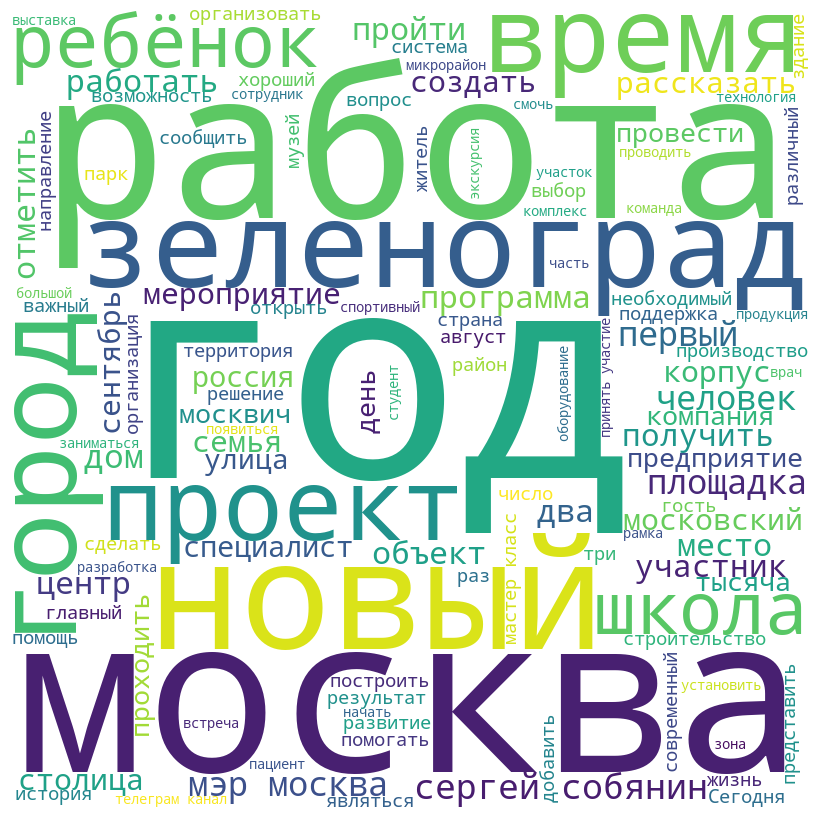

In [11]:
from wordcloud import WordCloud
import ru_core_news_sm
import stop_words


import matplotlib.pyplot as plt1

f = open("all.txt", 'r',encoding="UTF-8")
txt = f.read()
f.close()

nlp = ru_core_news_sm.load()

# Записываем в переменную стоп-слова русского языка


wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=nlp.Defaults.stop_words,
                      min_font_size=10).generate(txt)

plt1.figure(figsize=(8, 8), facecolor=None)
plt1.imshow(wordcloud)
plt1.axis("off")
plt1.tight_layout(pad=0)
plt1.show()

Глаголы, связанные с именованными сущностями в синтаксическом дереве.

In [12]:
#Функции для поиска зависимых слов
def find_head(token):    
    if token != token.head:
     #   print("идем выше")        
        return find_head(token.head)
    else:
        return token.head     

def find_dep(token, deps, pos):
    if token.pos_ == pos:
            deps.add(token.lemma_)
    ll = [child for child in token.children]
    for t in ll:
        if t.pos_ == pos:
            deps.add(t.lemma_)
        find_dep(t, deps, pos)


#Загружаем данные из датафрейма и разбиваем на предложения
df = pd.read_csv('data.csv')
list_text = df['Текст'].tolist()
list_predl = []
for s in list_text:
    txt = s
    txt = txt.replace('\n', '') 
    txt = txt.replace('\r', '')
    txt = txt.replace('\xa0', ' ')
    ll = txt.split('.')
    for l in ll:
        list_predl.append(l.strip())
#
links_ners = []
links_verbs = []

links_ners1 = []
links_adjs = []

for l in tqdm(list_predl[:500]):
    #print('*' * 10)
    #print(l)
    doc = nlp(l)
    for token in doc:
        if token.pos_ == 'PROPN':
            head = find_head(token)
            
            deps = set()
            find_dep(head, deps, 'VERB')
            ll = list(deps)
            if len(ll) > 0:
                if token.lemma_ in links_ners:
                    i = links_ners.index(token.lemma_)
                    for l in ll:
                        links_verbs[i].append(l)
                else:
                    links_ners.append(token.lemma_)
                    links_verbs.append(ll)
                    
            deps = set()
            find_dep(head, deps, 'ADJ')
            ll = list(deps)
            if len(ll) > 0:
                if token.lemma_ in links_ners1:
                    i = links_ners1.index(token.lemma_)
                    for l in ll:
                        links_adjs[i].append(l)
                else:
                    links_ners1.append(token.lemma_)
                    links_adjs.append(ll)        

#
for i in range(len(links_ners)):
    if len(links_verbs[i]) < 5:
        continue
    df1 = pd.DataFrame({"Verb": links_verbs[i]})
    df1['Frequency'] = 1
    df1 =  pd.pivot_table(df1, index=["Verb"], values=["Frequency"], aggfunc="sum")
    if len(df1) < 5:
        continue
    df1 = df1.sort_values(by=['Frequency'] , ascending=False)
    print('*'*10)
    print(links_ners[i])
    print(df1.head(5))

100%|██████████| 500/500 [00:02<00:00, 169.29it/s]

**********
москва
                 Frequency
Verb                      
сообщить                15
функционировать          4
стать                    4
получить                 4
рассказать               3
**********
зеленоград
           Frequency
Verb                
отметить           2
забывать           1
проходить          1
стать              1
сообщить           1
**********
-
             Frequency
Verb                  
будет                2
возводиться          2
подготовить          2
получить             2
заложить             1
**********
анастасия
             Frequency
Verb                  
заявить              1
подарить             1
подготовить          1
подчеркнуть          1
пожелать             1
**********
ракова
              Frequency
Verb                   
заявить               1
начинать              1
отметить              1
поддерживать          1
подчеркнуть           1
**********
владимир
               Frequency
Verb                    
вестись     

Глаголы плохо характеризуют именованные сущности, с которыми они связаны в синтаксическом дереве, возможно, потому, что эта связь должна быть более тесной, чем она есть в коде

Прилагательные, связанные с именованными сущностями в синтаксическом дереве.

In [ ]:
for i in range(len(links_ners1)):
    
    if len(links_adjs[i]) < 5:
        continue

    df1 = pd.DataFrame({"Adj": links_adjs[i]})
    df1['Frequency'] = 1
    df1 =  pd.pivot_table(df1, index=["Adj"], values=["Frequency"], aggfunc="sum")
    if len(df1) < 5:
        continue
    
    df1 = df1.sort_values(by=['Frequency'] , ascending=False)
    print('*'*10)
    print(links_ners1[i])
    print(df1.head(5))

**********
зеленоград
                 Frequency
Adj                       
12-й                     1
новогодний               1
уборочный                1
территориальный          1
самый                    1
**********
сердце
                Frequency
Adj                      
2023                    1
киевский                1
круглогодичный          1
первый                  1
регулярный              1
**********
печатники
                Frequency
Adj                      
2023                    1
киевский                1
круглогодичный          1
первый                  1
регулярный              1
**********
парк
                  Frequency
Adj                        
вкусный                   1
гастрономический          1
киевский                  1
новый                     1
первый                    1
**********
москва
                Frequency
Adj                      
2024                    6
столичный               5
таможенный              5
особый                  4


Прилагательные характеризуют сущности иногда хорошо, иногда не очень хорошо. Так, мцд охарактеризовано достаточно хорошо: московский, центральный, близкий и тд, а Собянин оказался высокотехнологичным.. 